# Sunlight Harvesting Energy Conversion

In [1]:
import os
import math
import random
import numpy as np
import polars as pl
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 5]
pl.Config.set_tbl_rows(256)

import nmf.nmf as nmf
import knee.kneedle as kneedle

from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.mixture import GaussianMixture

from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# Remove SciKit Learn warnings
import warnings
warnings.filterwarnings('ignore')
os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

## Dataset visualization and analysis

In [2]:
df = pl.read_excel('db.xlsx')
df = df.drop(['#'])
df

shape: (201, 11)
┌─────────┬───────────┬──────────┬─────────┬───┬────────┬────────┬──────────┬──────────┐
│ mat0    ┆ mat1      ┆ abs_peak ┆ abs_min ┆ … ┆ em_max ┆ QY (%) ┆ hopt (%) ┆ PCE (%)  │
│ ---     ┆ ---       ┆ ---      ┆ ---     ┆   ┆ ---    ┆ ---    ┆ ---      ┆ ---      │
│ str     ┆ str       ┆ i64      ┆ i64     ┆   ┆ i64    ┆ f64    ┆ f64      ┆ f64      │
╞═════════╪═══════════╪══════════╪═════════╪═══╪════════╪════════╪══════════╪══════════╡
│ dye     ┆ film      ┆ 578      ┆ 420     ┆ … ┆ 750    ┆ 98.0   ┆ 18.8     ┆ null     │
│ dye     ┆ bulk      ┆ 540      ┆ 400     ┆ … ┆ 690    ┆ null   ┆ null     ┆ null     │
│ dye     ┆ bulk      ┆ 540      ┆ 400     ┆ … ┆ 690    ┆ null   ┆ null     ┆ null     │
│ QD      ┆ bulk      ┆ 730      ┆ 600     ┆ … ┆ 1000   ┆ null   ┆ 2.5      ┆ null     │
│ QD      ┆ bulk      ┆ 730      ┆ 600     ┆ … ┆ 1000   ┆ null   ┆ 2.5      ┆ null     │
│ QD      ┆ fiber     ┆ 730      ┆ 600     ┆ … ┆ 1000   ┆ null   ┆ 4.0      ┆ null     │
│ QD      ┆ fiber     ┆ 730      ┆ 600     ┆ … ┆ 1000   ┆ null   ┆ 7.0      ┆ null     │
│ QD      ┆ solution  ┆ 800      ┆ 400     ┆ … ┆ 1000   ┆ 30.0   ┆ 1.4      ┆ 3.2      │
│ QD      ┆ solution  ┆ 600      ┆ 400     ┆ … ┆ 700    ┆ 50.0   ┆ 0.5      ┆ 1.2      │
│ dye     ┆ solution  ┆ 550      ┆ 450     ┆ … ┆ 650    ┆ null   ┆ null     ┆ 1.3      │
│ QD      ┆ solution  ┆ 376      ┆ 300     ┆ … ┆ 700    ┆ 50.0   ┆ 0.3      ┆ null     │
│ dye     ┆ solution  ┆ 413      ┆ 400     ┆ … ┆ 800    ┆ 67.0   ┆ 3.4      ┆ null     │
│ dye     ┆ solution  ┆ 550      ┆ 450     ┆ … ┆ 750    ┆ 95.0   ┆ 2.6      ┆ null     │
│ dye     ┆ solution  ┆ 466      ┆ 300     ┆ … ┆ 900    ┆ 11.0   ┆ 0.6      ┆ null     │
│ dye     ┆ solution  ┆ 557      ┆ 300     ┆ … ┆ 900    ┆ 9.0    ┆ 0.5      ┆ null     │
│ polymer ┆ solution  ┆ 460      ┆ 350     ┆ … ┆ 800    ┆ 45.0   ┆ 1.0      ┆ null     │
│ polymer ┆ solution  ┆ 467      ┆ 300     ┆ … ┆ 700    ┆ 48.0   ┆ 0.9      ┆ null     │
│ dye     ┆ film      ┆ 403      ┆ 300     ┆ … ┆ 600    ┆ 40.8   ┆ 7.7      ┆ null     │
│ dye     ┆ bulk      ┆ 374      ┆ 300     ┆ … ┆ 600    ┆ 100.0  ┆ null     ┆ null     │
│ dye     ┆ bulk      ┆ 370      ┆ 300     ┆ … ┆ 750    ┆ 67.0   ┆ 5.5      ┆ null     │
│ NP      ┆ bulk      ┆ 470      ┆ 400     ┆ … ┆ 725    ┆ null   ┆ 4.09     ┆ 3.55     │
│ dye     ┆ bulk      ┆ 620      ┆ 400     ┆ … ┆ 800    ┆ null   ┆ null     ┆ 0.55     │
│ dye     ┆ bulk      ┆ 340      ┆ 300     ┆ … ┆ 700    ┆ 14.0   ┆ 0.25     ┆ null     │
│ dye     ┆ bulk      ┆ 340      ┆ 300     ┆ … ┆ 600    ┆ 78.0   ┆ 0.4      ┆ null     │
│ dye     ┆ bulk      ┆ 580      ┆ 300     ┆ … ┆ 800    ┆ 100.0  ┆ null     ┆ 0.0018   │
│ dye     ┆ film      ┆ 745      ┆ 400     ┆ … ┆ 900    ┆ 25.0   ┆ null     ┆ 0.61     │
│ dye     ┆ film      ┆ 745      ┆ 400     ┆ … ┆ 900    ┆ 25.0   ┆ null     ┆ 1.24     │
│ dye     ┆ film      ┆ 745      ┆ 400     ┆ … ┆ 900    ┆ 25.0   ┆ null     ┆ 0.54     │
│ dye     ┆ film      ┆ 745      ┆ 400     ┆ … ┆ 900    ┆ 25.0   ┆ null     ┆ 1.41     │
│ dye     ┆ bulk      ┆ 525      ┆ 400     ┆ … ┆ 800    ┆ 97.6   ┆ null     ┆ 2.6      │
│ NP      ┆ bulk      ┆ 375      ┆ 300     ┆ … ┆ 900    ┆ 45.0   ┆ 4.25     ┆ 1.33     │
│ Lndye   ┆ fiber     ┆ 540      ┆ 350     ┆ … ┆ 700    ┆ null   ┆ 0.29     ┆ null     │
│ dye     ┆ bulk      ┆ 380      ┆ 300     ┆ … ┆ 700    ┆ null   ┆ 10.4     ┆ 2.2      │
│ NP      ┆ bulk      ┆ 550      ┆ 400     ┆ … ┆ 1000   ┆ 80.0   ┆ 6.8      ┆ null     │
│ QD      ┆ film      ┆ 450      ┆ 370     ┆ … ┆ 700    ┆ null   ┆ null     ┆ null     │
│ QD      ┆ film      ┆ 450      ┆ 400     ┆ … ┆ 975    ┆ 40.0   ┆ null     ┆ null     │
│ QD      ┆ waveguide ┆ 650      ┆ 500     ┆ … ┆ 850    ┆ 63.0   ┆ 1.75     ┆ null     │
│ QD      ┆ solution  ┆ 650      ┆ 500     ┆ … ┆ 850    ┆ 63.0   ┆ 3.67     ┆ null     │
│ QD      ┆ film      ┆ 480      ┆ 300     ┆ … ┆ 670    ┆ 36.2   ┆ 2.95     ┆ 2.25     │
│ CD      ┆ bulk      ┆ 350      ┆ 300     ┆ … ┆ 575    ┆ null   ┆ 

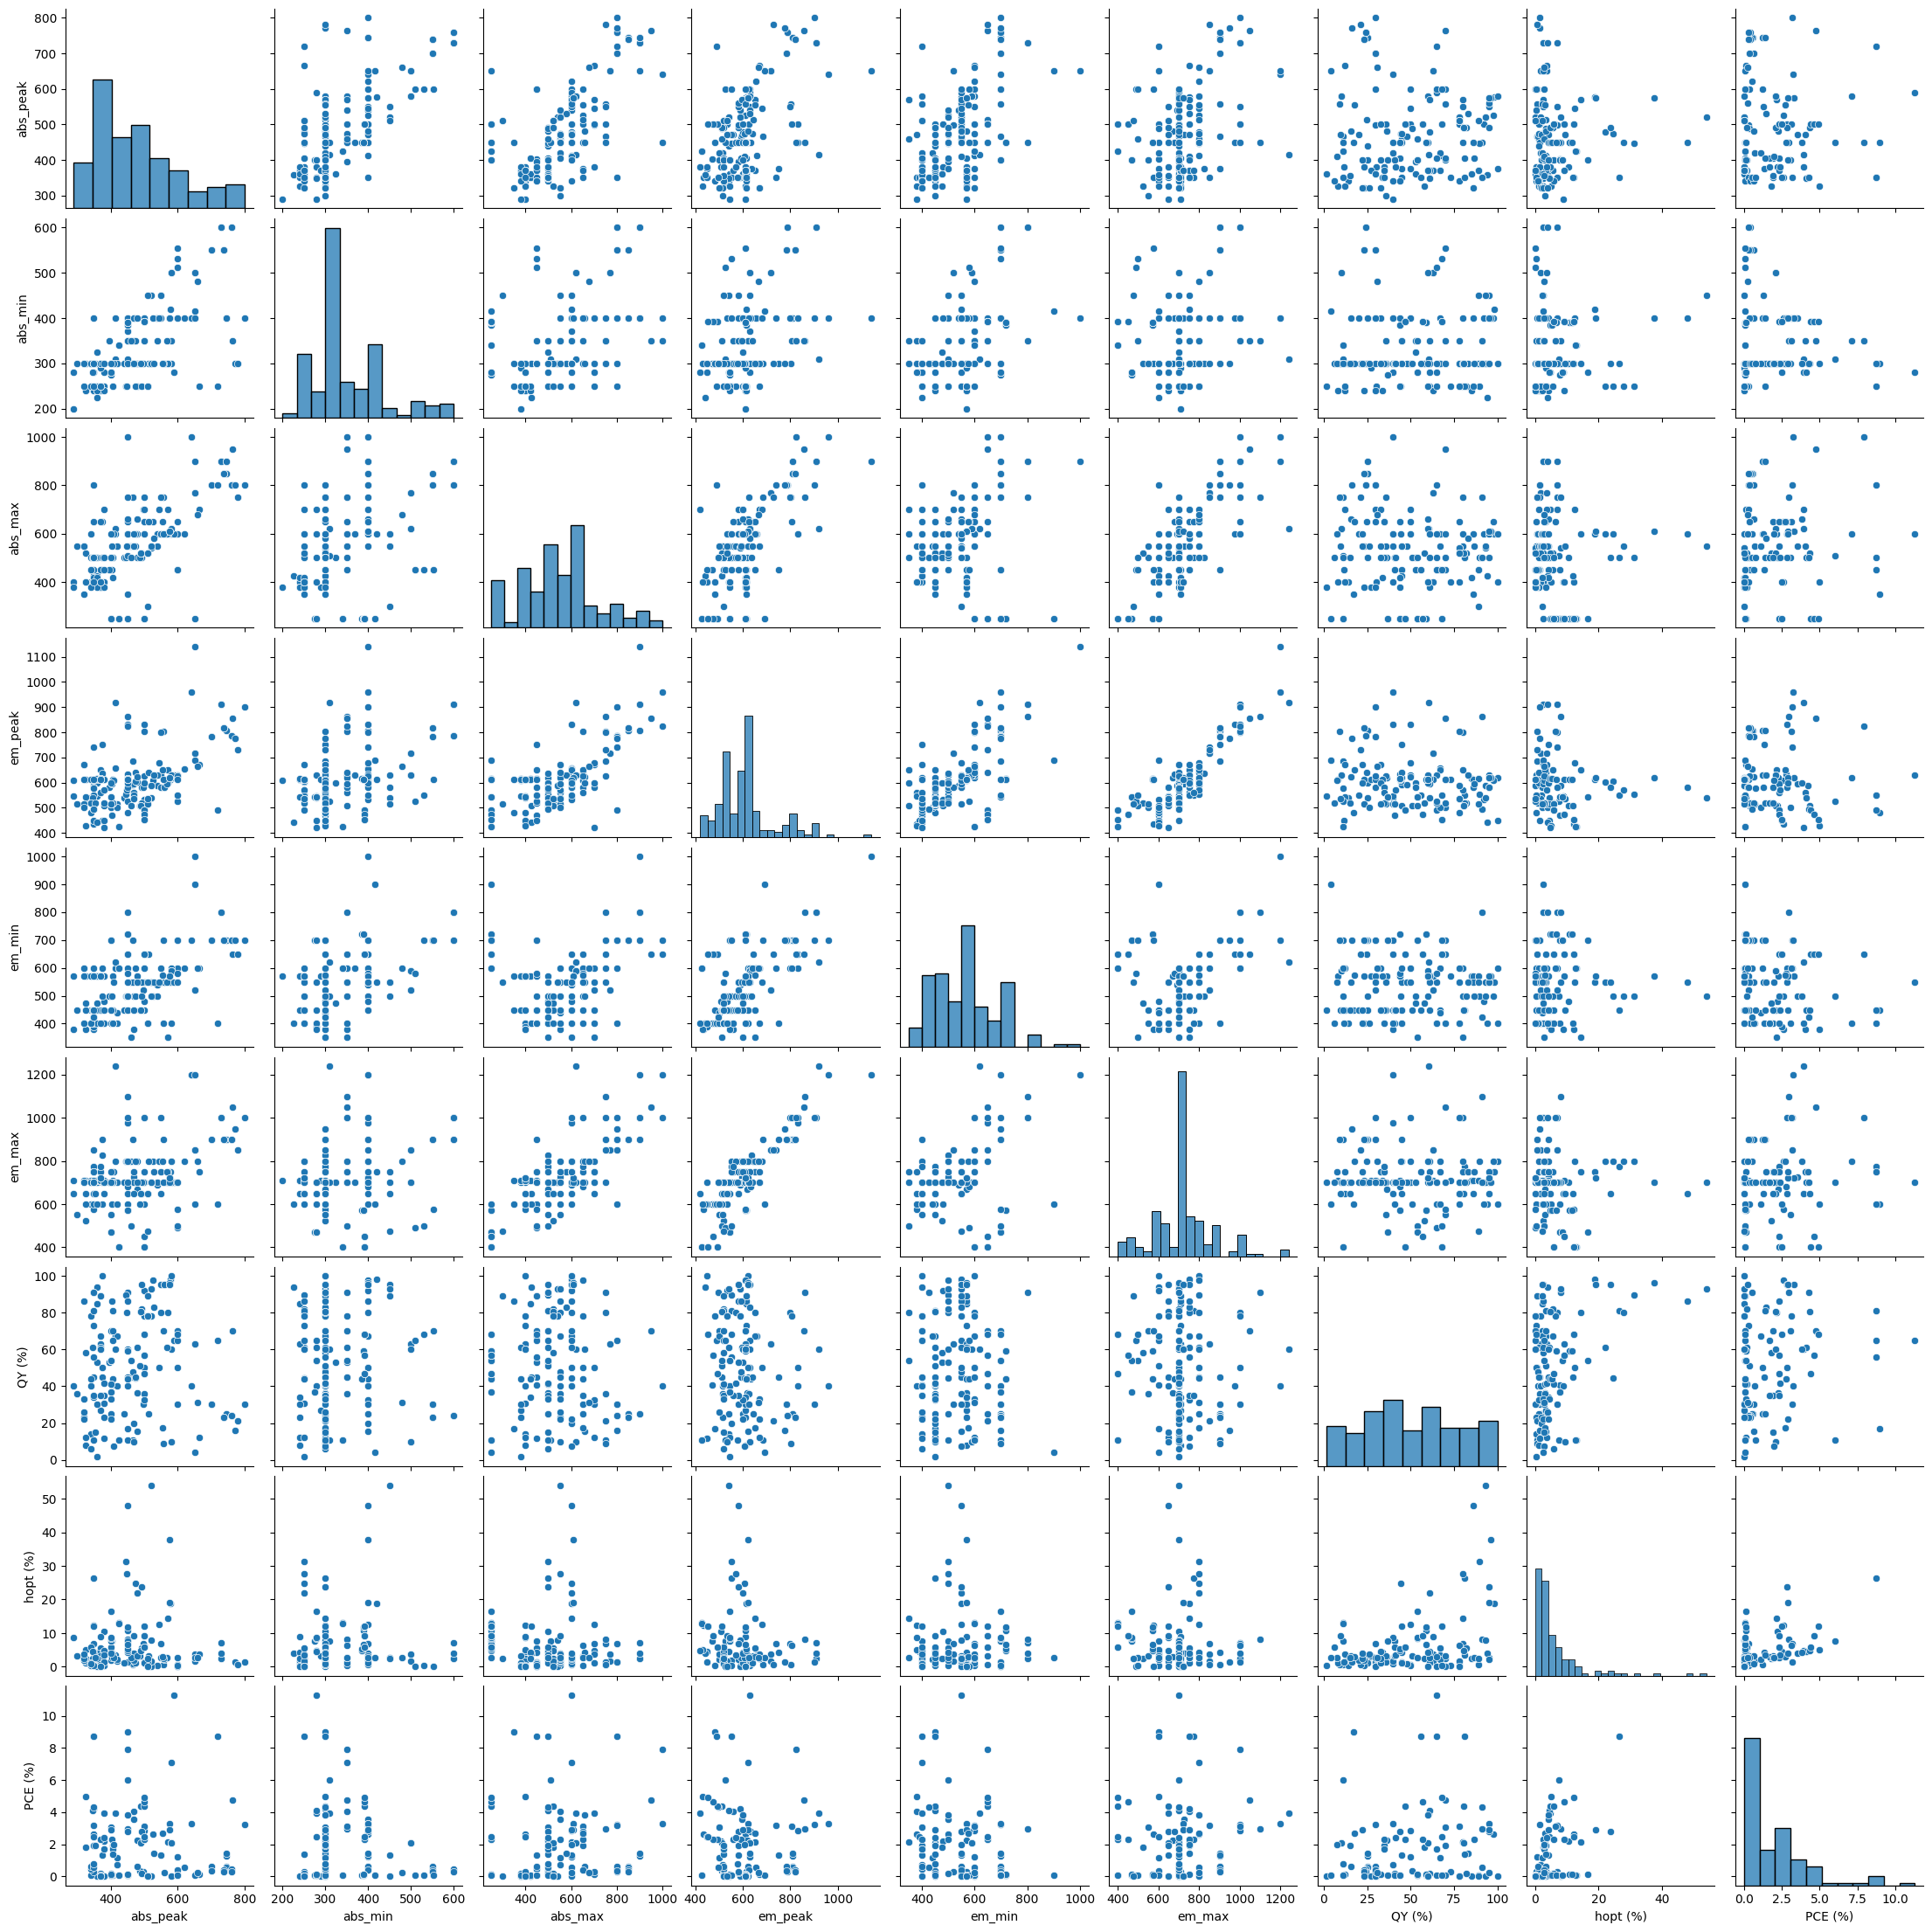

In [81]:
sns.pairplot(df.to_pandas())
plt.show()

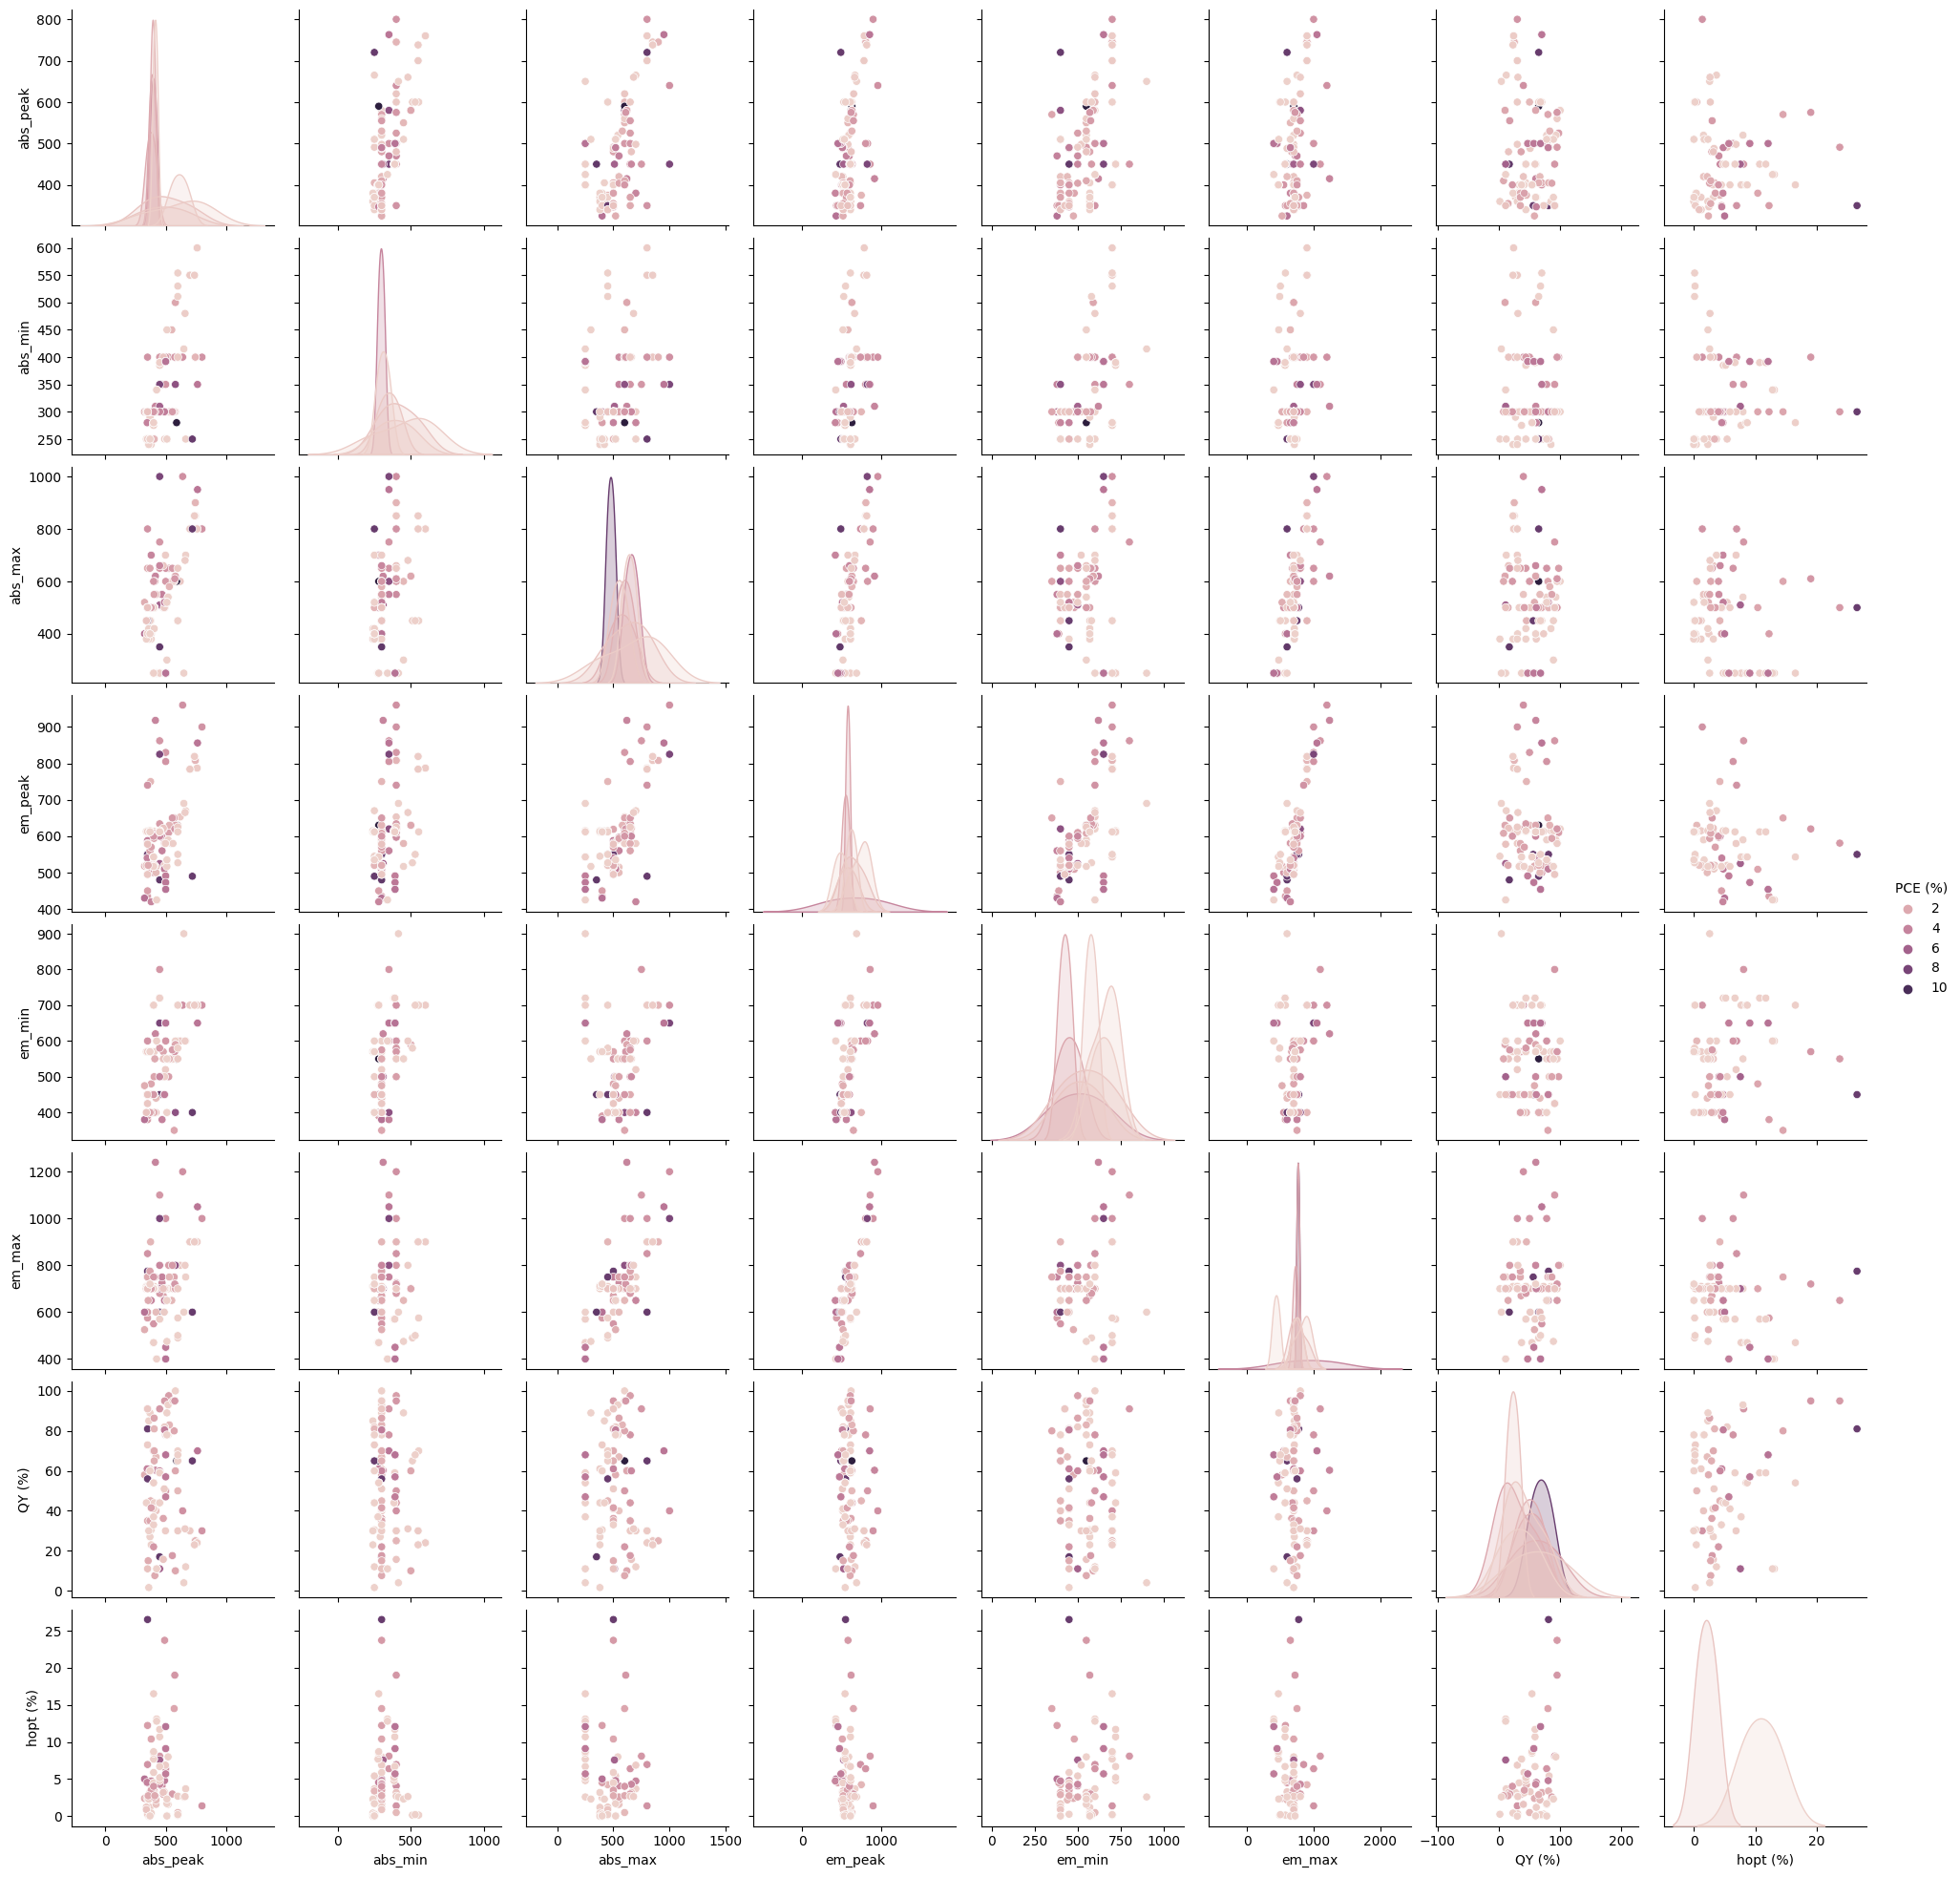

In [82]:
sns.pairplot(df.to_pandas(), hue='PCE (%)')
plt.show()

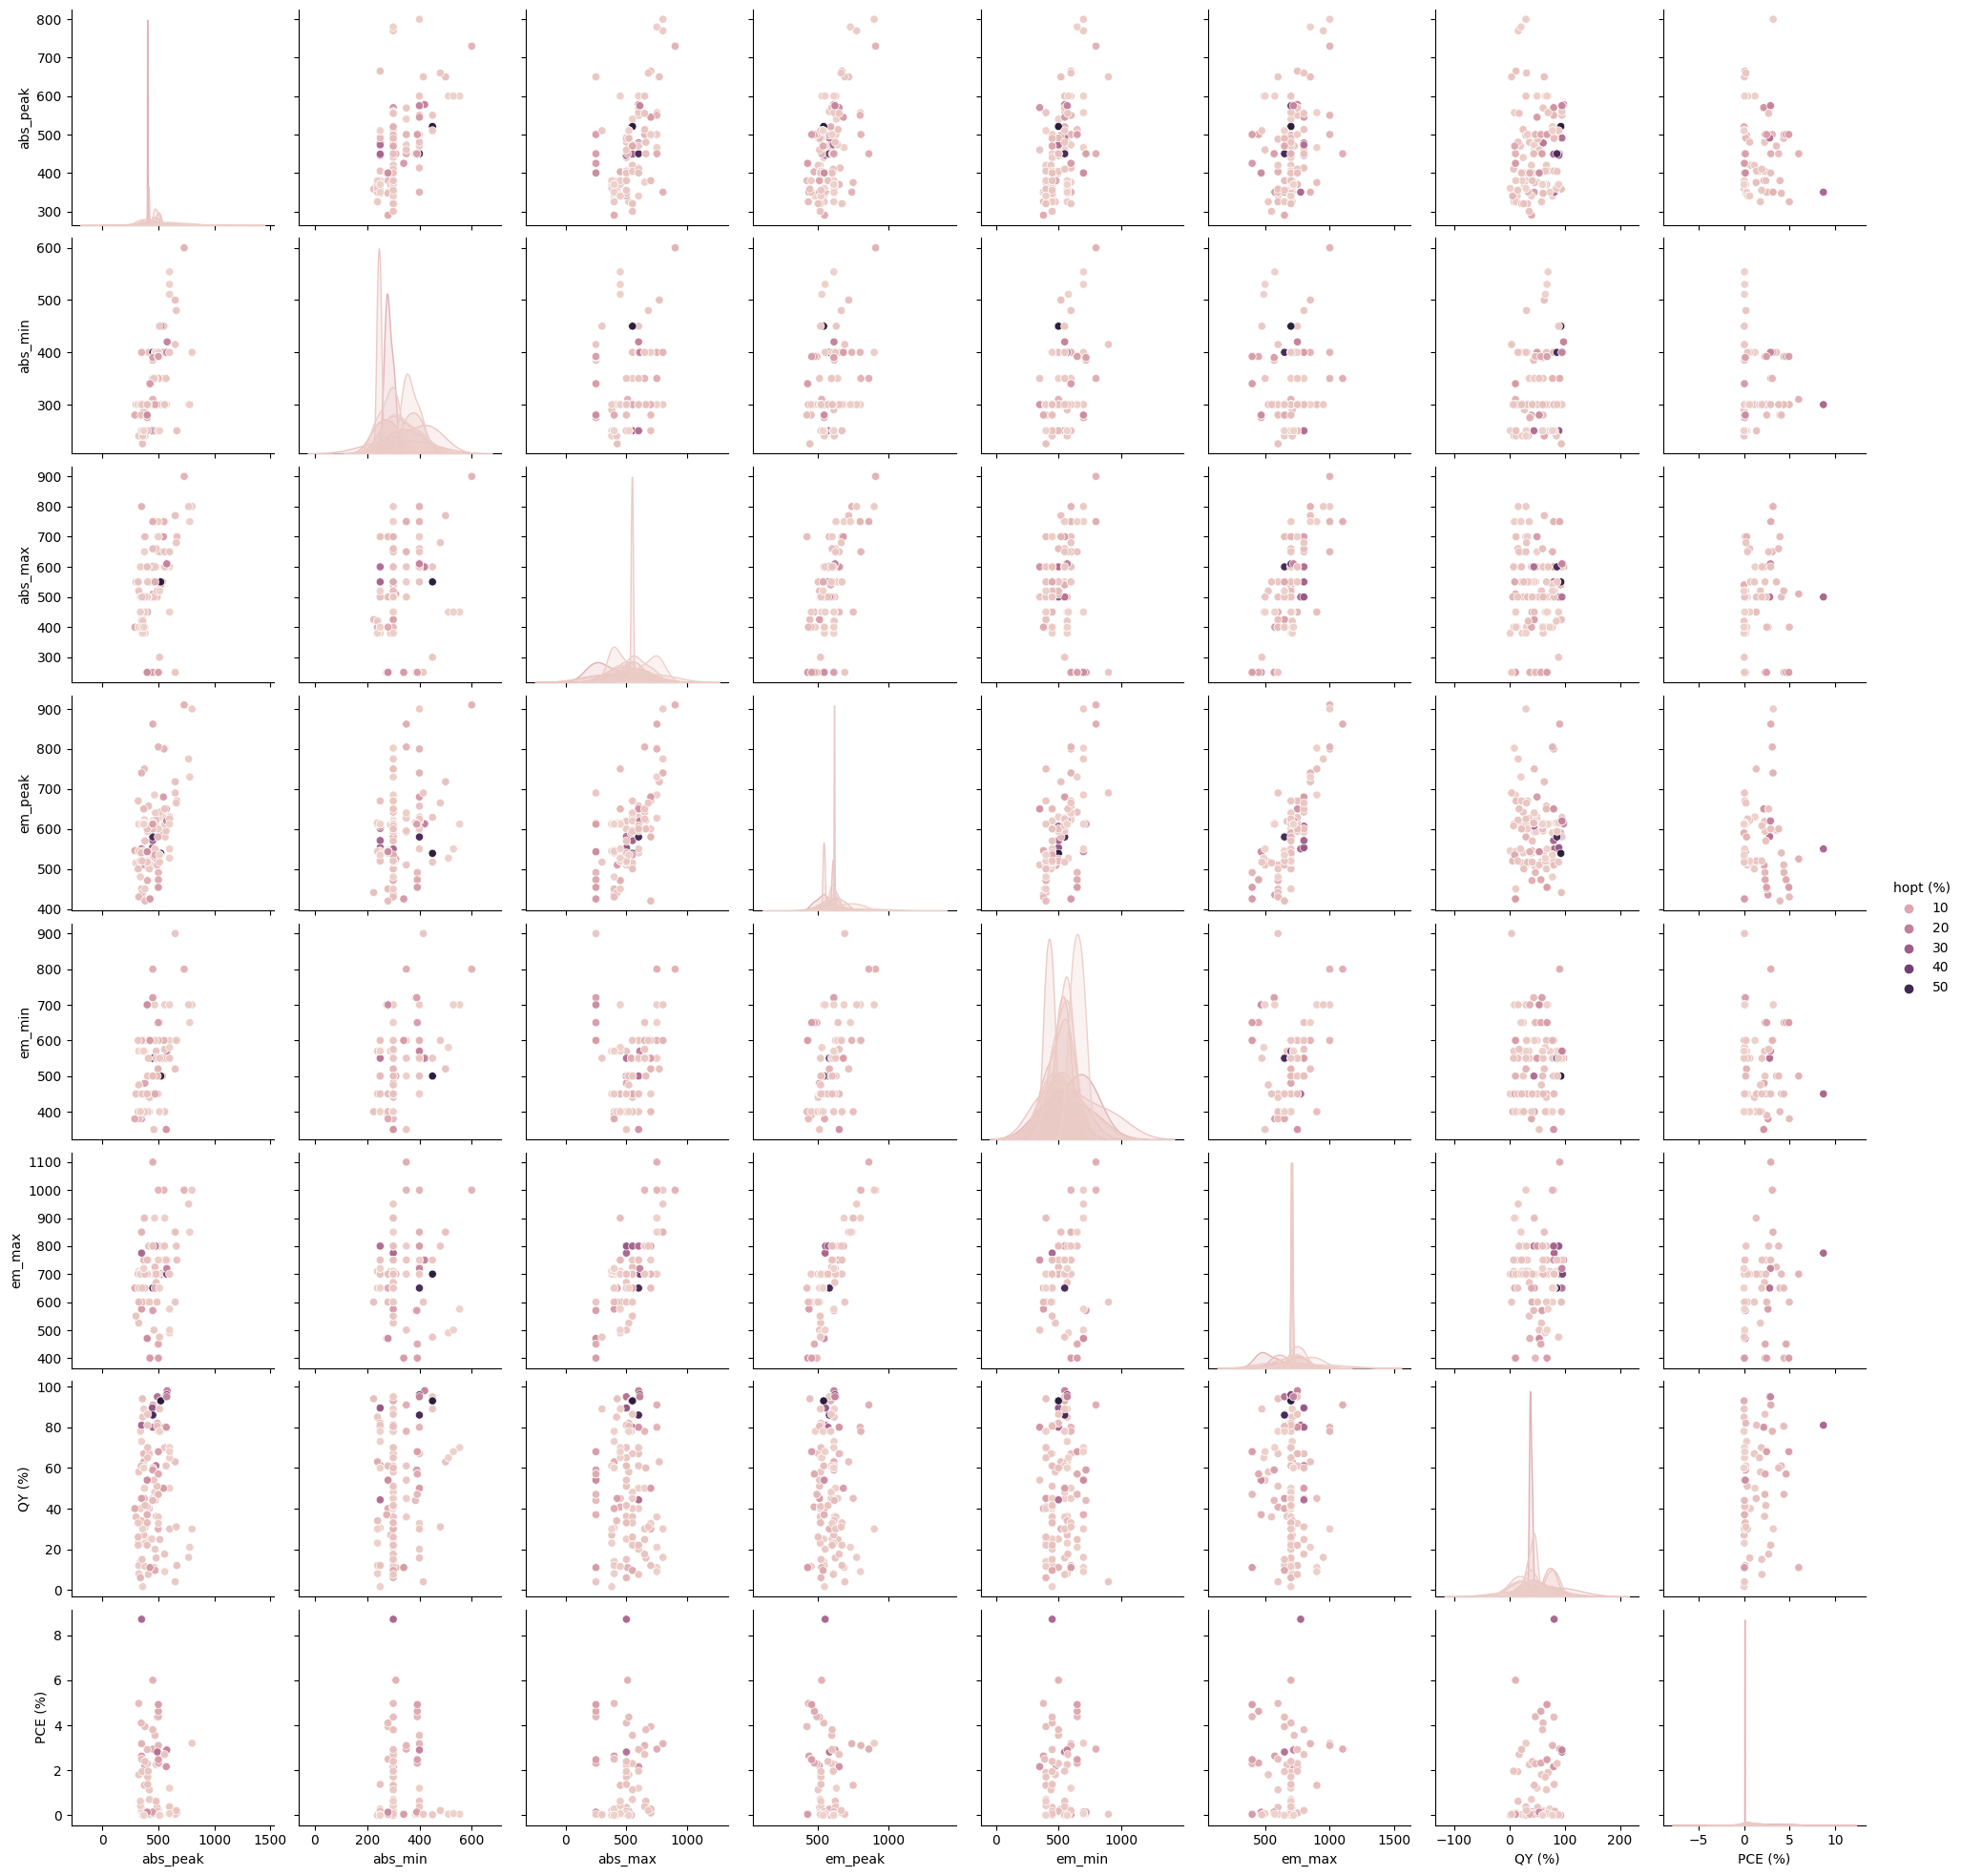

In [83]:
sns.pairplot(df.to_pandas(), hue='hopt (%)')
plt.show()

In [84]:
def idx_to_rowcol(idx, width):
    r = int(idx / width)
    c = int(idx % width)
    return (r,c)


def rowcol_to_idx(r,c, width):
    idx = int((r * width) + c)
    return idx


def describe_variables(df, categorical=['mat0', 'mat1'], cols=4, figsize=(20,15)):
    # get the pandas dataframe (since polars does not allow plots)
    df_pandas = df.to_pandas()
    for col in categorical:
        df_pandas[col] = df_pandas[col].astype('category')
    
    # compute the number of rows
    total = (2 * len(df.get_columns())) - len(categorical)
    rows = math.ceil(total/cols)
    fig, axes = plt.subplots(rows, cols, constrained_layout = True, figsize=figsize)
    #print(f'Total {total} -> ({rows} {cols})')
    
    idx = 0
    for col in df.get_columns():
        r, c = idx_to_rowcol(idx, cols)
        #print(f'({col.name}: {idx} -> {r}, {c})')
        sns.histplot(ax=axes[r, c], data=df_pandas, x=col.name)
        idx += 1
        if col.name not in categorical:
            r, c = idx_to_rowcol(idx, cols)
            #print(f'({col.name}: {idx} -> {r}, {c})')
            sns.boxplot(ax=axes[r, c], data=df_pandas, x=col.name)
            idx += 1
    plt.show()

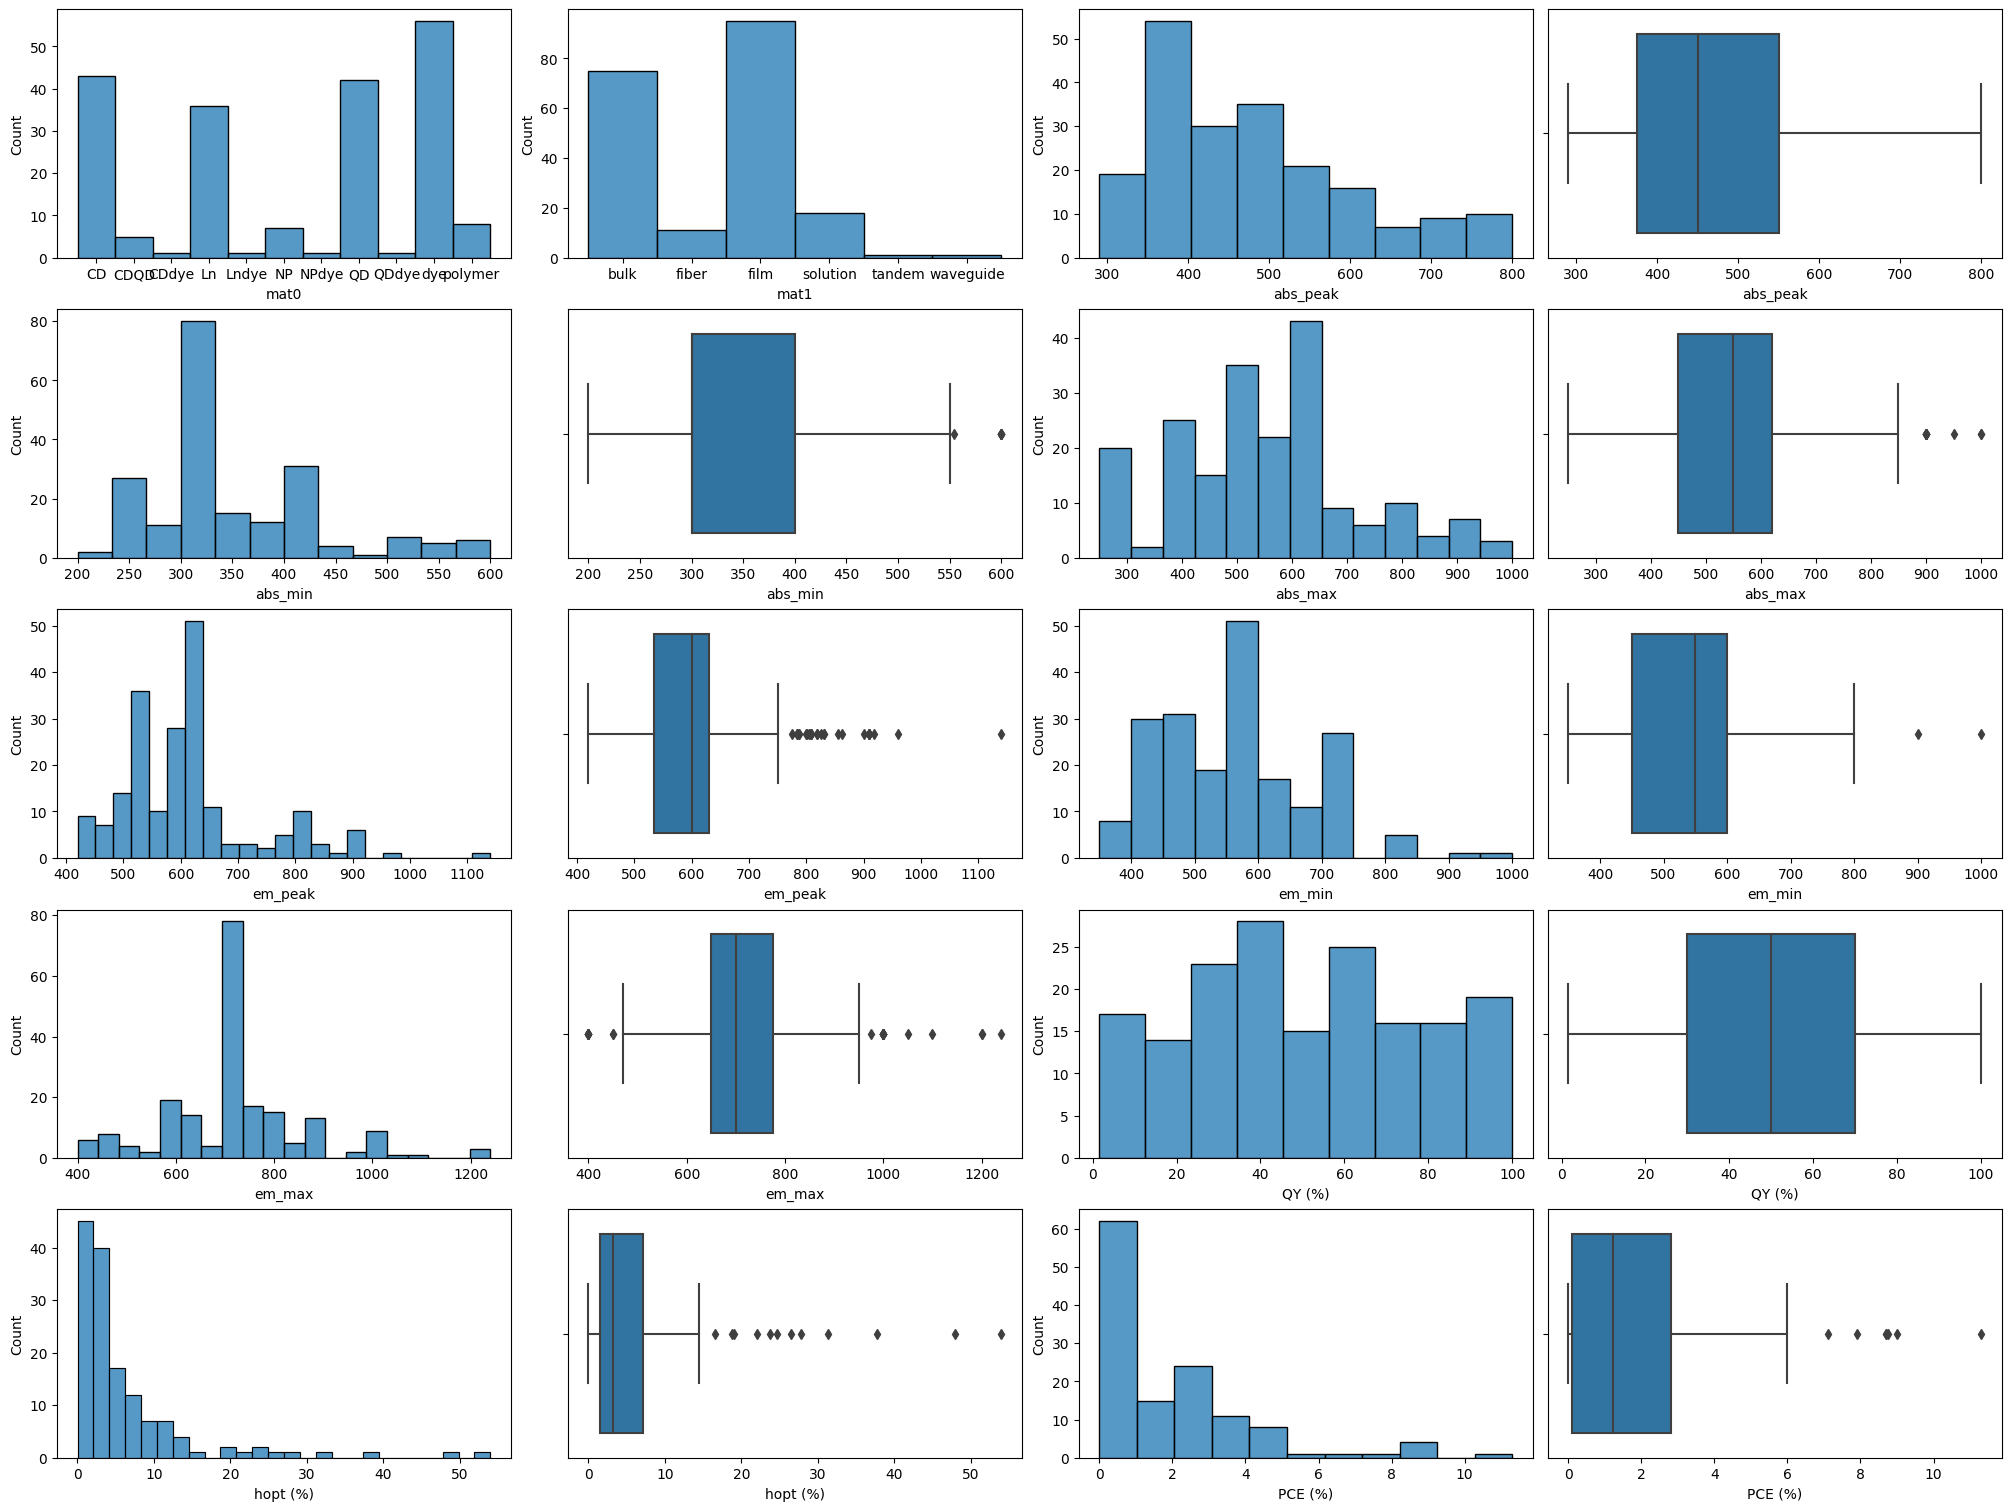

In [85]:
describe_variables(df)

In [19]:
def print_missing_samples(df):
    print(f'Shape: {df.shape}')
    total, _ = df.shape
    for col in df.get_columns():
        print(f'{col.name:<6}: {col.is_null().sum()/total:.0%}')

In [20]:
print_missing_samples(df)

Shape: (201, 11)
mat0  : 0%
mat1  : 0%
abs_peak: 0%
abs_min: 0%
abs_max: 0%
em_peak: 0%
em_min: 0%
em_max: 0%
QY (%): 14%
hopt (%): 28%
PCE (%): 36%


## PCE and hopt prediction

### Baseline (using only abs and em)

In [21]:
df_baseline_PCE = df.drop(['mat0', 'mat1', 'QY (%)', 'hopt (%)']).drop_nulls()
print_missing_samples(df_baseline_PCE)

Shape: (128, 7)
abs_peak: 0%
abs_min: 0%
abs_max: 0%
em_peak: 0%
em_min: 0%
em_max: 0%
PCE (%): 0%


In [22]:
df_baseline_hopt = df.drop(['mat0', 'mat1', 'QY (%)', 'PCE (%)']).drop_nulls()
print_missing_samples(df_baseline_hopt)

Shape: (144, 7)
abs_peak: 0%
abs_min: 0%
abs_max: 0%
em_peak: 0%
em_min: 0%
em_max: 0%
hopt (%): 0%


In [23]:
max_depth = [int(x) for x in np.linspace(10, 100, num = 5)]
max_depth.append(None)

# TODO: fix this
# Print Models parameters
models = [('Linear Regression', LinearRegression(), {}),
          ('K Neighbors', KNeighborsRegressor(),
           {'reg__n_neighbors':[1,3,5,7,9], 'reg__weights':['uniform', 'distance'], 'reg__p':[1,2]}),
          ('Random Forest', RandomForestRegressor(random_state=42),
           {'reg__n_estimators':[50, 100, 150, 200], 'reg__min_samples_split':[2, 5, 10],
            'reg__min_samples_leaf':[1, 2, 4], 'reg__bootstrap':[True, False], 'reg__max_depth':max_depth}),
          ('Gradient Boosting', GradientBoostingRegressor(random_state=42),
           {'reg__n_estimators':[50, 100, 150, 200],'reg__min_samples_split':[2, 5, 10],
            'reg__min_samples_leaf':[1, 2, 4], 'reg__max_depth':max_depth}),
         ('XGBoost', xgb.XGBRegressor(objective="reg:squarederror", random_state=42),
          {'reg__max_depth': range (2, 10, 1), 'reg__n_estimators': range(60, 220, 40), 'reg__learning_rate': [0.1, 0.01, 0.05]})]

# remove heavy models that do not perform that well
#('Lasso Regression', Lasso(max_iter=5000, tol=1E-2, random_state=42), {'alpha': (np.logspace(-8, 8, 20))}),
#('Support Vector Regressor', SVR(),{'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01],'kernel': ['linear','rbf', 'sigmoid']}),
#('ANN', MLPRegressor(max_iter=50000,  tol=1E-3, random_state=42),{'hidden_layer_sizes':[(8,), (16,), (32,)],'activation':['relu','logistic'], 'learning_rate':['constant', 'invscaling', 'adaptive']}),

In [24]:
def create_folds(X, y, b=None, k=5):
    if b is None:
        bins = np.histogram_bin_edges(y, bins='auto')
    else:
        bins = np.linspace(min(y), max(y), num=b, endpoint=False)
        # remove the last index (end point)
        bins = bins[:-1]
    #print(f'Bins: {bins}')
    groups = np.digitize(y, bins)
    #print(f'Group: {groups}')
    skf = StratifiedKFold(n_splits=k)
    return skf.split(X, groups)

In [29]:
def compute_performance(models, X, y, b=None, cv=3):
    #kf = KFold(n_splits=cv)
    folds = create_folds(X, y, b=b, k=cv)
    
    perf_per_model = {}
    y_true = []
    y_true_train = []
    y_preds = {}
    y_preds_train = {}
    #for train_index, test_index in kf.split(X):
    for train_index, test_index in folds:
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
    
        y_true.extend(y_test)
        y_true_train.extend(y_train)
    
        # optimize each model and store the best result
        best_models = []
        for _, model, params in models:
            pipeline = Pipeline([('sca', StandardScaler()),('reg', model)])
            #clf = GridSearchCV(pipeline, params, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)
            grid_folds = create_folds(X_train, y_train, b=b, k=cv)
            #clf = GridSearchCV(pipeline, params, cv=cv, scoring='r2', n_jobs=-1)
            clf = GridSearchCV(pipeline, params, cv=grid_folds, scoring='r2', n_jobs=-1)
            clf.fit(X_train, y_train)
            best_models.append(clf.best_estimator_)

        # compute the predictions and store the results
        for i in range(len(models)):
            model = best_models[i]
            y_pred = model.predict(X_test)
            y_pred_train = model.predict(X_train)
            
            if models[i][0] not in y_preds:
                y_preds[models[i][0]] = []
            
            if models[i][0] not in y_preds_train:
                y_preds_train[models[i][0]] = []
            
            y_preds[models[i][0]].extend(y_pred)
            y_preds_train[models[i][0]].extend(y_pred_train)
            
            score_mae_test = mean_absolute_error(y_test, y_pred)
            score_mse_test = mean_squared_error(y_test, y_pred)
            score_r2_test = r2_score(y_test, y_pred)
            
            score_mae_train = mean_absolute_error(y_train, y_pred_train)
            score_mse_train = mean_squared_error(y_train, y_pred_train)
            score_r2_train = r2_score(y_train, y_pred_train)
            
            if models[i][0] not in perf_per_model:
                perf_per_model[models[i][0]] = {'train':{'mae':[], 'mse': [], 'r2':[]},
                                                'test':{'mae':[], 'mse': [], 'r2':[]}}
            
            perf_per_model[models[i][0]]['test']['mae'].append(score_mae_test)
            perf_per_model[models[i][0]]['test']['mse'].append(score_mse_test)
            perf_per_model[models[i][0]]['test']['r2'].append(score_r2_test)
            
            perf_per_model[models[i][0]]['train']['mae'].append(score_mae_train)
            perf_per_model[models[i][0]]['train']['mse'].append(score_mse_train)
            perf_per_model[models[i][0]]['train']['r2'].append(score_r2_train)
            
    # print the results
    print(f'Train')
    print(f'| {"Model":^17} | {"MAE":^6} | {"MSE":^6} | {"R2":^6} |')
    print(f'| ----------------- | ------ | ------ | ------ |')
    for i in range(len(models)):
        mae = perf_per_model[models[i][0]]['train']['mae']
        mse = perf_per_model[models[i][0]]['train']['mse']
        r2  = perf_per_model[models[i][0]]['train']['r2']
        #print(f'{mae} | {mse} | {r2}')
        mae = np.mean(mae)
        mse = np.mean(mse)
        r2  = np.mean(r2)
        print(f'| {models[i][0]:<17} | {round(mae, 2):>6} | {round(mse, 2):>6} | {round(r2, 2):>6} |')
    print()
    
    print(f'Test')
    print(f'| {"Model":^17} | {"MAE":^6} | {"MSE":^6} | {"R2":^6} |')
    print(f'| ----------------- | ------ | ------ | ------ |')
    for i in range(len(models)):
        mae = perf_per_model[models[i][0]]['test']['mae']
        mse = perf_per_model[models[i][0]]['test']['mse']
        r2  = perf_per_model[models[i][0]]['test']['r2']
        #print(f'{mae} | {mse} | {r2}')
        mae = np.mean(mae)
        mse = np.mean(mse)
        r2  = np.mean(r2)
        print(f'| {models[i][0]:<17} | {round(mae, 2):>6} | {round(mse, 2):>6} | {round(r2, 2):>6} |')
    print()

    # plot the graphs
    print(f'Train')
    data_train = []
    labels_train = []
    for name, _, _ in models:
        labels_train.append(name)

        # DEBUG STUFF:
        score_mae = mean_absolute_error(y_true_train, y_preds_train[name])
        score_mse = mean_squared_error(y_true_train, y_preds_train[name])
        score_r2 = r2_score(y_true_train, y_preds_train[name])
        print(f'Model {name} {score_mae} {score_mse} {score_r2}')

        data_train.append(np.abs(np.subtract(y_true_train, y_preds_train[name])))
    ax = sns.violinplot(data=data_train)
    ax.set_xticklabels(labels_train)
    plt.show()

    print(f'Test')
    data_preds = []
    labels_preds = []
    for name, _, _ in models:
        labels_preds.append(name)

        # DEBUG STUFF:
        score_mae = mean_absolute_error(y_true, y_preds[name])
        score_mse = mean_squared_error(y_true, y_preds[name])
        score_r2 = r2_score(y_true, y_preds[name])
        print(f'Model {name} {score_mae} {score_mse} {score_r2}')

        data_preds.append(np.abs(np.subtract(y_true, y_preds[name])))
    ax = sns.violinplot(data=data_preds)
    ax.set_xticklabels(labels_preds)
    plt.show()
    
    # convert best_models to a dict and return it
    bm = {}
    for name, model, params in models:
        # train on whole dataset
        pipeline = Pipeline([('sca', StandardScaler()),('reg', model)])
        #clf = GridSearchCV(pipeline, params, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)
        grid_folds = create_folds(X, y, b=b, k=cv)
        clf = GridSearchCV(pipeline, params, cv=grid_folds, scoring='r2', n_jobs=-1)
        clf.fit(X, y)
        bm[name] = clf.best_estimator_

    return bm

PCE
Train
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |    1.4 |   3.99 |   0.21 |
| K Neighbors       |   0.11 |   0.14 |   0.97 |
| Random Forest     |   0.65 |    1.2 |   0.75 |
| Gradient Boosting |   0.26 |   0.25 |   0.95 |
| XGBoost           |   1.06 |   2.62 |   0.48 |

Test
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   2.23 |   8.05 |  -0.67 |
| K Neighbors       |   1.55 |   4.88 |   0.04 |
| Random Forest     |   2.32 |   9.56 |  -1.02 |
| Gradient Boosting |   2.13 |   8.08 |  -0.68 |
| XGBoost           |    1.7 |   5.36 |  -0.09 |

Train


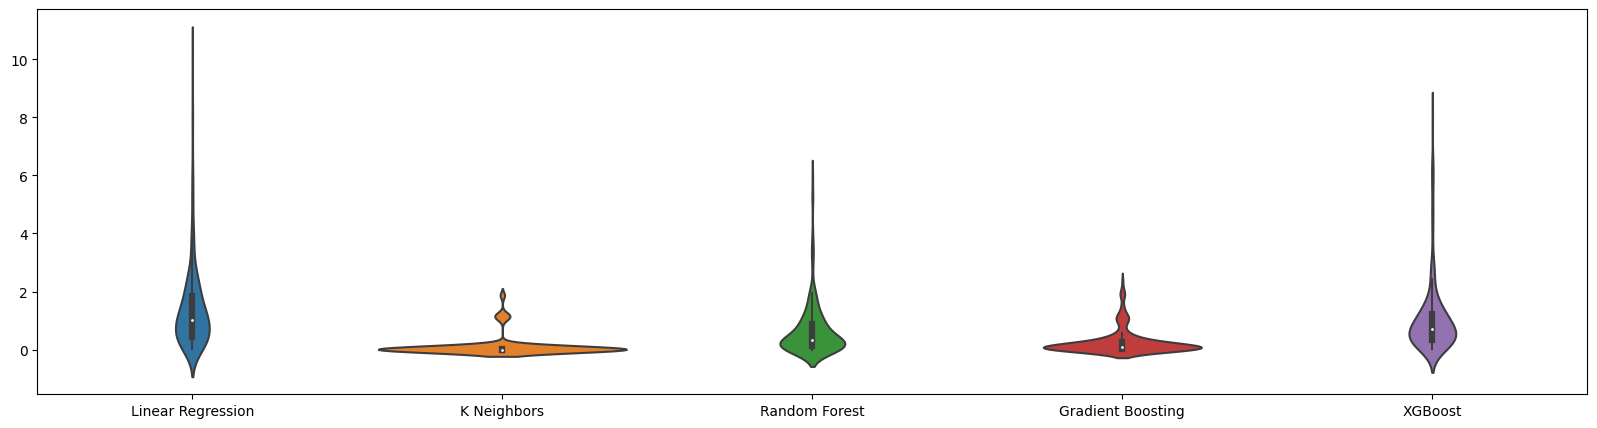

Test


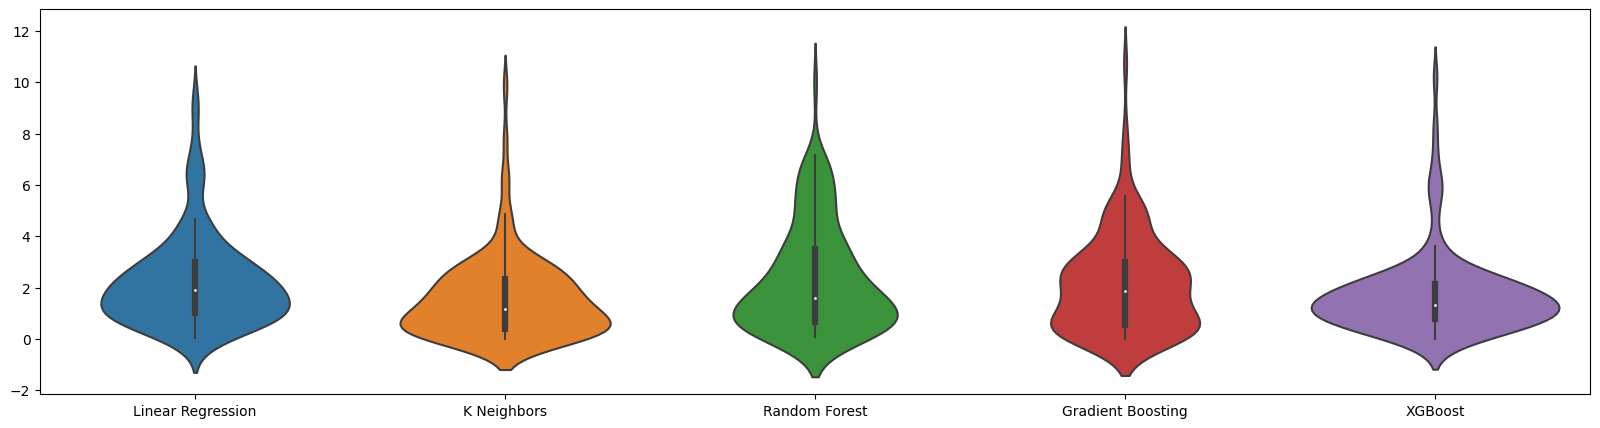

In [30]:
# Get Output variables
PCE = df_baseline_PCE[['PCE (%)']]
y_PCE = PCE.to_numpy()[:,0]
#print(f'{y_PCE} {y_PCE.shape}')

# Get the Input variables
df_input = df_baseline_PCE.drop(['PCE (%)'])
X = df_input.to_numpy()
#print(f'{X} {X.shape}')

## PCE
print(f'PCE')
models_pce_baseline = compute_performance(models, X, y_PCE)

hopt
Train
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   5.08 |  63.65 |   0.09 |
| K Neighbors       |   2.63 |  31.41 |   0.58 |
| Random Forest     |   3.15 |  30.81 |   0.58 |
| Gradient Boosting |   0.99 |   4.09 |   0.94 |
| XGBoost           |   4.27 |  65.31 |   0.07 |

Test
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   6.25 |  87.34 |  -0.83 |
| K Neighbors       |   5.94 |  88.93 |   -1.1 |
| Random Forest     |   6.95 | 114.88 |  -2.14 |
| Gradient Boosting |   9.53 | 260.66 |  -9.06 |
| XGBoost           |   4.69 |  84.59 |  -0.26 |

Train


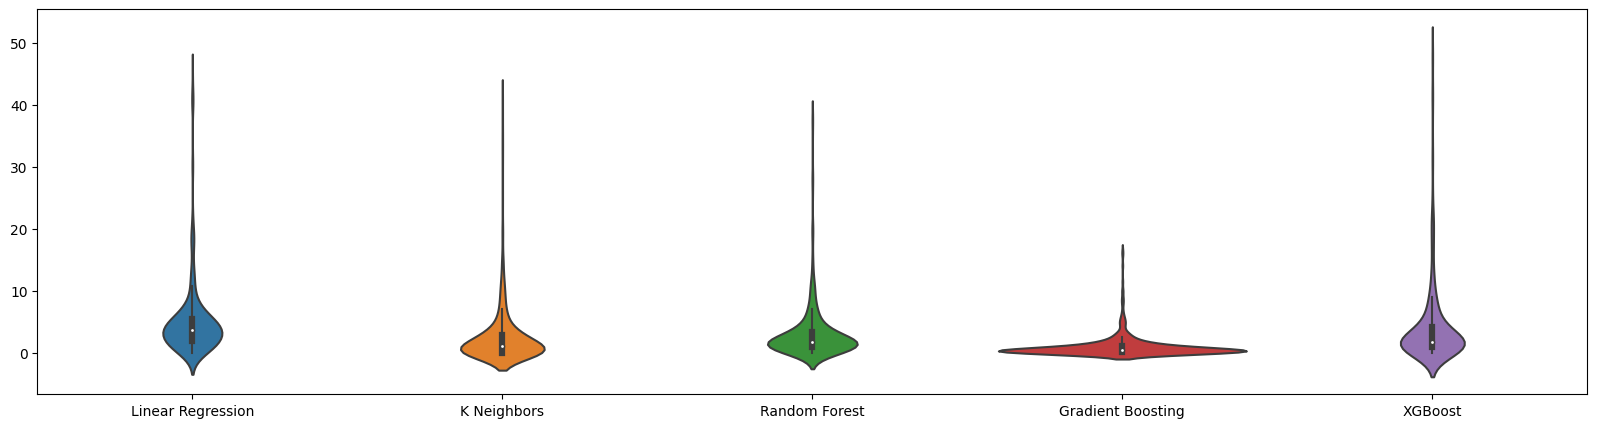

Test


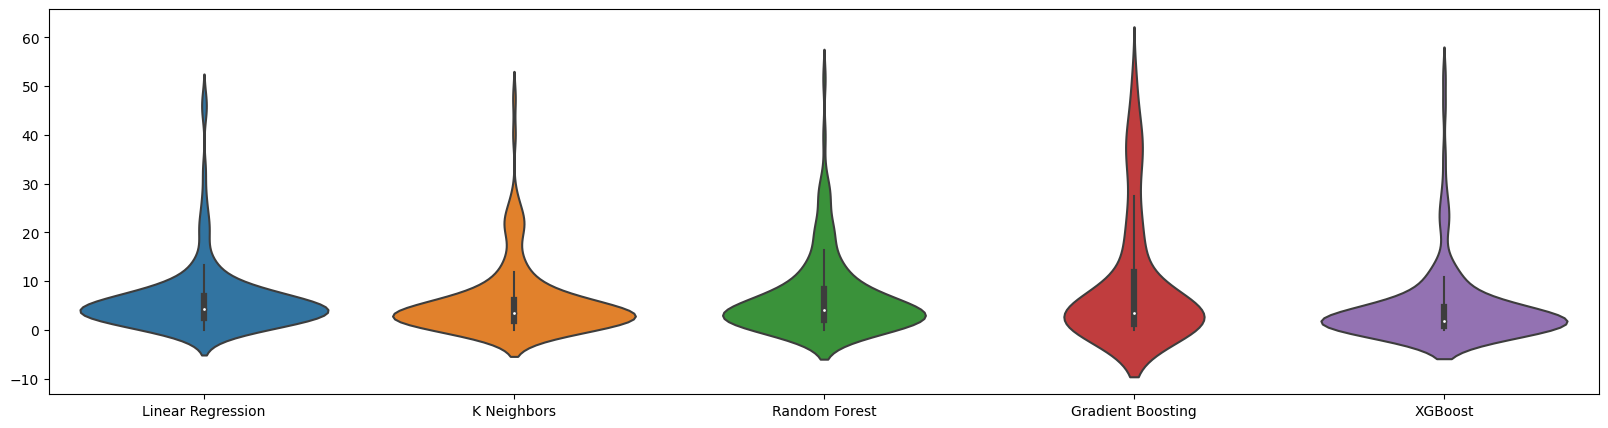

In [93]:
# Get Output variables
hopt = df_baseline_hopt[['hopt (%)']]
y_hopt = hopt.to_numpy()[:,0]

# Get the Input variables
df_input = df_baseline_hopt.drop(['hopt (%)'])
X = df_input.to_numpy()

## hopt
print(f'hopt')
models_hopt_baseline = compute_performance(models, X, y_hopt)

### Baseline + QY

In [94]:
df_02_PCE = df.drop(['mat0', 'mat1', 'hopt (%)']).drop_nulls()
print_missing_samples(df_02_PCE)

Shape: (112, 8)
abs_peak: 0%
abs_min: 0%
abs_max: 0%
em_peak: 0%
em_min: 0%
em_max: 0%
QY (%): 0%
PCE (%): 0%


In [95]:
df_02_hopt = df.drop(['mat0', 'mat1', 'PCE (%)']).drop_nulls()
print_missing_samples(df_02_hopt)

Shape: (129, 8)
abs_peak: 0%
abs_min: 0%
abs_max: 0%
em_peak: 0%
em_min: 0%
em_max: 0%
QY (%): 0%
hopt (%): 0%


PCE
Train
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   1.47 |   4.15 |   0.14 |
| K Neighbors       |   0.13 |   0.16 |   0.97 |
| Random Forest     |   0.81 |   1.95 |   0.59 |
| Gradient Boosting |   0.27 |    0.3 |   0.94 |
| XGBoost           |   1.02 |   2.77 |   0.41 |

Test
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   1.73 |    5.5 |  -0.32 |
| K Neighbors       |   1.41 |    4.4 |  -0.07 |
| Random Forest     |   1.58 |   4.89 |  -0.33 |
| Gradient Boosting |   1.63 |   5.75 |  -0.72 |
| XGBoost           |   1.63 |   6.02 |  -0.57 |

Train


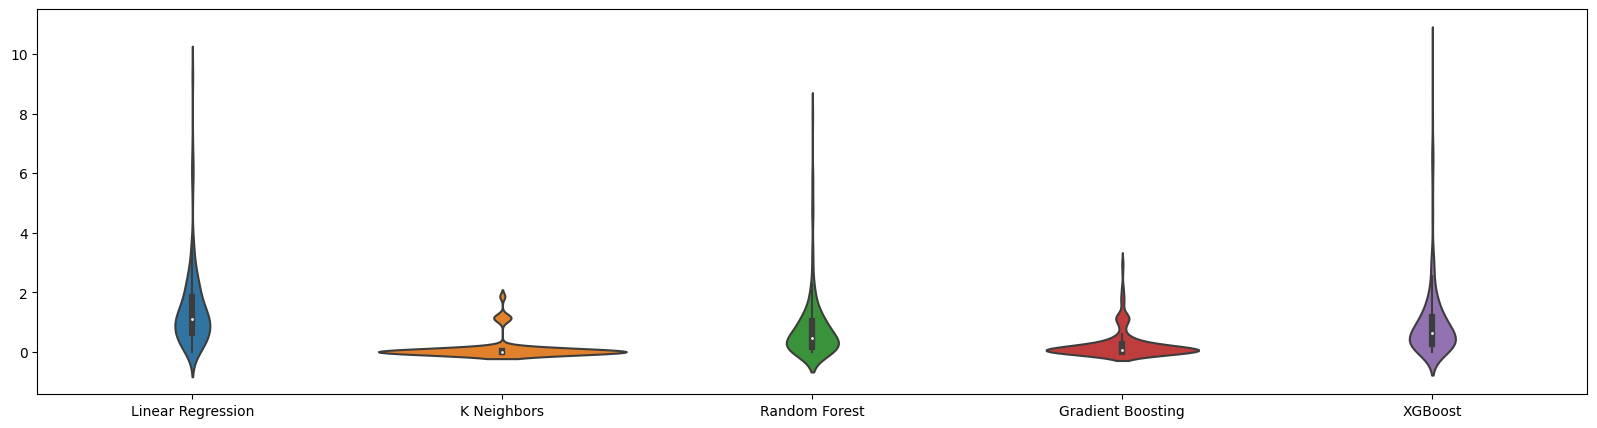

Test


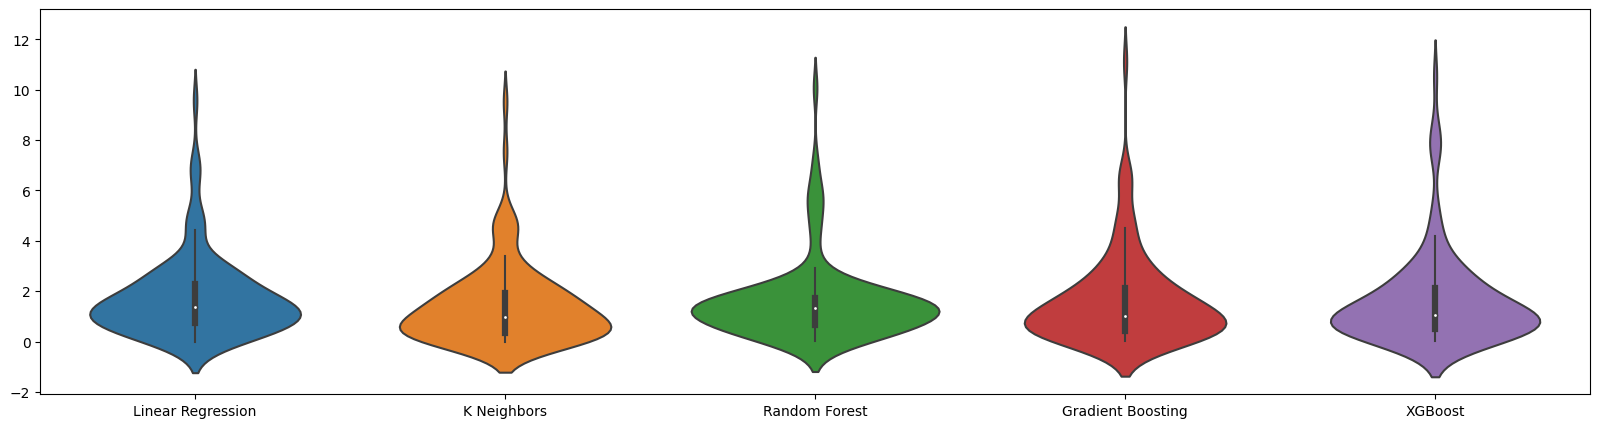

In [96]:
# Get Output variables
PCE = df_02_PCE[['PCE (%)']]
y_PCE = PCE.to_numpy()[:,0]

# Get the Input variables
df_input = df_02_PCE.drop(['PCE (%)'])
X = df_input.to_numpy()

## PCE
print(f'PCE')
models_02_pce = compute_performance(models, X, y_PCE)

hopt
Train
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   5.21 |  60.59 |   0.21 |
| K Neighbors       |   3.84 |  39.53 |   0.48 |
| Random Forest     |    3.5 |  37.78 |   0.51 |
| Gradient Boosting |   0.56 |   2.21 |   0.97 |
| XGBoost           |    3.4 |  37.91 |   0.48 |

Test
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   6.26 |  87.41 |   -2.2 |
| K Neighbors       |   5.95 |  95.21 |  -1.63 |
| Random Forest     |   5.54 |  79.28 |  -1.81 |
| Gradient Boosting |   6.53 | 116.83 |  -5.12 |
| XGBoost           |   5.15 |  89.34 |  -0.91 |

Train


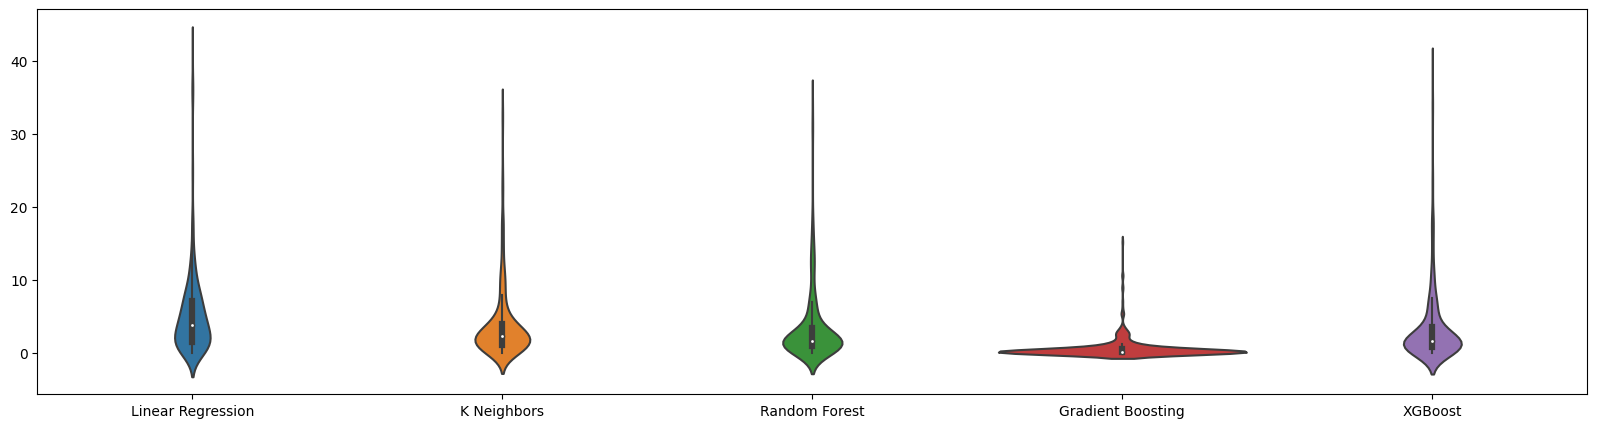

Test


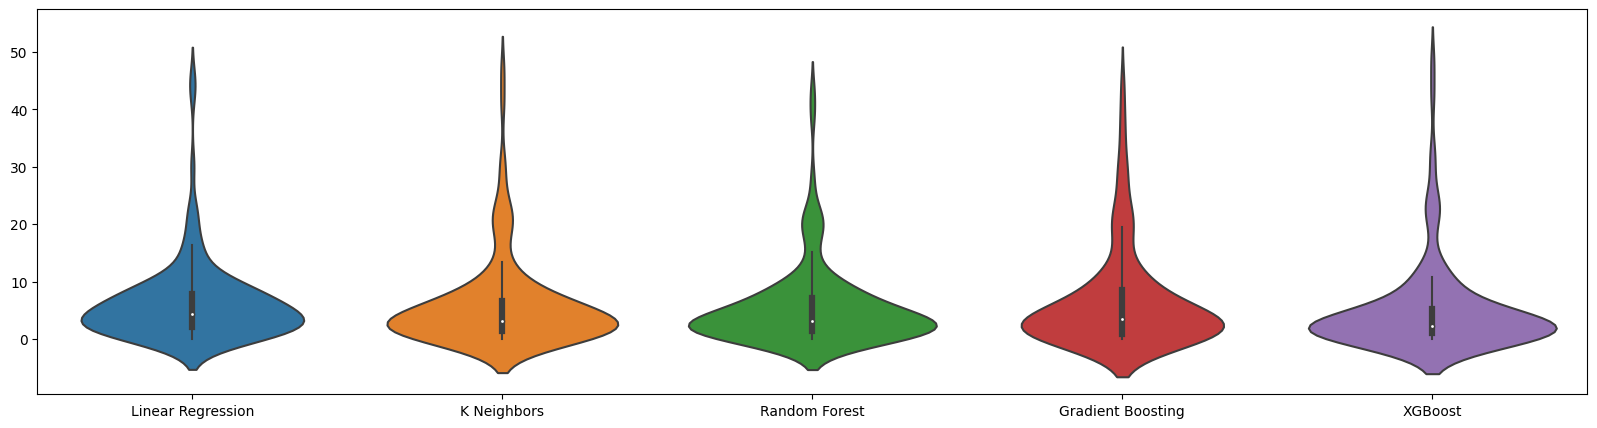

In [97]:
# Get Output variables
hopt = df_02_hopt[['hopt (%)']]
y_hopt = hopt.to_numpy()[:,0]

# Get the Input variables
df_input = df_02_hopt.drop(['hopt (%)'])
X = df_input.to_numpy()

## hopt
print(f'hopt')
models_02_hopt = compute_performance(models, X, y_hopt)

### Baseline + QY + Categorical (Mat0 and Mat1)

In [98]:
df_03_PCE = df.drop(['hopt (%)']).drop_nulls()
print_missing_samples(df_03_PCE)

Shape: (112, 10)
mat0  : 0%
mat1  : 0%
abs_peak: 0%
abs_min: 0%
abs_max: 0%
em_peak: 0%
em_min: 0%
em_max: 0%
QY (%): 0%
PCE (%): 0%


In [99]:
df_03_hopt = df.drop(['PCE (%)']).drop_nulls()
print_missing_samples(df_03_hopt)

Shape: (129, 10)
mat0  : 0%
mat1  : 0%
abs_peak: 0%
abs_min: 0%
abs_max: 0%
em_peak: 0%
em_min: 0%
em_max: 0%
QY (%): 0%
hopt (%): 0%


PCE
Train
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   1.16 |   3.12 |   0.35 |
| K Neighbors       |   0.44 |   1.17 |   0.76 |
| Random Forest     |   0.83 |   1.87 |   0.61 |
| Gradient Boosting |   0.26 |   0.27 |   0.94 |
| XGBoost           |   1.04 |   2.94 |   0.38 |

Test
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   1.48 |   4.61 |  -0.28 |
| K Neighbors       |   1.28 |    4.7 |   -0.2 |
| Random Forest     |   1.58 |   5.03 |  -0.37 |
| Gradient Boosting |   1.75 |   8.43 |  -1.37 |
| XGBoost           |   1.63 |   6.05 |  -0.56 |

Train


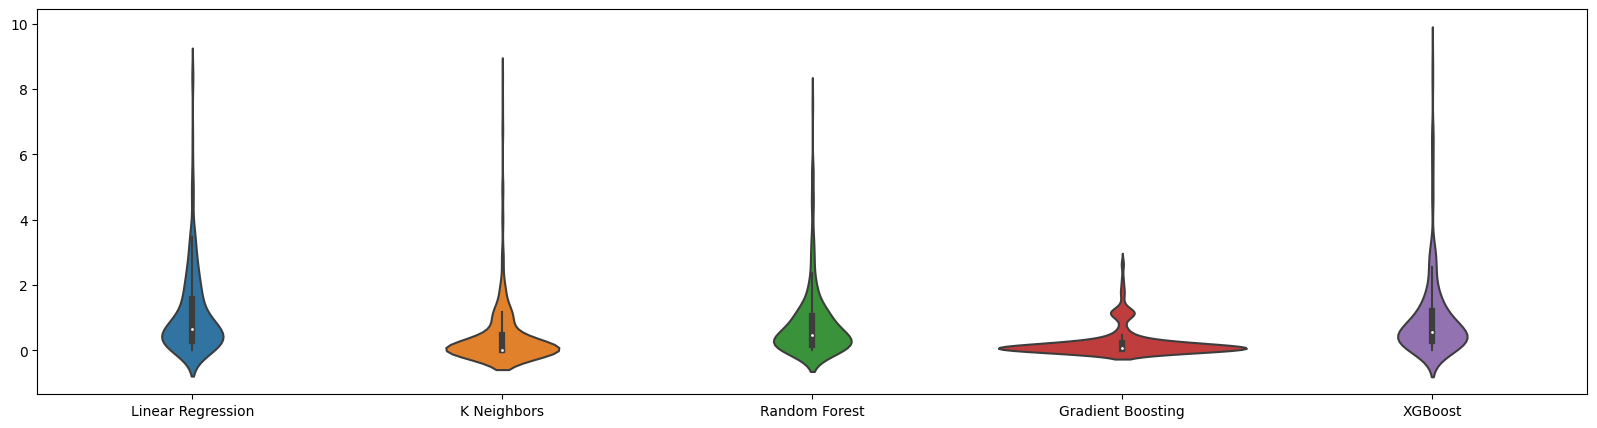

Test


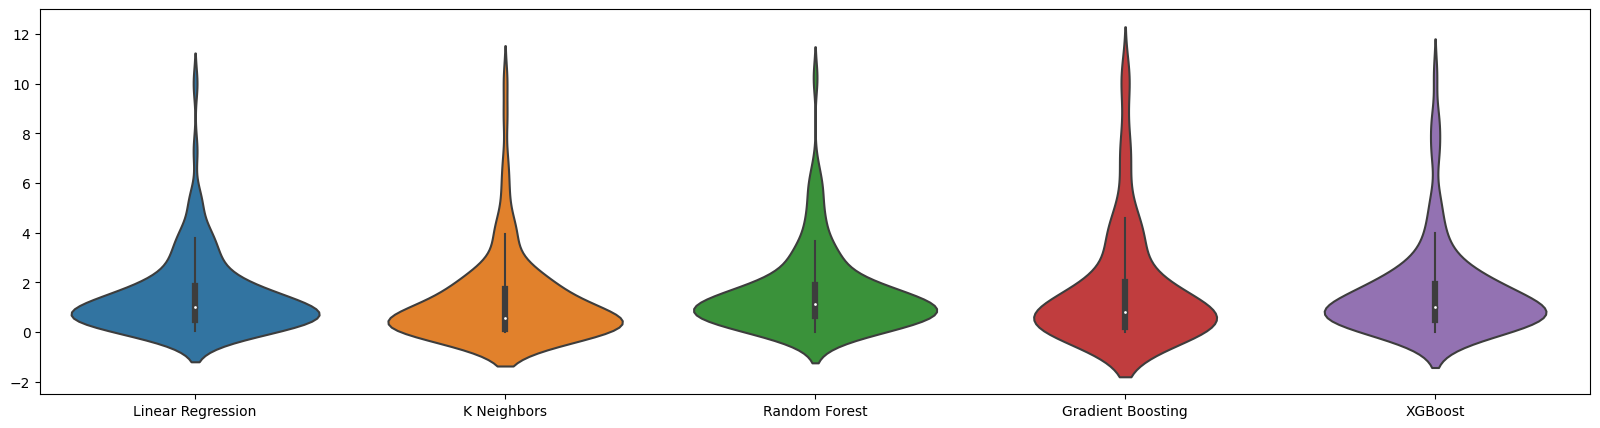

In [100]:
# Get Output variables
PCE = df_03_PCE[['PCE (%)']]
y_PCE = PCE.to_numpy()[:,0]

# Get the Input variables
df_input = df_03_PCE.drop(['mat0', 'mat1', 'PCE (%)'])
X = df_input.to_numpy()

temp_mat0 = df_03_PCE[['mat0']].to_numpy()
enc = OneHotEncoder(min_frequency=10, sparse_output=False)
encoded_mat0 = enc.fit_transform(temp_mat0)

temp_mat1 = df_03_PCE[['mat1']].to_numpy()
enc = OneHotEncoder(min_frequency=20, sparse_output=False)
encoded_mat1 = enc.fit_transform(temp_mat1)

X = np.concatenate((encoded_mat0, encoded_mat1, X), axis=1)

## PCE
print(f'PCE')
models_03_pce = compute_performance(models, X, y_PCE)

hopt
Train
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   4.57 |  44.69 |   0.41 |
| K Neighbors       |   0.82 |   5.44 |   0.87 |
| Random Forest     |   2.63 |  22.41 |   0.71 |
| Gradient Boosting |   0.61 |   1.81 |   0.97 |
| XGBoost           |   3.08 |  27.36 |   0.61 |

Test
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   6.47 |  89.87 |   -3.1 |
| K Neighbors       |    5.2 |  66.39 |  -1.23 |
| Random Forest     |   5.03 |  65.02 |  -1.67 |
| Gradient Boosting |   4.93 |  66.47 |  -3.23 |
| XGBoost           |   4.68 |  69.54 |  -0.88 |

Train


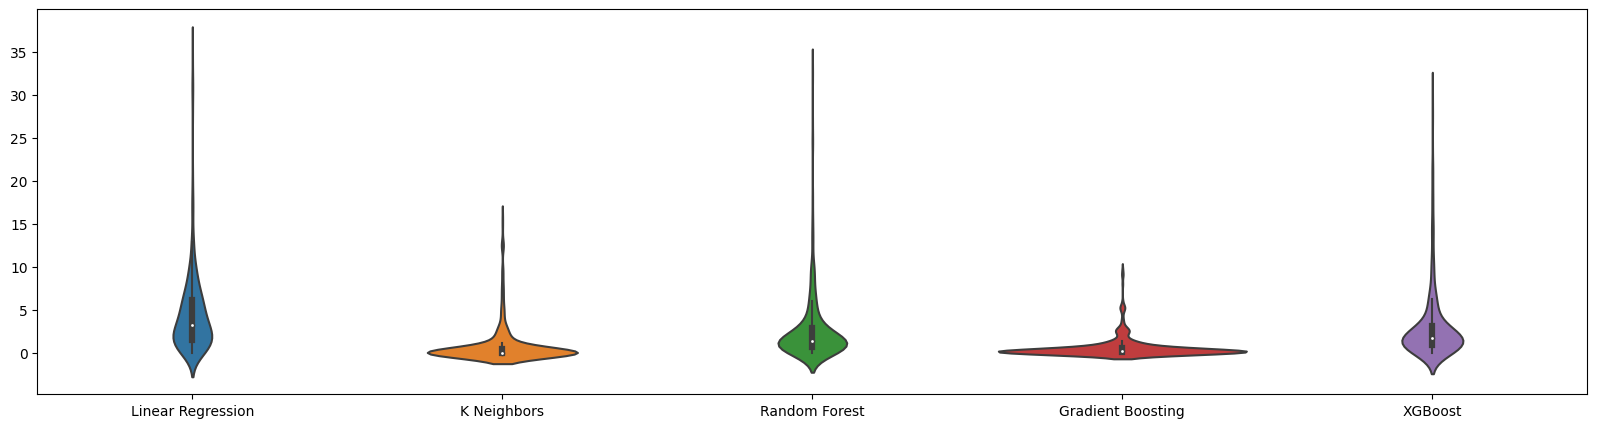

Test


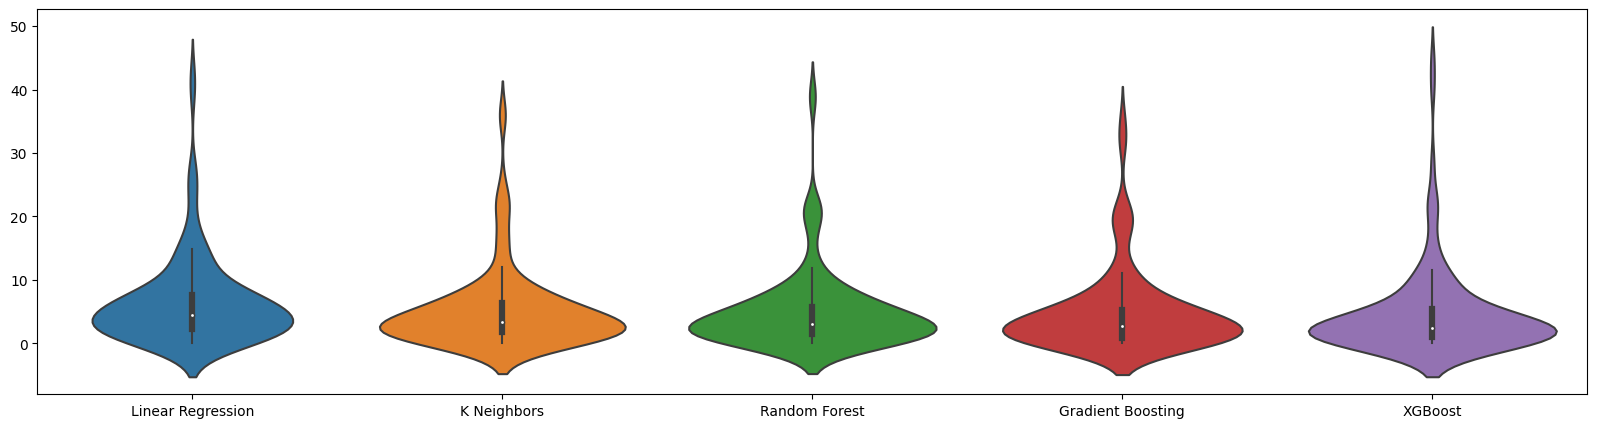

In [101]:
# Get Output variables
hopt = df_03_hopt[['hopt (%)']]
y_hopt = hopt.to_numpy()[:,0]

# Get the Input variables
df_input = df_03_hopt.drop(['mat0', 'mat1', 'hopt (%)'])
X = df_input.to_numpy()

temp_mat0 = df_03_hopt[['mat0']].to_numpy()
enc = OneHotEncoder(min_frequency=10, sparse_output=False)
encoded_mat0 = enc.fit_transform(temp_mat0)

temp_mat1 = df_03_hopt[['mat1']].to_numpy()
enc = OneHotEncoder(min_frequency=20, sparse_output=False)
encoded_mat1 = enc.fit_transform(temp_mat1)

X = np.concatenate((encoded_mat0, encoded_mat1, X), axis=1)

## hopt
print(f'hopt')
models_03_hopt = compute_performance(models, X, y_hopt)

## Outlier removal

In [31]:
def iqr_range(array):
    Q1 = np.percentile(array, 25)
    Q3 = np.percentile(array, 75)
    IQR = Q3 - Q1
    return ((Q1 - 1.5 * IQR),(Q3 + 1.5 * IQR))

In [32]:
PCE_array = df[['PCE (%)']].drop_nulls().to_numpy()[:,0]
#PCE_array
pce_low, pce_high = iqr_range(PCE_array)
print(f'PCE [{pce_low}, {pce_high}]')

PCE [-4.000000000000001, 6.912000000000001]


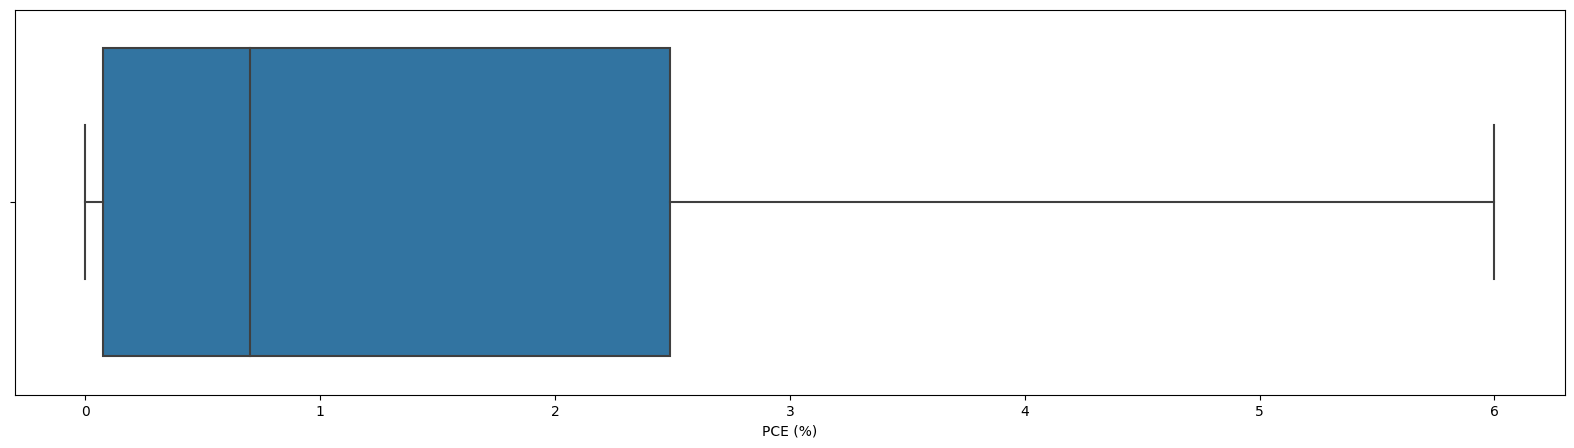

PCE: (121, 11)


In [33]:
df_filtered_PCE = df.filter((pl.col('PCE (%)') > pce_low) & (pl.col('PCE (%)') < pce_high))
sns.boxplot(data=df_filtered_PCE.to_pandas(), x='PCE (%)')
plt.show()
print(f'PCE: {df_filtered_PCE.shape}')

In [34]:
hopt_array = df[['hopt (%)']].drop_nulls().to_numpy()[:,0]
#hopt_array
hopt_low, hopt_high = iqr_range(hopt_array)
print(f'hopt [{hopt_low}, {hopt_high}]')

hopt [-6.99875, 15.63125]


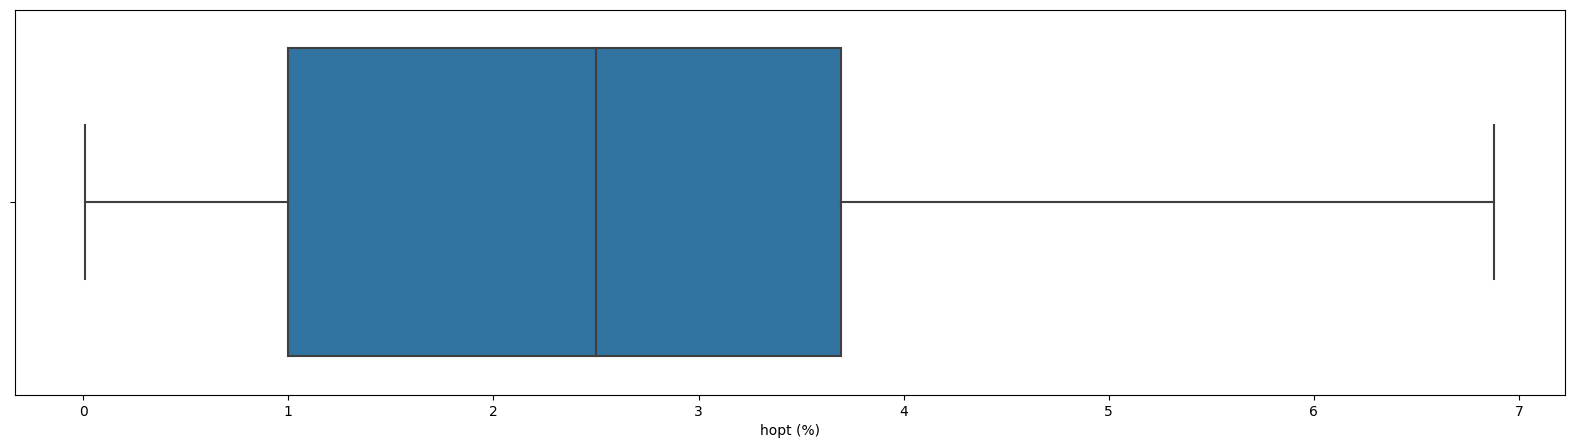

nhop: (106, 11)


In [35]:
df_filtered_hopt = df.filter((pl.col('hopt (%)') > pce_low) & (pl.col('hopt (%)') < pce_high))
sns.boxplot(data=df_filtered_hopt.to_pandas(), x='hopt (%)')
plt.show()
print(f'nhop: {df_filtered_hopt.shape}')

### PCE and hopt baselines

In [36]:
#models_gbr = [('Gradient Boosting Regressor', GradientBoostingRegressor(random_state=42),
#{'n_estimators':[50, 100, 150],'min_samples_split':[2, 5, 10], 'min_samples_leaf':[1, 2, 4],'max_depth':max_depth})]

In [37]:
df_out_baseline_PCE = df_filtered_PCE.drop(['mat0', 'mat1', 'QY (%)', 'hopt (%)']).drop_nulls()
print_missing_samples(df_out_baseline_PCE)

Shape: (121, 7)
abs_peak: 0%
abs_min: 0%
abs_max: 0%
em_peak: 0%
em_min: 0%
em_max: 0%
PCE (%): 0%


PCE
Train
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |    1.1 |   1.84 |   0.21 |
| K Neighbors       |    0.1 |   0.12 |   0.95 |
| Random Forest     |   0.36 |    0.3 |   0.87 |
| Gradient Boosting |   0.17 |   0.14 |   0.94 |
| XGBoost           |   0.56 |   0.64 |   0.72 |

Test
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   1.55 |   3.74 |  -0.61 |
| K Neighbors       |   1.04 |   2.04 |   0.11 |
| Random Forest     |   1.06 |   1.95 |   0.15 |
| Gradient Boosting |   1.04 |   2.23 |   0.03 |
| XGBoost           |   1.05 |   1.94 |   0.16 |

Train


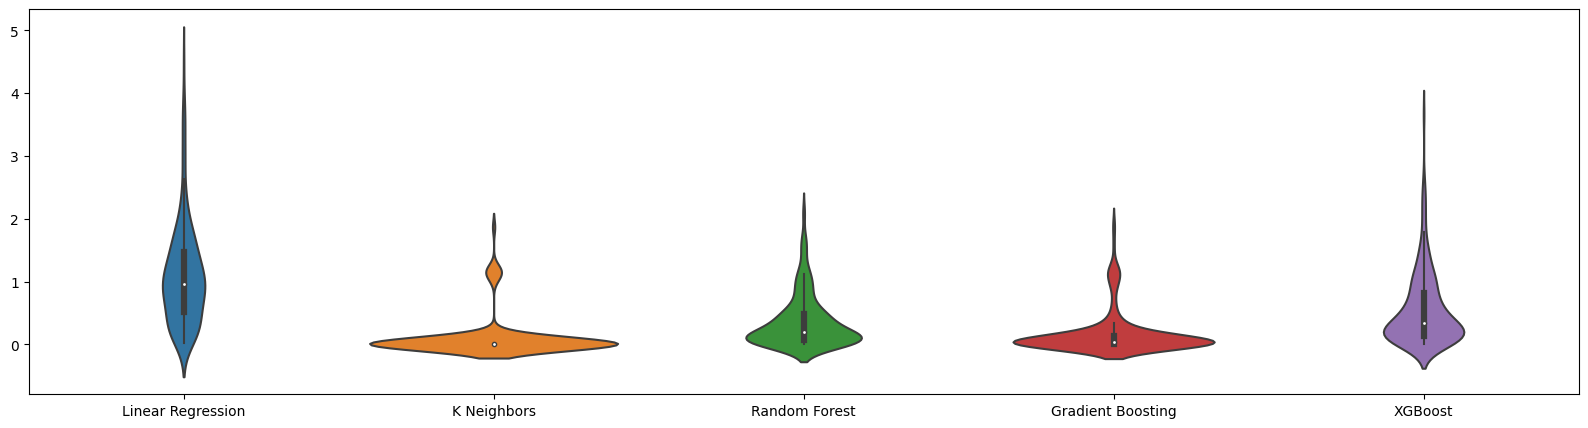

Test


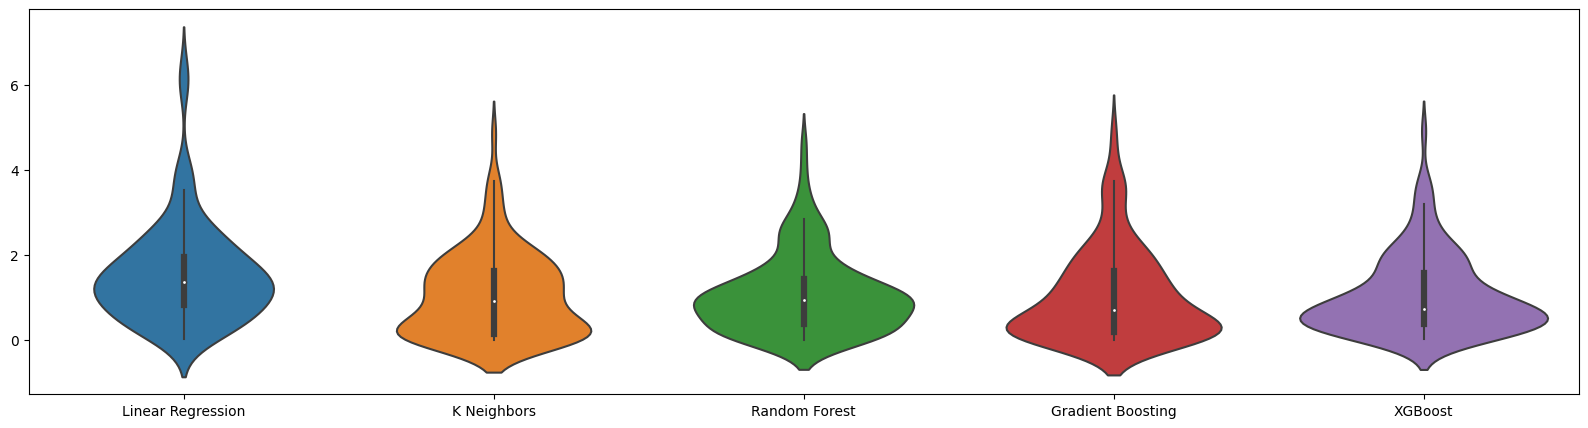

In [38]:
# Get Output variables
PCE = df_out_baseline_PCE[['PCE (%)']]
y_PCE = PCE.to_numpy()[:,0]

# Get the Input variables
df_input = df_out_baseline_PCE.drop(['PCE (%)'])
X = df_input.to_numpy()

## PCE
print(f'PCE')
models_out_pce_baseline = compute_performance(models, X, y_PCE)

In [110]:
df_out_baseline_hopt = df_filtered_hopt.drop(['mat0', 'mat1', 'QY (%)', 'PCE (%)']).drop_nulls()
print_missing_samples(df_out_baseline_hopt)

Shape: (106, 7)
abs_peak: 0%
abs_min: 0%
abs_max: 0%
em_peak: 0%
em_min: 0%
em_max: 0%
hopt (%): 0%


hopt
Train
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   1.41 |   3.03 |   0.07 |
| K Neighbors       |   0.61 |   1.15 |   0.66 |
| Random Forest     |   0.98 |   1.45 |   0.55 |
| Gradient Boosting |   0.34 |   0.23 |   0.93 |
| XGBoost           |    1.2 |   2.21 |   0.32 |

Test
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   1.77 |   5.76 |  -0.65 |
| K Neighbors       |   1.59 |   3.72 |  -0.22 |
| Random Forest     |   1.59 |   3.81 |  -0.19 |
| Gradient Boosting |   1.85 |   5.21 |   -0.6 |
| XGBoost           |   1.57 |    3.9 |  -0.25 |

Train


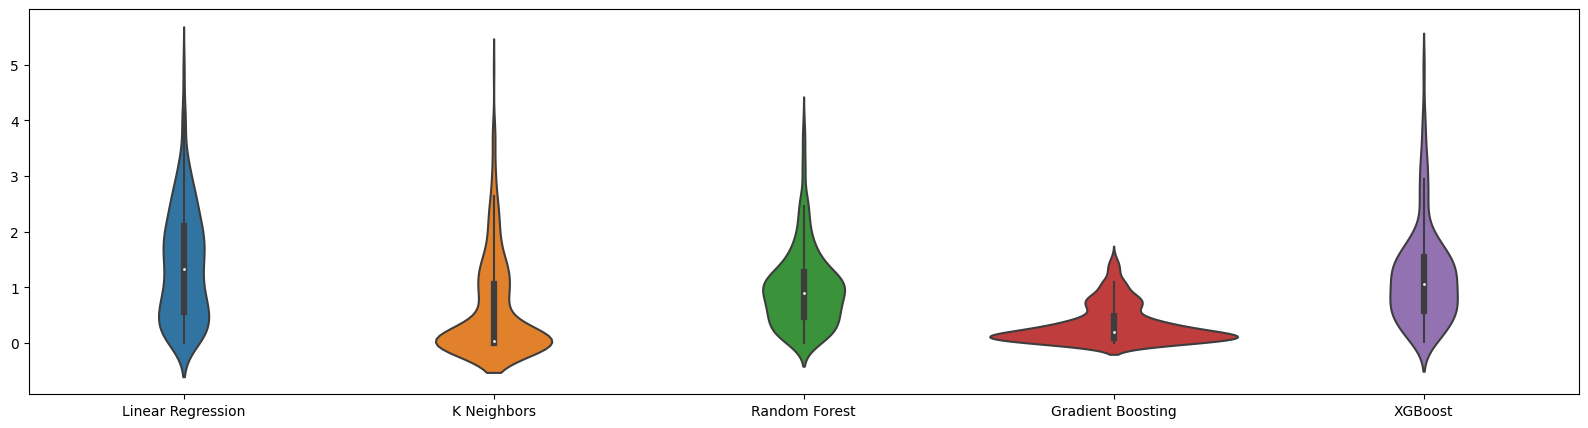

Test


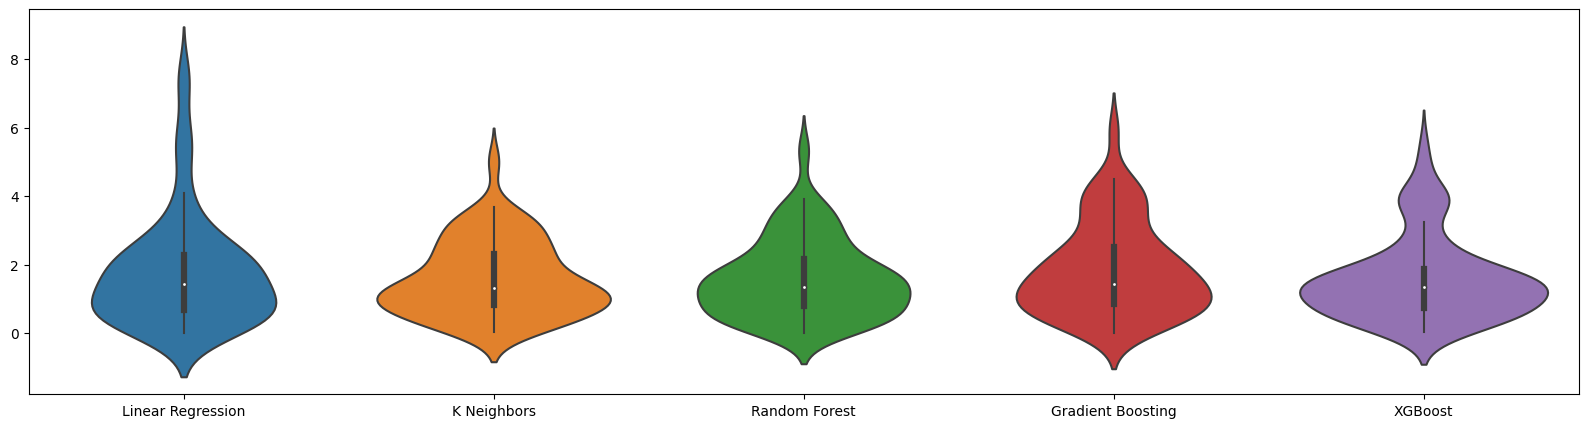

In [111]:
# Get Output variables
hopt = df_out_baseline_hopt[['hopt (%)']]
y_hopt = hopt.to_numpy()[:,0]

# Get the Input variables
df_input = df_out_baseline_hopt.drop(['hopt (%)'])
X = df_input.to_numpy()

## hopt
print(f'hopt')
models_out_hopt_baseline = compute_performance(models, X, y_hopt)

### Baseline + QY

In [112]:
df_out_02_PCE = df_filtered_PCE.drop(['mat0', 'mat1', 'hopt (%)']).drop_nulls()
print_missing_samples(df_out_02_PCE)

Shape: (107, 8)
abs_peak: 0%
abs_min: 0%
abs_max: 0%
em_peak: 0%
em_min: 0%
em_max: 0%
QY (%): 0%
PCE (%): 0%


In [113]:
df_out_02_hopt = df_filtered_hopt.drop(['mat0', 'mat1', 'PCE (%)']).drop_nulls()
print_missing_samples(df_out_02_hopt)

Shape: (95, 8)
abs_peak: 0%
abs_min: 0%
abs_max: 0%
em_peak: 0%
em_min: 0%
em_max: 0%
QY (%): 0%
hopt (%): 0%


PCE
Train
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   1.09 |   1.85 |   0.15 |
| K Neighbors       |   0.13 |   0.16 |   0.92 |
| Random Forest     |   0.46 |    0.5 |   0.77 |
| Gradient Boosting |    0.2 |   0.19 |   0.91 |
| XGBoost           |   0.57 |   0.79 |   0.64 |

Test
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   1.37 |   3.07 |  -0.51 |
| K Neighbors       |   1.06 |   2.12 |   0.02 |
| Random Forest     |   1.06 |   2.23 |  -0.05 |
| Gradient Boosting |   0.98 |   2.28 |  -0.06 |
| XGBoost           |   1.09 |   2.25 |   -0.1 |

Train


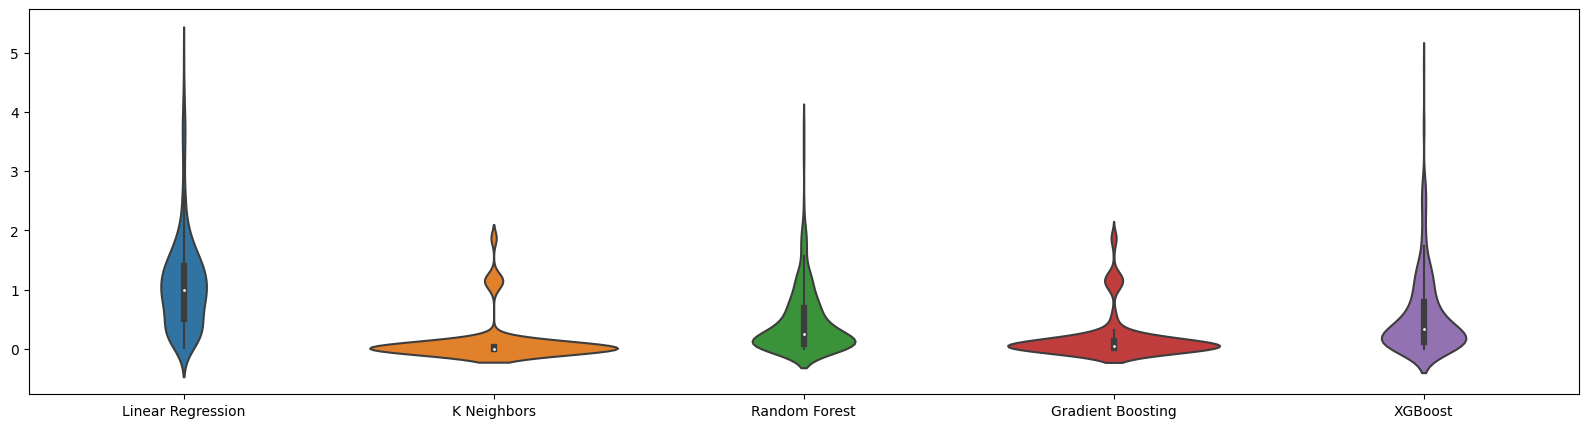

Test


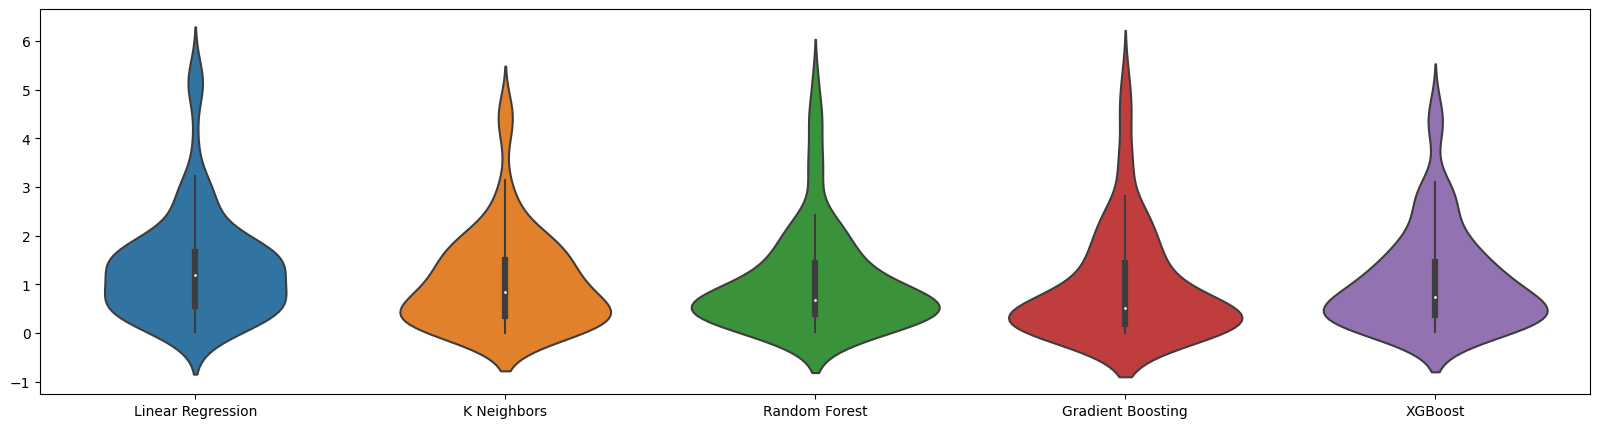

In [114]:
# Get Output variables
PCE = df_out_02_PCE[['PCE (%)']]
y_PCE = PCE.to_numpy()[:,0]

# Get the Input variables
df_input = df_out_02_PCE.drop(['PCE (%)'])
X = df_input.to_numpy()

## PCE
print(f'PCE')
models_out_02_pce = compute_performance(models, X, y_PCE)

hopt
Train
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   1.41 |   3.03 |   0.08 |
| K Neighbors       |   0.56 |   1.04 |   0.68 |
| Random Forest     |   0.84 |   1.09 |   0.67 |
| Gradient Boosting |   0.21 |   0.14 |   0.96 |
| XGBoost           |   0.88 |   1.44 |   0.56 |

Test
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   2.02 |   7.67 |  -1.26 |
| K Neighbors       |   1.54 |   3.64 |  -0.26 |
| Random Forest     |   1.53 |   3.85 |  -0.25 |
| Gradient Boosting |   1.51 |   3.94 |  -0.29 |
| XGBoost           |   1.63 |    4.2 |  -0.45 |

Train


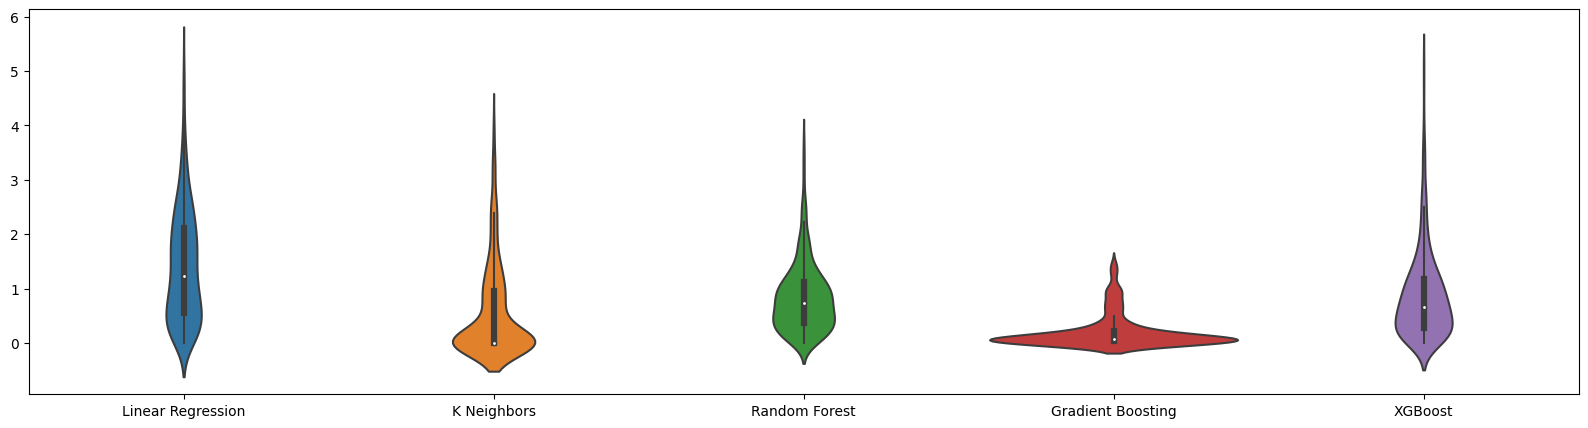

Test


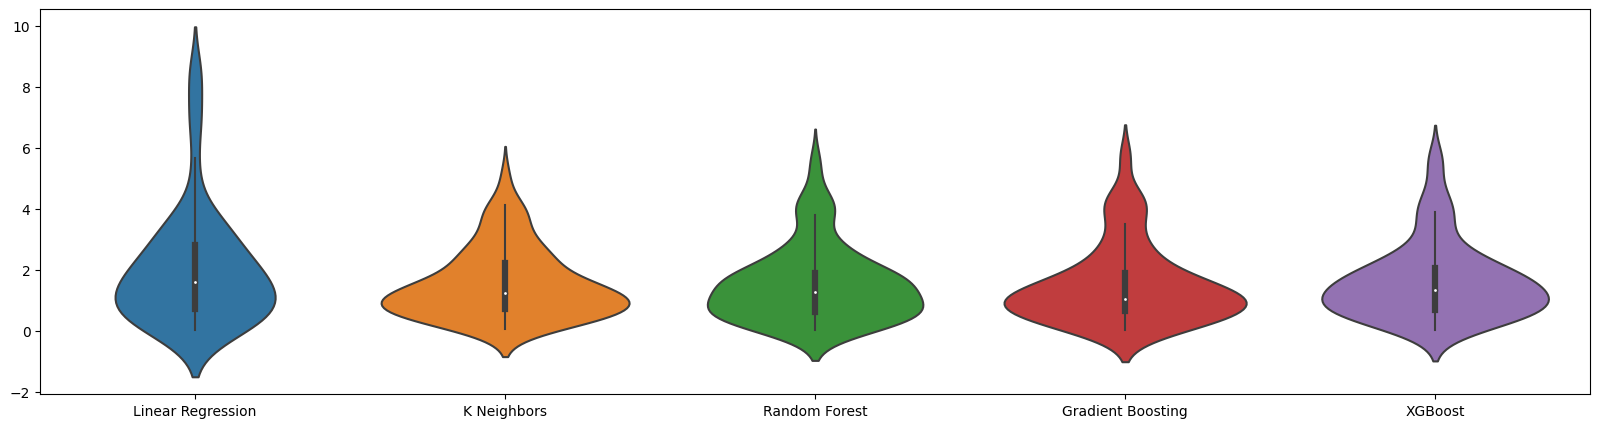

In [115]:
# Get Output variables
hopt = df_out_02_hopt[['hopt (%)']]
y_hopt = hopt.to_numpy()[:,0]

# Get the Input variables
df_input = df_out_02_hopt.drop(['hopt (%)'])
X = df_input.to_numpy()

## hopt
print(f'hopt')
models_out_02_hopt = compute_performance(models, X, y_hopt)

### Baseline + QY + Categorical (Mat0 and Mat1)

In [116]:
df_out_03_PCE = df_filtered_PCE.drop(['hopt (%)']).drop_nulls()
print_missing_samples(df_out_03_PCE)

Shape: (107, 10)
mat0  : 0%
mat1  : 0%
abs_peak: 0%
abs_min: 0%
abs_max: 0%
em_peak: 0%
em_min: 0%
em_max: 0%
QY (%): 0%
PCE (%): 0%


In [117]:
df_out_03_hopt = df_filtered_hopt.drop(['PCE (%)']).drop_nulls()
print_missing_samples(df_out_03_hopt)

Shape: (95, 10)
mat0  : 0%
mat1  : 0%
abs_peak: 0%
abs_min: 0%
abs_max: 0%
em_peak: 0%
em_min: 0%
em_max: 0%
QY (%): 0%
hopt (%): 0%


PCE
Train
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   0.78 |    1.1 |   0.49 |
| K Neighbors       |   0.13 |   0.16 |   0.92 |
| Random Forest     |   0.38 |   0.37 |   0.83 |
| Gradient Boosting |   0.16 |   0.17 |   0.92 |
| XGBoost           |   0.37 |   0.47 |   0.78 |

Test
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   1.17 |    2.3 |  -0.17 |
| K Neighbors       |   0.84 |   1.58 |   0.25 |
| Random Forest     |   1.05 |   2.21 |  -0.07 |
| Gradient Boosting |   1.09 |   2.64 |   -0.3 |
| XGBoost           |   0.96 |    2.2 |  -0.09 |

Train


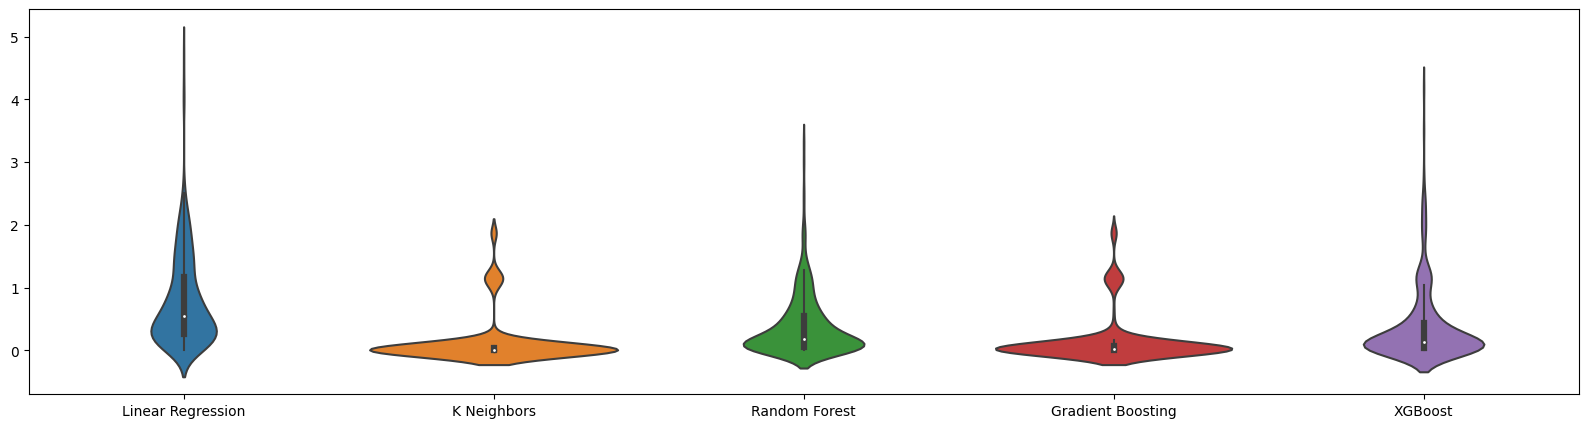

Test


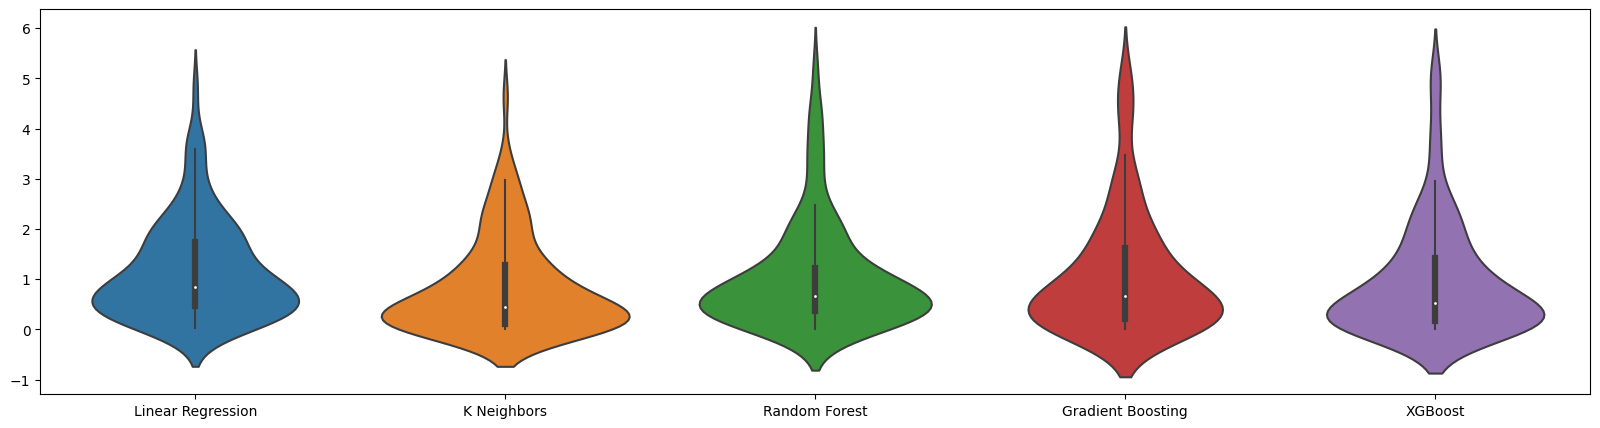

In [118]:
# Get Output variables
PCE = df_out_03_PCE[['PCE (%)']]
y_PCE = PCE.to_numpy()[:,0]

# Get the Input variables
df_input = df_out_03_PCE.drop(['mat0', 'mat1', 'PCE (%)'])
X = df_input.to_numpy()

temp_mat0 = df_out_03_PCE[['mat0']].to_numpy()
enc = OneHotEncoder(min_frequency=10, sparse_output=False)
encoded_mat0 = enc.fit_transform(temp_mat0)

temp_mat1 = df_out_03_PCE[['mat1']].to_numpy()
enc = OneHotEncoder(min_frequency=20, sparse_output=False)
encoded_mat1 = enc.fit_transform(temp_mat1)

X = np.concatenate((encoded_mat0, encoded_mat1, X), axis=1)

## PCE
print(f'PCE')
models_out_03_pce = compute_performance(models, X, y_PCE)

hopt
Train
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   1.33 |   2.71 |   0.18 |
| K Neighbors       |   0.31 |   0.52 |   0.84 |
| Random Forest     |   0.84 |    1.1 |   0.66 |
| Gradient Boosting |   0.18 |   0.12 |   0.96 |
| XGBoost           |   1.04 |   1.79 |   0.46 |

Test
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   2.02 |   7.51 |  -1.21 |
| K Neighbors       |   1.55 |   3.76 |  -0.33 |
| Random Forest     |   1.56 |   3.94 |  -0.26 |
| Gradient Boosting |   1.52 |   4.14 |  -0.35 |
| XGBoost           |   1.58 |   4.05 |   -0.4 |

Train


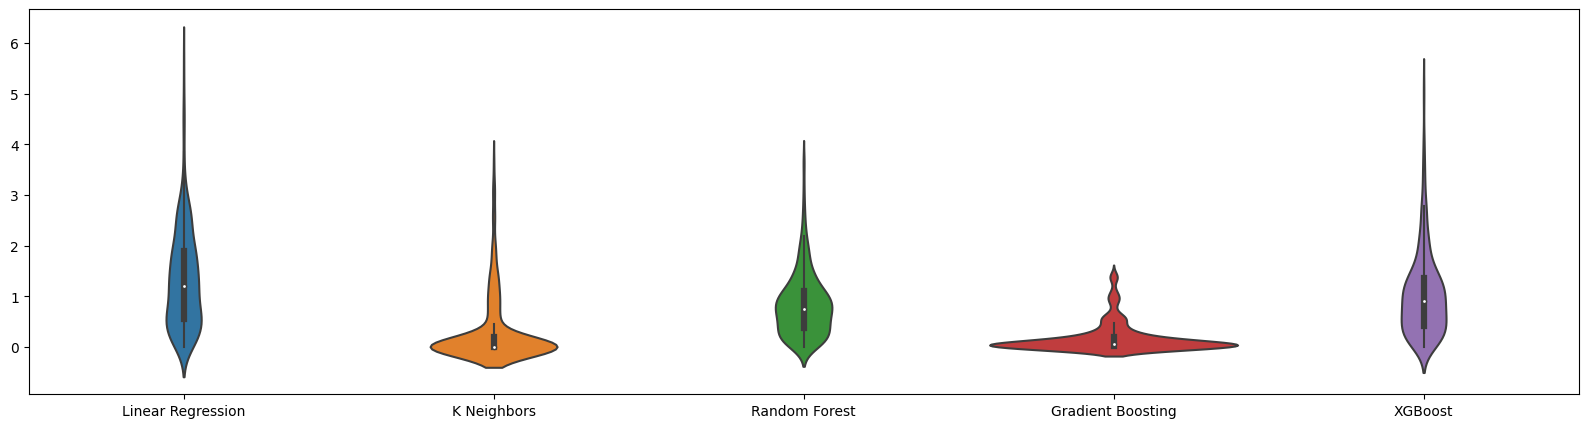

Test


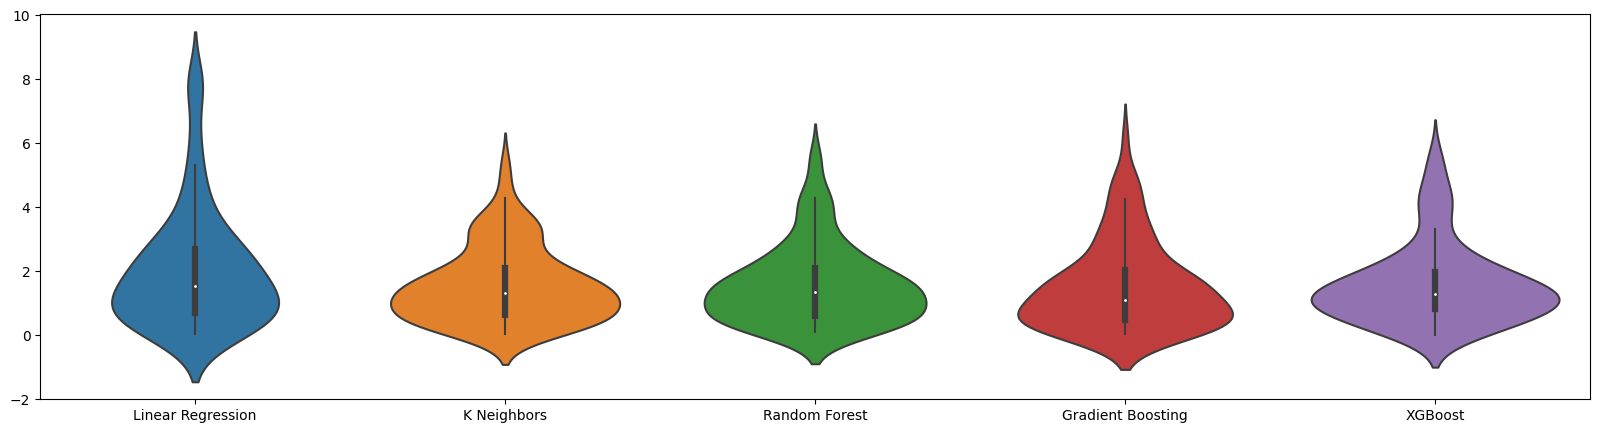

In [119]:
# Get Output variables
hopt = df_out_03_hopt[['hopt (%)']]
y_hopt = hopt.to_numpy()[:,0]

# Get the Input variables
df_input = df_out_03_hopt.drop(['mat0', 'mat1', 'hopt (%)'])
X = df_input.to_numpy()

temp_mat0 = df_out_03_hopt[['mat0']].to_numpy()
enc = OneHotEncoder(min_frequency=10, sparse_output=False)
encoded_mat0 = enc.fit_transform(temp_mat0)

temp_mat1 = df_out_03_hopt[['mat1']].to_numpy()
enc = OneHotEncoder(min_frequency=20, sparse_output=False)
encoded_mat1 = enc.fit_transform(temp_mat1)

X = np.concatenate((encoded_mat0, encoded_mat1, X), axis=1)

## PCE
print(f'hopt')
models_out_03_hopt = compute_performance(models, X, y_hopt)

## Clustering

In [147]:
df = pl.read_excel('db.xlsx')
#df = df.drop(['#'])
df_clustering_index = df.drop(['mat0', 'mat1', 'hopt (%)', 'PCE (%)'])
df_clustering_index = df_clustering_index.drop_nulls()
df_clustering = df_clustering_index.drop(['#'])
print_missing_samples(df_clustering)

Shape: (173, 7)
abs_peak: 0%
abs_min: 0%
abs_max: 0%
em_peak: 0%
em_min: 0%
em_max: 0%
QY (%): 0%


In [148]:
import sklearn.metrics as sklearn_metrics

def inertia_score(X, labels):
  """This is the same of scikit-learn's KMeans.inertia_, but it works also in case of only one label."""

  inertia = 0.0
  for label in set(labels):
    X_cluster = X[labels == label, :]
    centroid = np.mean(X_cluster, axis=0)
    inertia += np.sum((X_cluster - centroid) ** 2)
  return inertia


def calinski_harabasz_score(X, labels):
  """Wrapper function of Scikit-learn's calinski_harabasz_score. The only difference is it doesn't throw an error where there is only one label."""
  
  if len(set(labels)) == 1:
    return float("NaN")
  else:
    return sklearn_metrics.calinski_harabasz_score(X, labels)


def davies_bouldin_score(X, labels):
  """Wrapper function of Scikit-learn's davies_bouldin_score. The only difference is it doesn't throw an error where there is only one label."""
  
  if len(set(labels)) == 1:
    return float("NaN")
  else:
    return sklearn_metrics.davies_bouldin_score(X, labels)


def silhouette_score(X, labels):
  """Wrapper function of Scikit-learn's silhouette_score. The only difference is it doesn't throw an error where there is only one label."""
  
  if len(set(labels)) == 1:
    return float("NaN")
  else:
    return sklearn_metrics.silhouette_score(X, labels)


def get_bic_aic(k, X):
    gmm = GaussianMixture(n_components=k, init_params='kmeans')
    gmm.fit(X)
    return gmm.bic(X), gmm.aic(X)

In [149]:
# Cluster the materials without the hopt and PCE
X = df_clustering.to_numpy()
print(f'X = {X.shape}')

scores = {'elbow': [], 'calinski-harabasz': [], 'davies-bouldin': [], 'silhouette': [], 'bic': [], }

min_k = 2
max_k = 20

for k in range(min_k, max_k):
    kmeans = KMeans(n_clusters=k, max_iter=1000, n_init='auto', init='k-means++', random_state=5).fit(X)
    labels = kmeans.labels_
    scores['elbow'].append(inertia_score(X, labels))
    scores['calinski-harabasz'].append(calinski_harabasz_score(X, labels))
    scores['davies-bouldin'].append(davies_bouldin_score(X, labels))
    scores['silhouette'].append(silhouette_score(X, labels))
    bic, _ = get_bic_aic(k, X)
    scores['bic'].append(bic)

X = (173, 7)


In [150]:
x = range(min_k, max_k)
y = scores['elbow']

points = np.zeros((len(y),2))
points[:,0] = x
points[:,1] = y

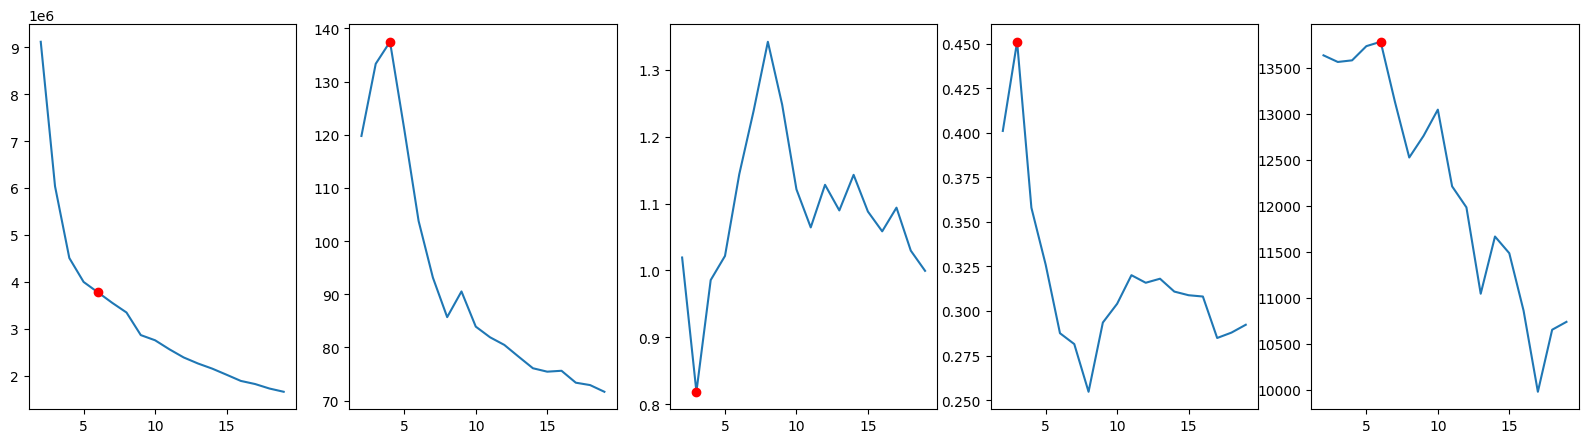

In [151]:
methods = ['elbow', 'calinski-harabasz', 'davies-bouldin', 'silhouette', 'bic']
fig, axs = plt.subplots(1, 5)

for i in range(len(methods)):
    method = methods[i]
    
    axs[i].plot(range(min_k, max_k), scores[method])
    if method == 'elbow':
        idx = kneedle.auto_knee(points)
    elif method == 'calinski-harabasz':
        idx = scores[method].index(max(scores[method]))
        #axs[i].plot(x[idx], scores[method][idx], 'ro')
    elif method == 'davies-bouldin':
        idx = scores[method].index(min(scores[method]))
        #axs[i].plot(x[idx], scores[method][idx], 'ro')
    elif method == 'silhouette':
        idx = scores[method].index(max(scores[method]))
        #axs[i].plot(x[idx], scores[method][idx], 'ro')
    elif method == 'bic':
        idx = scores[method].index(max(scores[method]))
        #axs[i].plot(x[idx], scores[method][idx], 'ro')
    axs[i].plot(x[idx], scores[method][idx], 'ro')

In [152]:
def compute_avg_field_per_cluster(df_origin, df_clustering, labels, field='PCE (%)'):
    field_per_cluster = []
    min_k = min(labels)
    max_k = max(labels)
    #print(f'[{min_k}, {max_k}]')
    for k in range(min_k, max_k+1):
        mask = (labels == k)
        #print(f'k={k} = {mask} {mask.shape} {df.shape}')
        df_k = df_clustering.filter(mask)
        #print(f'{df_k}')
        cluster_labels = df_k['#'].to_list()
        #print(f'{cluster_labels}')
        filter_df = df_origin.filter(pl.col('#').is_in(cluster_labels))
        #print(filter_df)
        mean_field = filter_df[field].mean()
        field_per_cluster.append(mean_field)
    return field_per_cluster

def plot_stats_per_cluster(df_origin, df_clustering, labels):
    min_k = min(labels)
    max_k = max(labels)
    #print(f'[{min_k}, {max_k}]')
    for k in range(min_k, max_k+1):
        print(f'Cluster: {k}')
        mask = (labels == k)
        #print(f'k={k} = {mask} {mask.shape} {df.shape}')
        df_k = df_clustering.filter(mask)
        #print(f'{df_k}')
        cluster_labels = df_k['#'].to_list()
        #print(f'{cluster_labels}')
        filter_df = df_origin.filter(pl.col('#').is_in(cluster_labels))
        describe_variables(filter_df.drop(['#']))

def find_nearest(array, value):
    diff = np.sum(np.abs(array - value), axis=1)
    idx = diff.argmin()
    return idx

def find_nearest_df(df, df_origin, value, k, field):
    df_no_id = df.drop(['#'])
    array = df_no_id.to_numpy()
    diff = np.sum(np.abs(array - value), axis=1)
    idxs = []
    
    i = j = 0
    while i < k and j < len(diff):
        j += 1
        idx = diff.argmin()
        #print(f'Current idx {idx}')
        diff[idx] = float('inf')
        #print(f'{df_origin.row(idx, named=True)}')
        if df_origin.row(idx, named=True)[field] is not None:
            idxs.append(idx)
            i += 1
    
    idxs = [df.row(i, named=True)['#'] for i in idxs]
    return idxs

def get_missing(df, field):
    df_qy_not_null = df.filter(pl.col('QY (%)').is_not_null())
    missing_df = df_qy_not_null.filter(pl.col(field).is_null())
    missing = missing_df.drop(['#', 'mat0', 'mat1', 'hopt (%)', 'PCE (%)']).to_numpy()
    return missing
    #return missing_df
    #vector_df = missing_df.drop(['#', 'mat0', 'mat1', 'hopt (%)', 'PCE (%)'])
    #missing = vector_df.to_numpy()

def predict_field_clustering(df_origin, df_clustering, kmeans, k=3, field='PCE (%)'):
    labels = kmeans.labels_
    centroids  = kmeans.cluster_centers_
    #centroid_labels = [centroids[i] for i in labels]
    #print(f'{labels} {centroids}')
    
    missing = get_missing(df_origin, field)
    #missing = missing_df.drop(['#', 'mat0', 'mat1', 'hopt (%)', 'PCE (%)']).to_numpy()

    # for each missing point, find the closest cluster
    rv = []
    for row in missing:
        closest_cluster = find_nearest(centroids, row)
        # select the corresponding cluster
        mask = (labels == closest_cluster)
        df_k = df_clustering.filter(mask)
        temp_id = df_k['#'].to_list()
        df_origin_k = df_origin.filter(pl.col('#').is_in(temp_id))
        idxs = find_nearest_df(df_k, df_origin_k, row, k, field)
        filter_df = df_origin.filter(pl.col('#').is_in(idxs))
        # compute the average
        pce_k = filter_df[field].to_numpy()
        rv.append((np.mean(pce_k), np.median(pce_k)))
    return rv

def get_clusters_df(df_origin, df_clustering, labels):
    min_k = min(labels)
    max_k = max(labels)

    df_per_cluster = []

    for k in range(min_k, max_k+1):
        mask = (labels == k)
        #print(f'k={k} = {mask} {mask.shape} {df.shape}')
        df_k = df_clustering.filter(mask)
        #print(f'{df_k}')
        cluster_labels = df_k['#'].to_list()
        #print(f'{cluster_labels}')
        filter_df = df_origin.filter(pl.col('#').is_in(cluster_labels))
        #print(filter_df)
        #mean_field = filter_df[field].mean()
        #field_per_cluster.append(mean_field)
        df_per_cluster.append(filter_df)
    return df_per_cluster


def rmse(measured, truth):
    return np.linalg.norm(measured - truth) / np.sqrt(len(truth))

In [153]:
k=5
kmeans = KMeans(n_clusters=k, max_iter=1000, n_init='auto', init='k-means++', random_state=5).fit(X)
labels = kmeans.labels_

In [154]:
avg_pce_cluster = compute_avg_field_per_cluster(df, df_clustering_index, labels, field='PCE (%)')
print(f'Avg PCE cluster: {avg_pce_cluster}')
avg_hopt_cluster = compute_avg_field_per_cluster(df, df_clustering_index, labels, field='hopt (%)')
print(f'Avg hOPT cluster: {avg_hopt_cluster}')
predictions_pce = predict_field_clustering(df, df_clustering_index, kmeans, k=3, field='PCE (%)')
print(f'Predictions PCE: {predictions_pce}')
predictions_hopt = predict_field_clustering(df, df_clustering_index, kmeans, k=3, field='hopt (%)')
print(f'Predictions hOPT: {predictions_hopt}')

Avg PCE cluster: [1.7782352941176474, 2.208725, 0.9611066247880435, 2.3942907096774193, 0.5521064117647059]
Avg hOPT cluster: [3.1220000000000003, 9.250588235294117, 7.5371304347826085, 4.159564102564102, 5.469478260869565]
Predictions PCE: [(2.466666666666667, 2.9), (0.8433333333333334, 0.2), (1.9866666666666666, 1.96), (2.546666666666667, 2.9), (1.4166666666666667, 0.61), (0.7966666666666667, 0.61), (1.9217333333333333, 1.96), (0.07253333333333332, 0.0052), (1.96, 1.7), (5.4433333333333325, 4.29), (0.86, 0.2), (3.7266666666666666, 1.7), (2.63, 3.05), (2.9633333333333334, 2.94), (3.296666666666667, 3.1), (0.47333333333333333, 0.44), (0.47333333333333333, 0.44), (1.78, 1.7), (2.63, 3.05), (2.796666666666667, 2.39), (2.0033333333333334, 2.39), (1.0923333333333334, 0.77), (2.0366666666666666, 2.6), (0.11266666666666668, 0.117), (0.42333333333333334, 0.38), (2.42, 2.39), (1.7199666666666669, 2.3), (2.4, 1.96), (2.1672666666666665, 2.7), (1.7199666666666669, 2.3), (2.4, 1.96), (2.58, 1.94)

In [155]:
mean_k_preds_pce = [p[0] for p in predictions_pce]
median_k_preds_pce = [p[1] for p in predictions_pce]

mean_k_preds_hopt = [p[0] for p in predictions_hopt]
median_k_preds_hopt = [p[1] for p in predictions_hopt]

PCE
Model: Linear Regression
Mean


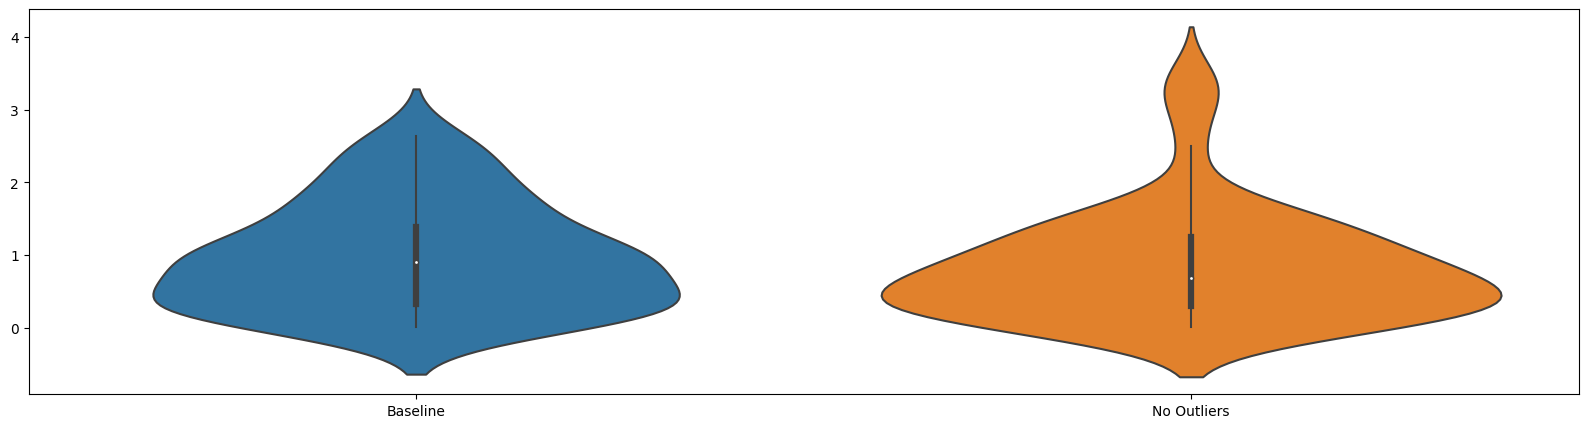

Median


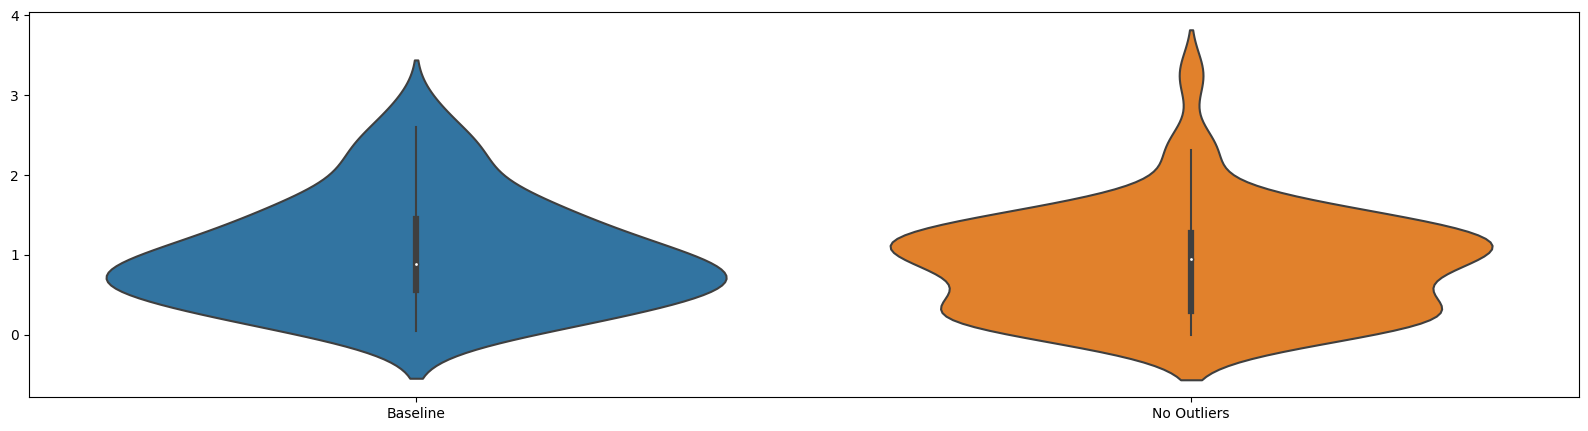

Baseline
|    Aggregation    |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Mean              |   0.97 |   1.47 |  -1.87 |
| Median            |   1.02 |   1.48 |  -1.89 |

No Outliers
|    Aggregation    |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Mean              |   0.84 |   1.29 |   0.03 |
| Median            |   0.89 |   1.19 |   0.09 |

Model: K Neighbors
Mean


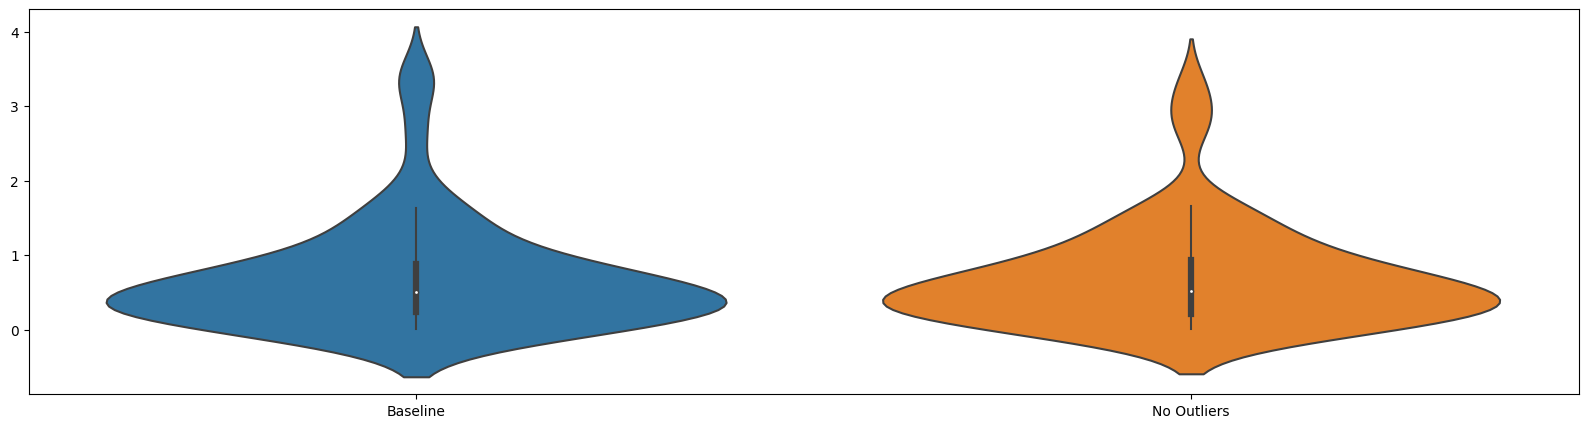

Median


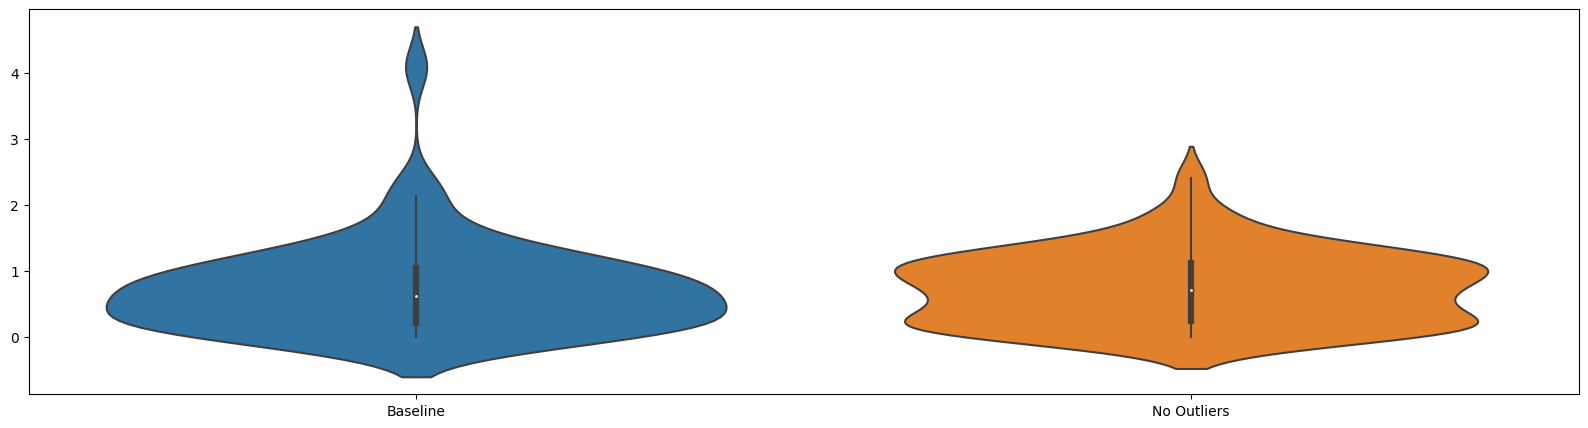

Baseline
|    Aggregation    |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Mean              |   0.69 |   0.98 |  -0.18 |
| Median            |   0.73 |   1.01 |  -0.21 |

No Outliers
|    Aggregation    |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Mean              |    0.7 |   0.95 |   0.28 |
| Median            |   0.74 |   0.84 |   0.36 |

Model: Random Forest
Mean


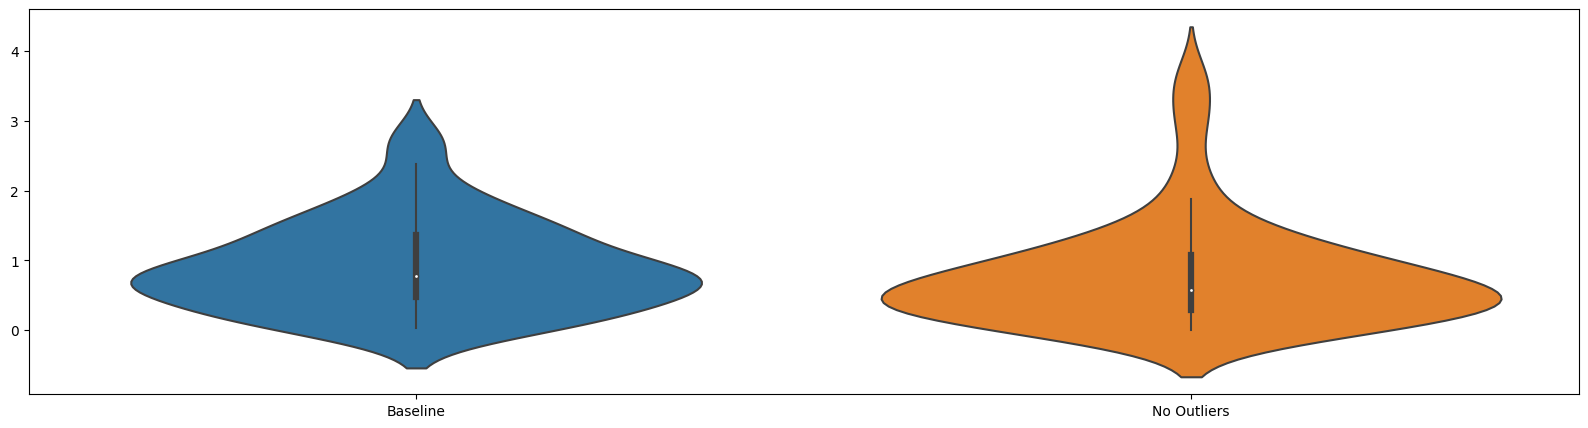

Median


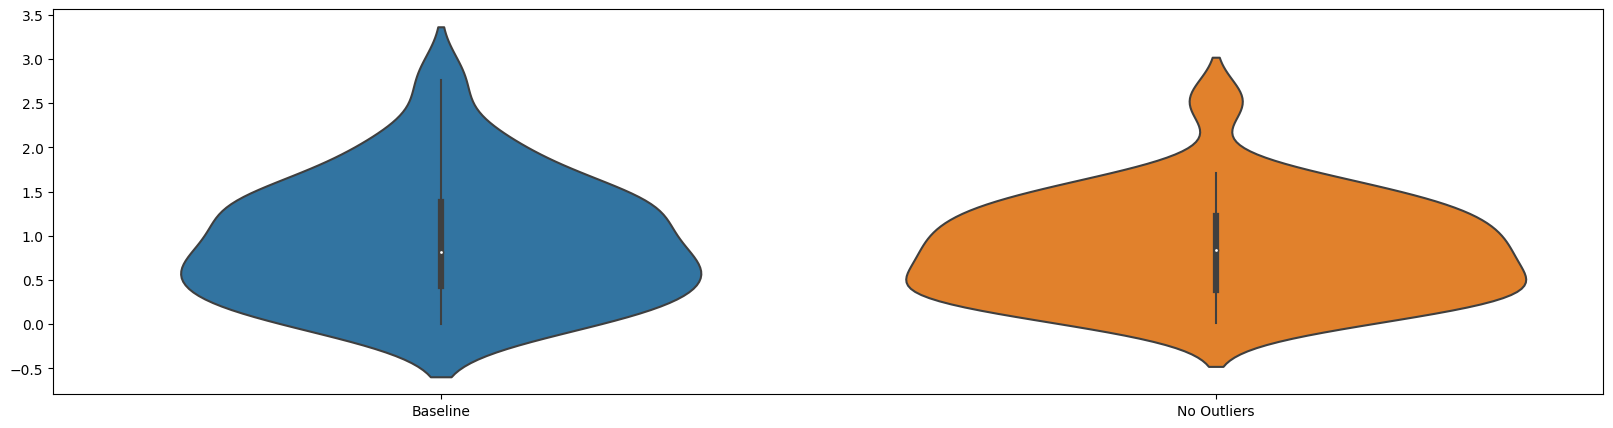

Baseline
|    Aggregation    |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Mean              |   0.91 |   1.25 |  -1.21 |
| Median            |   0.95 |   1.36 |  -1.41 |

No Outliers
|    Aggregation    |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Mean              |   0.78 |   1.18 |   0.12 |
| Median            |   0.85 |   1.04 |   0.21 |

Model: Gradient Boosting
Mean


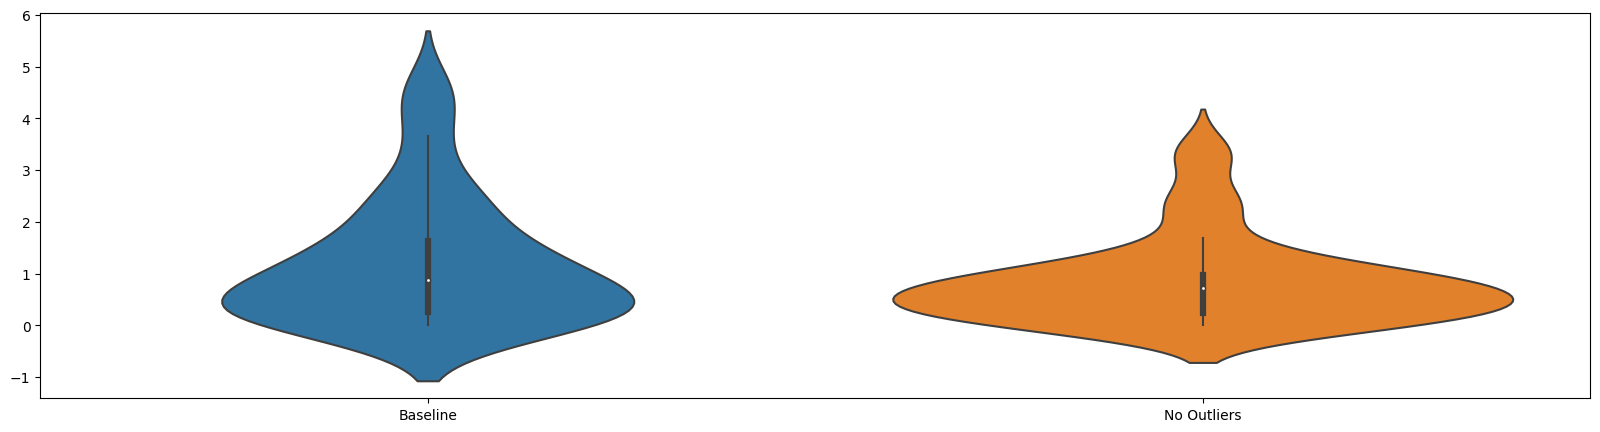

Median


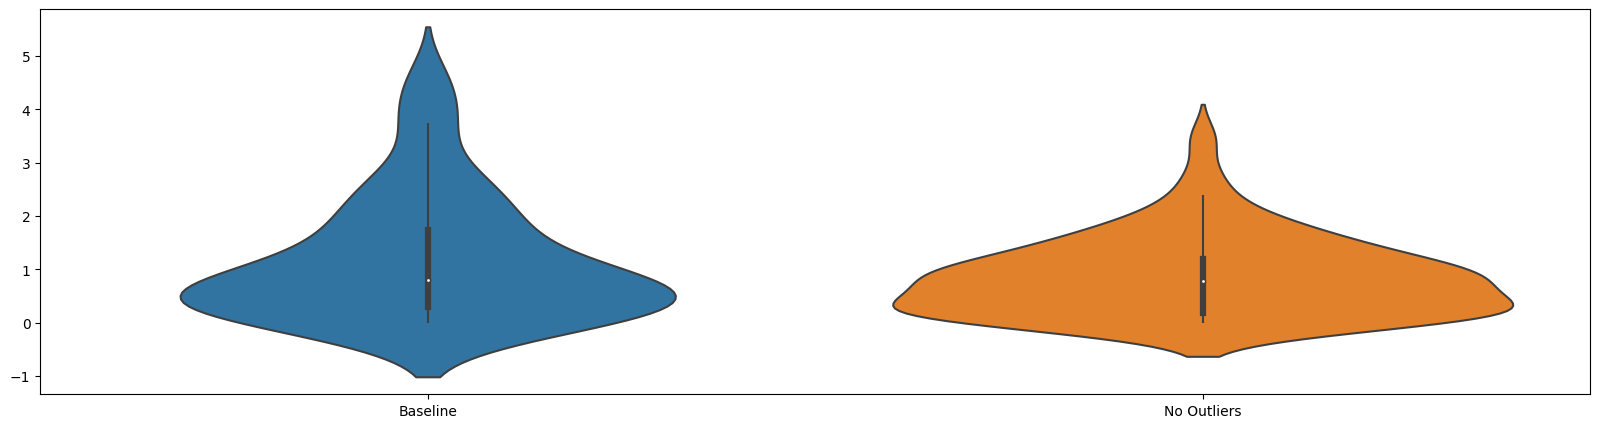

Baseline
|    Aggregation    |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Mean              |    1.2 |   2.93 |  -0.13 |
| Median            |   1.18 |   2.75 |  -0.06 |

No Outliers
|    Aggregation    |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Mean              |   0.84 |   1.37 |  -0.03 |
| Median            |   0.85 |   1.26 |   0.04 |

Model: XGBoost
Mean


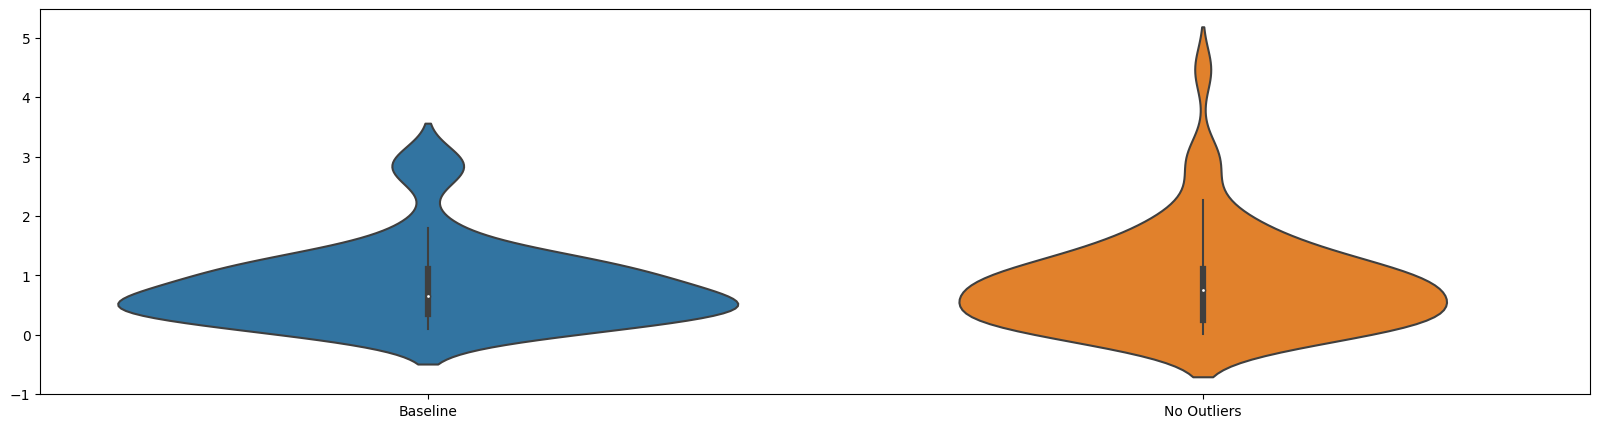

Median


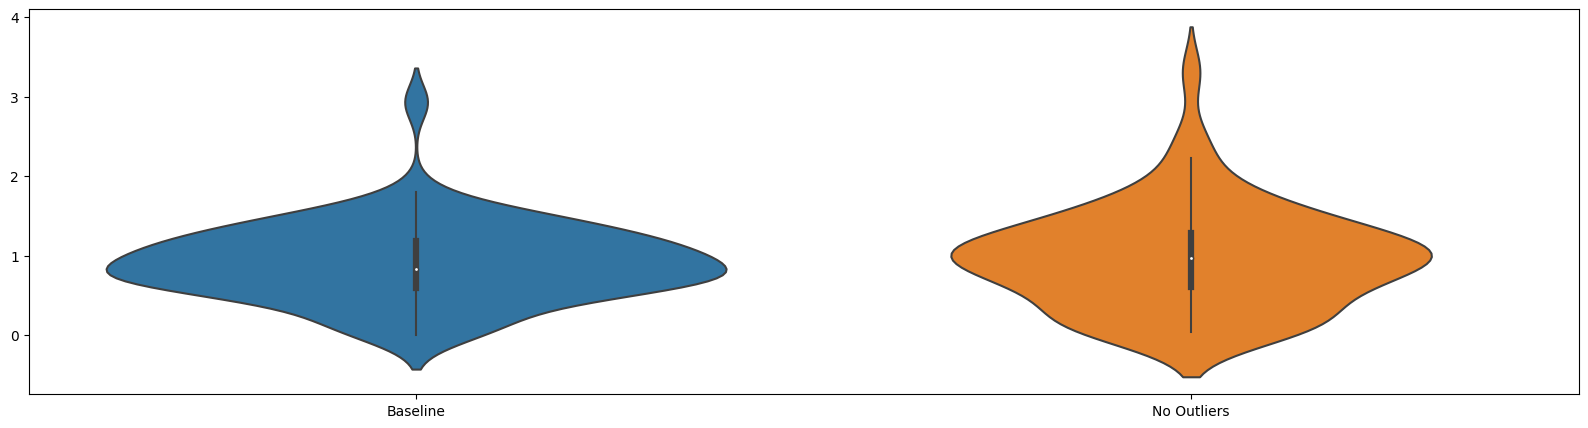

Baseline
|    Aggregation    |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Mean              |   0.84 |   1.15 |  -5.76 |
| Median            |   0.91 |   1.06 |  -5.22 |

No Outliers
|    Aggregation    |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Mean              |   0.88 |   1.44 |  -0.08 |
| Median            |   0.96 |   1.33 |  -0.01 |



In [156]:
print(f'PCE')
missing = get_missing(df, field='PCE (%)')
for name, _, _ in models:
    print(f'Model: {name}')
    preds_pce     = models_02_pce[name].predict(missing)
    out_preds_pce = models_out_02_pce[name].predict(missing)

    print(f'Mean')
    diff_mean_preds = np.abs(preds_pce-mean_k_preds_pce)
    diff_mean_out_preds = np.abs(out_preds_pce-mean_k_preds_pce)

    ax = sns.violinplot(data=[diff_mean_preds, diff_mean_out_preds])
    ax.set_xticklabels(['Baseline', 'No Outliers'])
    plt.show()
    #print(f'RMSE {rmse(preds_pce, mean_k_preds_pce)} {rmse(out_preds_pce, mean_k_preds_pce)}')

    print(f'Median')
    diff_median_preds = np.abs(preds_pce-median_k_preds_pce)
    diff_median_out_preds = np.abs(out_preds_pce-median_k_preds_pce)

    ax = sns.violinplot(data=[diff_median_preds, diff_median_out_preds])
    ax.set_xticklabels(['Baseline', 'No Outliers'])
    plt.show()
    #print(f'RMSE {rmse(preds_pce, median_k_preds_pce)} {rmse(out_preds_pce, median_k_preds_pce)}')

    score_mae_mean = mean_absolute_error(preds_pce, mean_k_preds_pce)
    score_mse_mean = mean_squared_error(preds_pce, mean_k_preds_pce)
    score_r2_mean  = r2_score(preds_pce, mean_k_preds_pce)
                
    score_mae_median = mean_absolute_error(preds_pce, median_k_preds_pce)
    score_mse_median = mean_squared_error(preds_pce, median_k_preds_pce)
    score_r2_median  = r2_score(preds_pce, median_k_preds_pce)

    # print the results
    print(f'Baseline')
    print(f'| {"Aggregation":^17} | {"MAE":^6} | {"MSE":^6} | {"R2":^6} |')
    print(f'| ----------------- | ------ | ------ | ------ |')
    print(f'| {"Mean":<17} | {round(score_mae_mean, 2):>6} | {round(score_mse_mean, 2):>6} | {round(score_r2_mean, 2):>6} |')
    print(f'| {"Median":<17} | {round(score_mae_median, 2):>6} | {round(score_mse_median, 2):>6} | {round(score_r2_median, 2):>6} |')
    print()

    score_mae_mean_out = mean_absolute_error(out_preds_pce, mean_k_preds_pce)
    score_mse_mean_out = mean_squared_error(out_preds_pce, mean_k_preds_pce)
    score_r2_mean_out  = r2_score(mean_k_preds_pce, out_preds_pce)
                
    score_mae_median_out = mean_absolute_error(out_preds_pce, median_k_preds_pce)
    score_mse_median_out = mean_squared_error(out_preds_pce, median_k_preds_pce)
    score_r2_median_out  = r2_score(median_k_preds_pce, out_preds_pce)

    # print the results
    print(f'No Outliers')
    print(f'| {"Aggregation":^17} | {"MAE":^6} | {"MSE":^6} | {"R2":^6} |')
    print(f'| ----------------- | ------ | ------ | ------ |')
    print(f'| {"Mean":<17} | {round(score_mae_mean_out, 2):>6} | {round(score_mse_mean_out, 2):>6} | {round(score_r2_mean_out, 2):>6} |')
    print(f'| {"Median":<17} | {round(score_mae_median_out, 2):>6} | {round(score_mse_median_out, 2):>6} | {round(score_r2_median_out, 2):>6} |')
    print()

hOPT
Model: Linear Regression
Mean


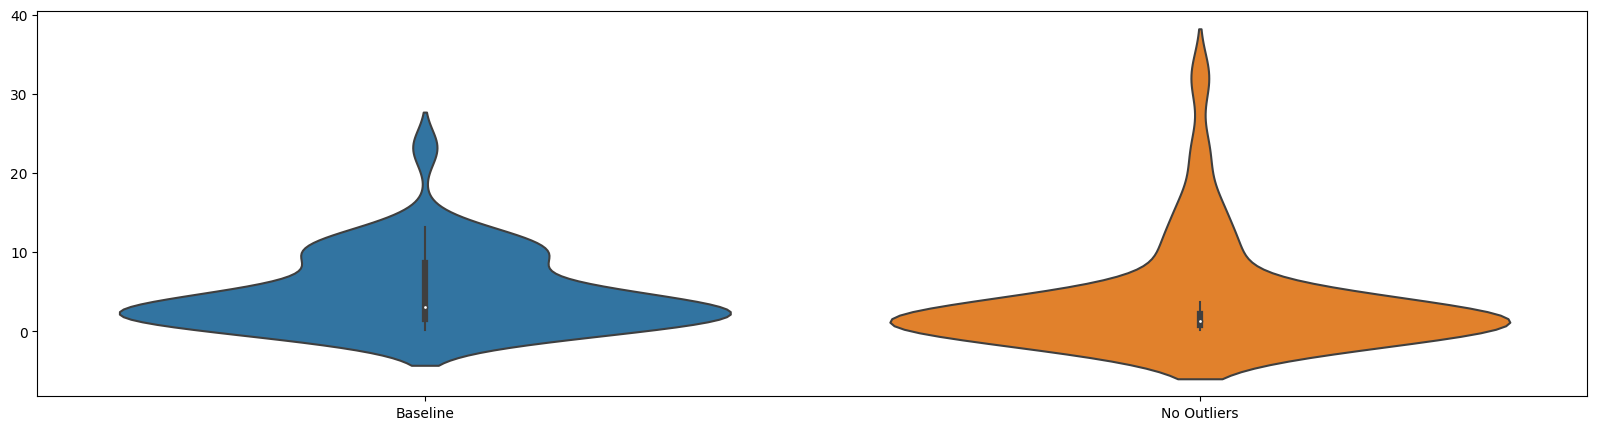

Median


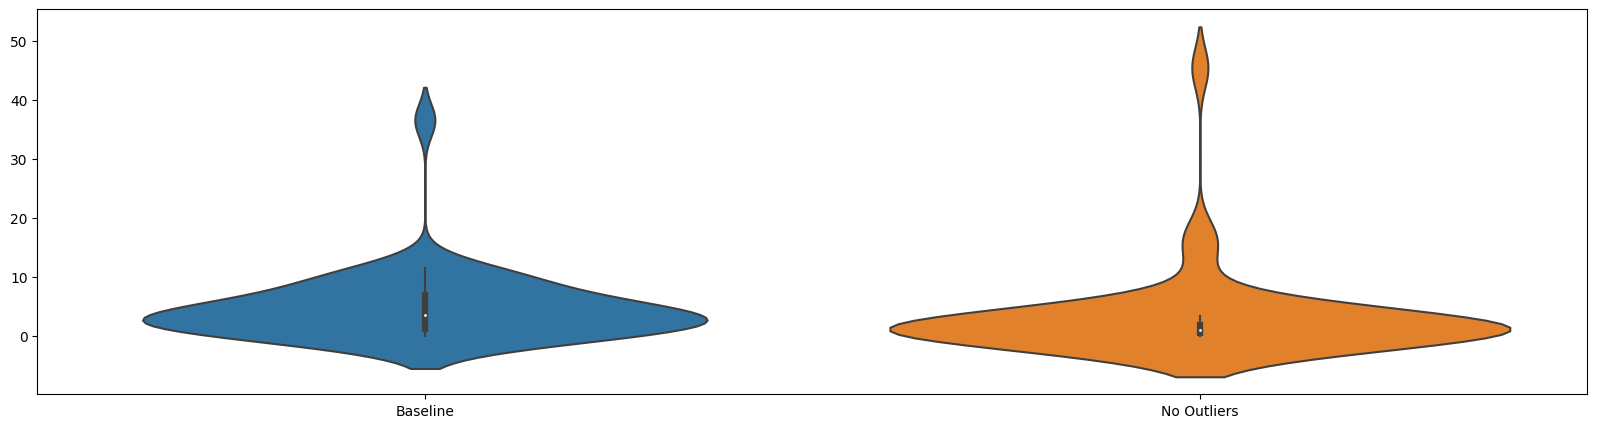

Baseline
|    Aggregation    |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Mean              |   4.99 |  47.15 |  -2.12 |
| Median            |   4.79 |  57.43 |   -2.8 |

No Outliers
|    Aggregation    |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Mean              |   3.84 |  56.54 |  -0.18 |
| Median            |   3.07 |  63.06 |  -0.06 |

Model: K Neighbors
Mean


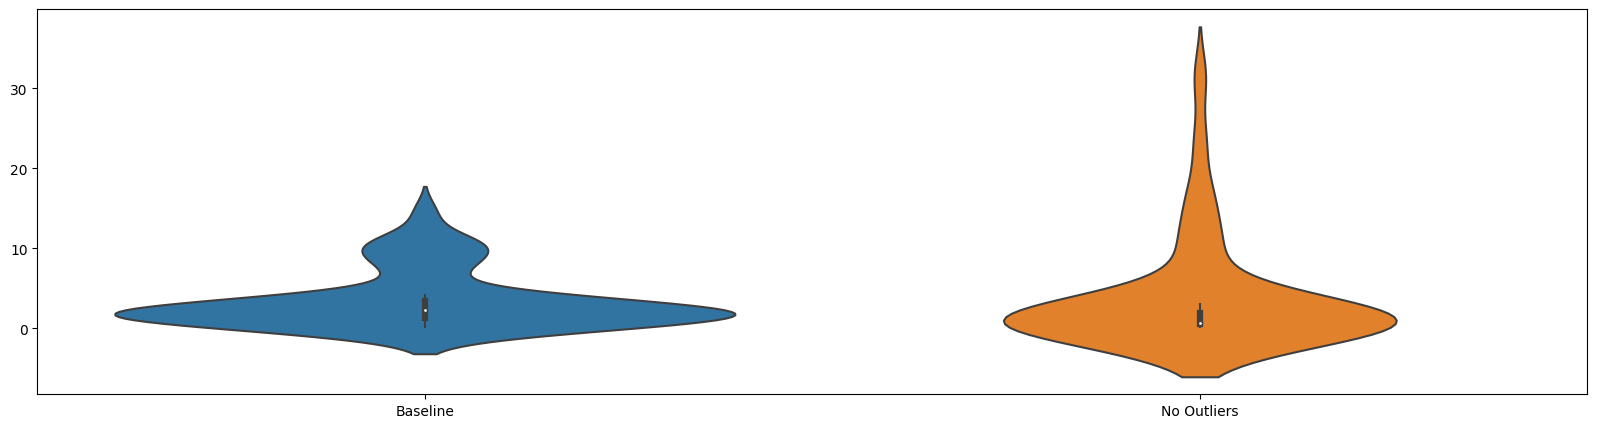

Median


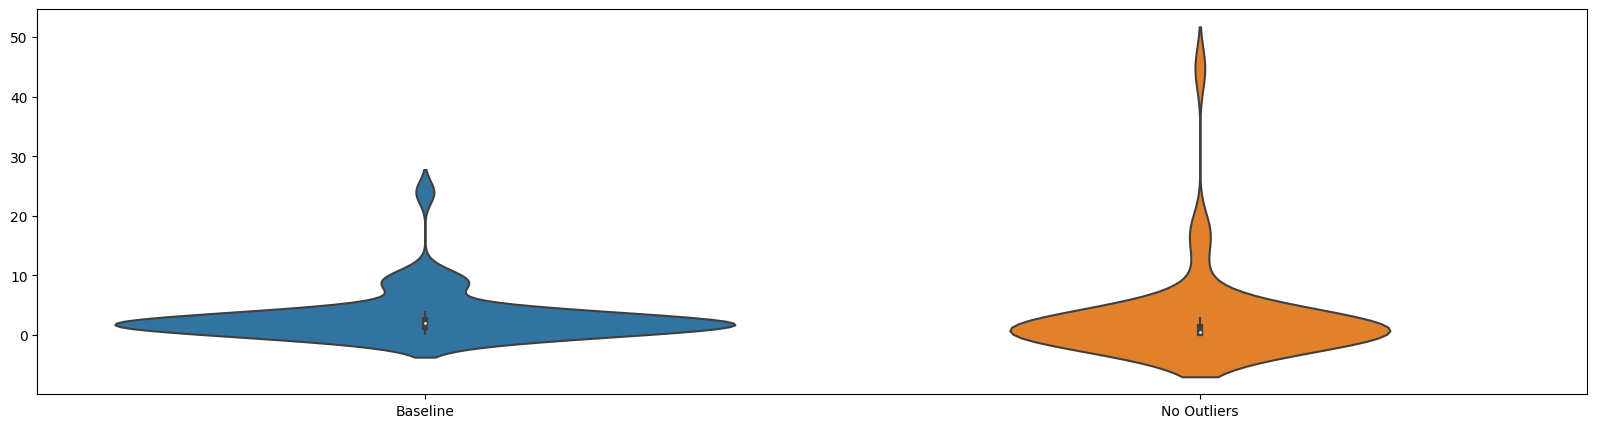

Baseline
|    Aggregation    |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Mean              |   3.47 |   24.3 |   0.06 |
| Median            |   3.09 |  25.61 |   0.01 |

No Outliers
|    Aggregation    |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Mean              |   3.67 |   57.3 |  -0.19 |
| Median            |   2.77 |  62.26 |  -0.04 |

Model: Random Forest
Mean


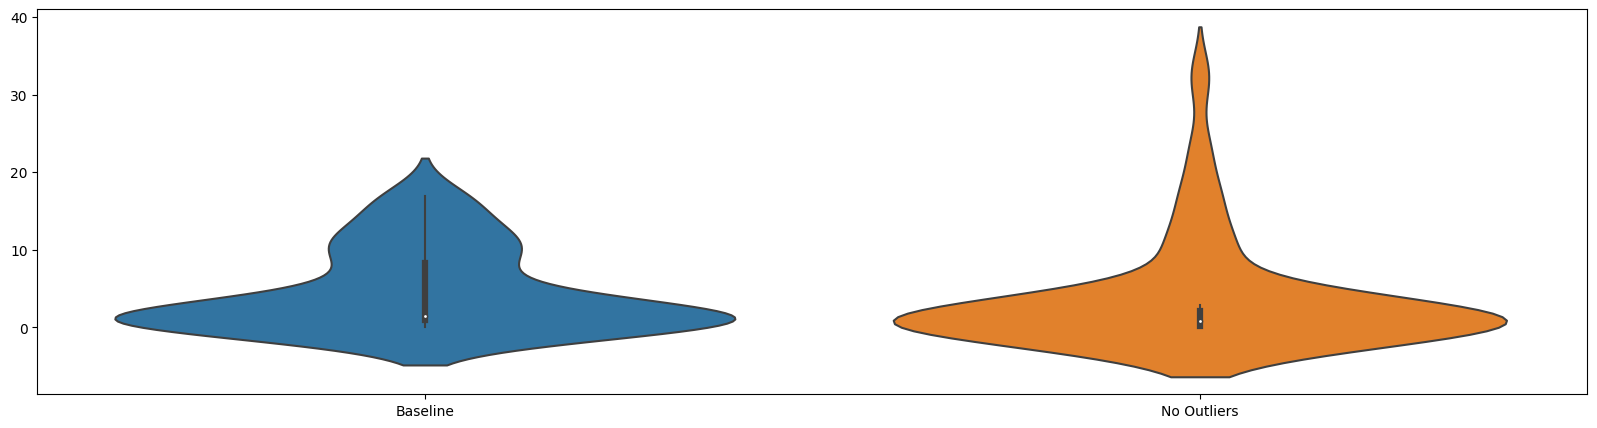

Median


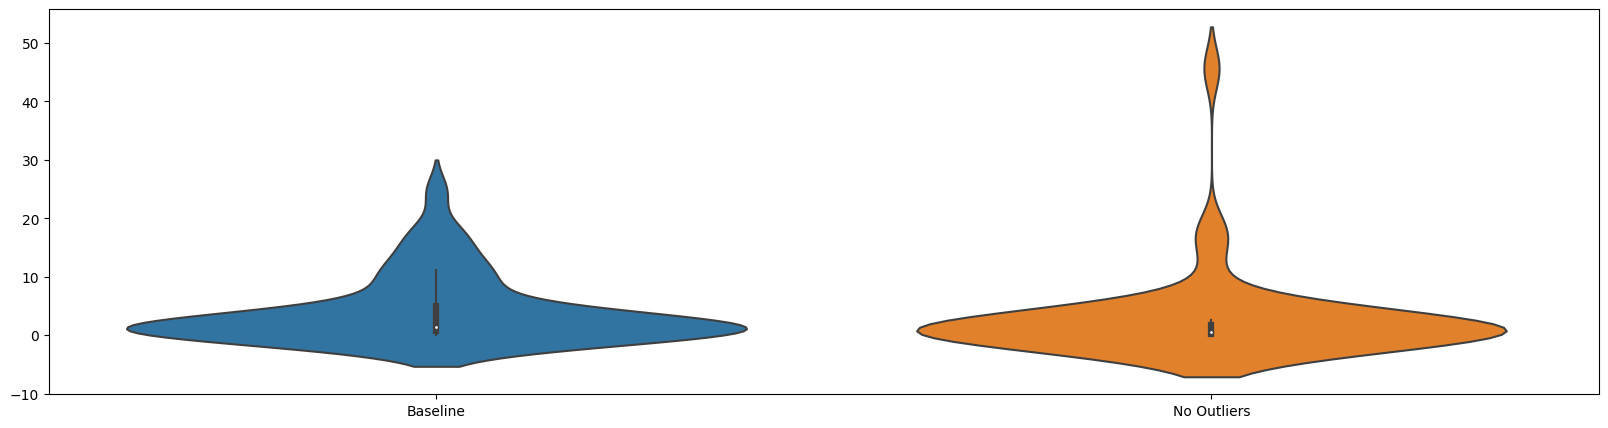

Baseline
|    Aggregation    |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Mean              |   4.61 |  48.37 |  -0.27 |
| Median            |   4.15 |  49.92 |  -0.31 |

No Outliers
|    Aggregation    |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Mean              |   3.56 |  58.65 |  -0.22 |
| Median            |   2.83 |  64.39 |  -0.08 |

Model: Gradient Boosting
Mean


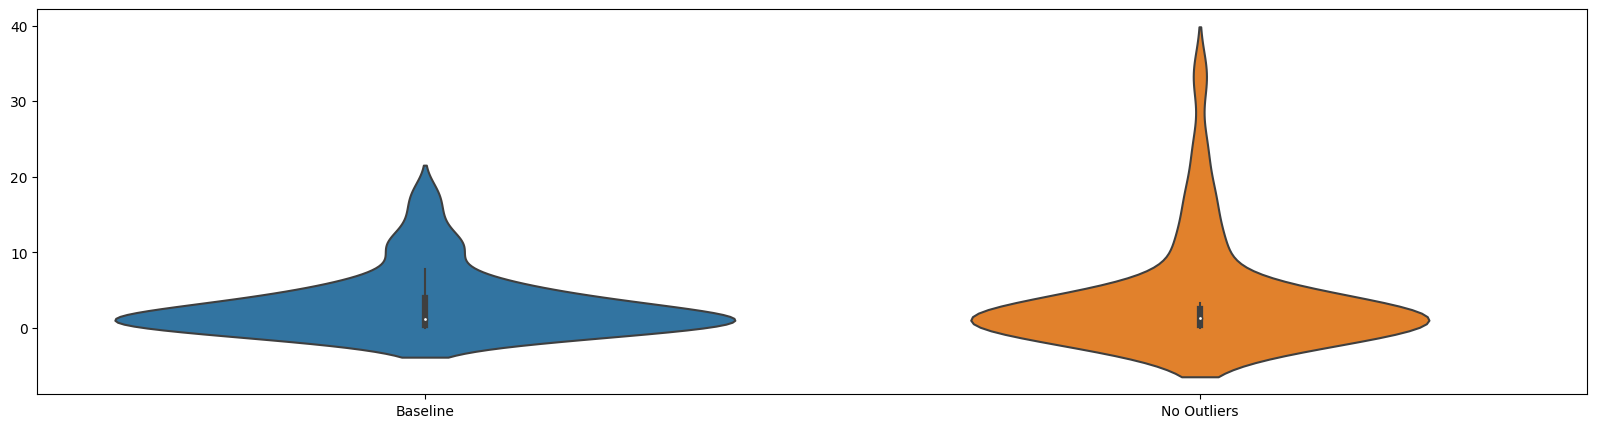

Median


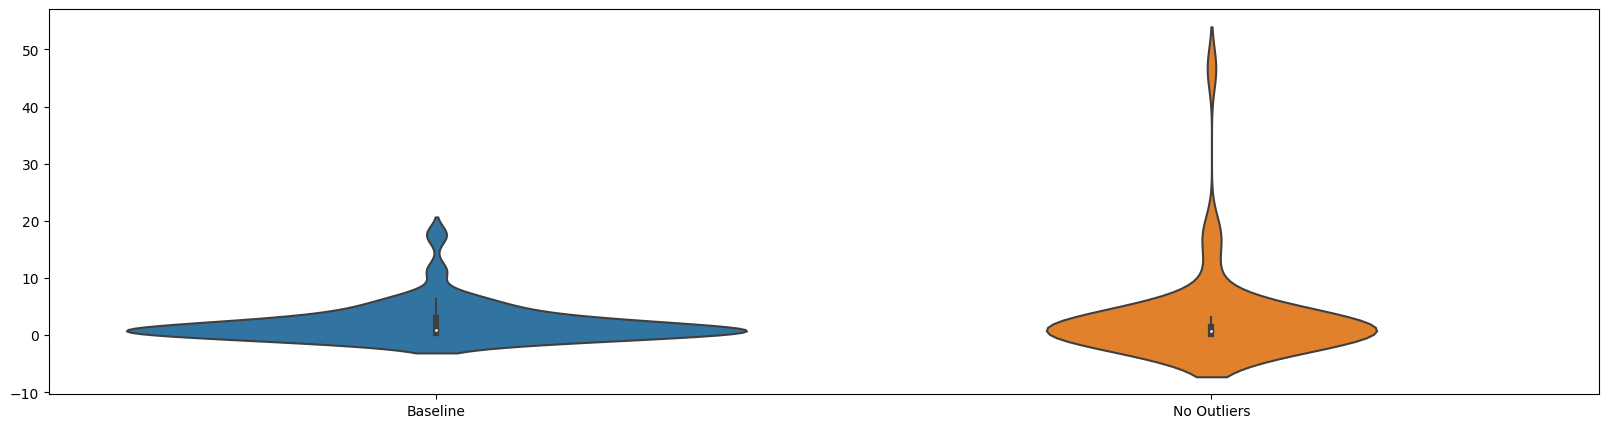

Baseline
|    Aggregation    |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Mean              |   3.18 |   27.1 |   0.42 |
| Median            |   2.25 |   15.9 |   0.66 |

No Outliers
|    Aggregation    |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Mean              |   3.82 |  61.43 |  -0.28 |
| Median            |   2.97 |  67.78 |  -0.14 |

Model: XGBoost
Mean


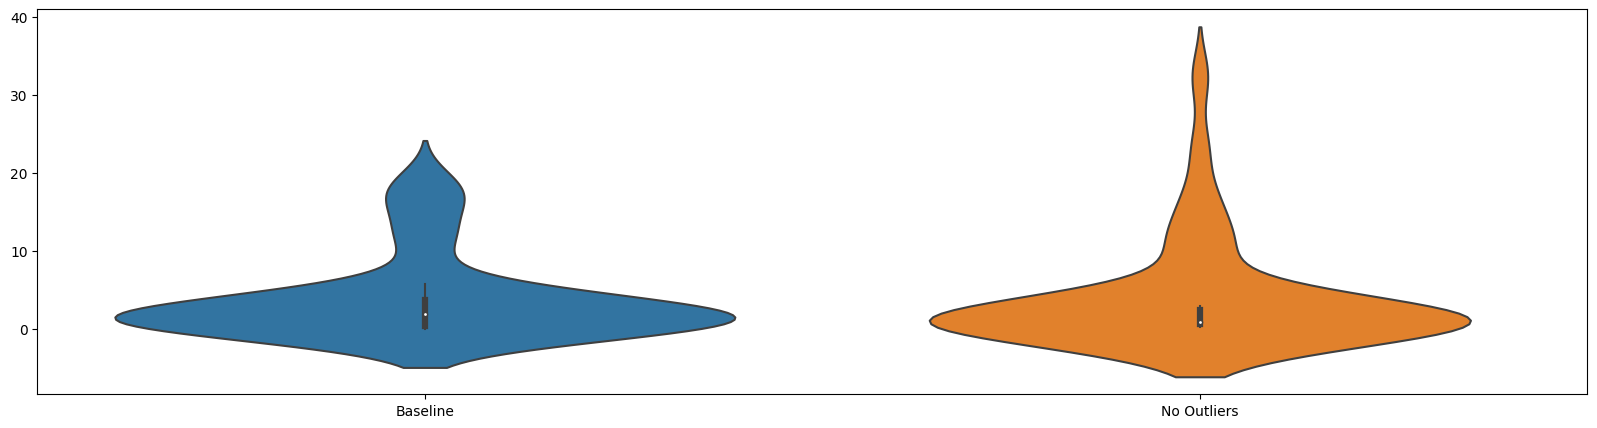

Median


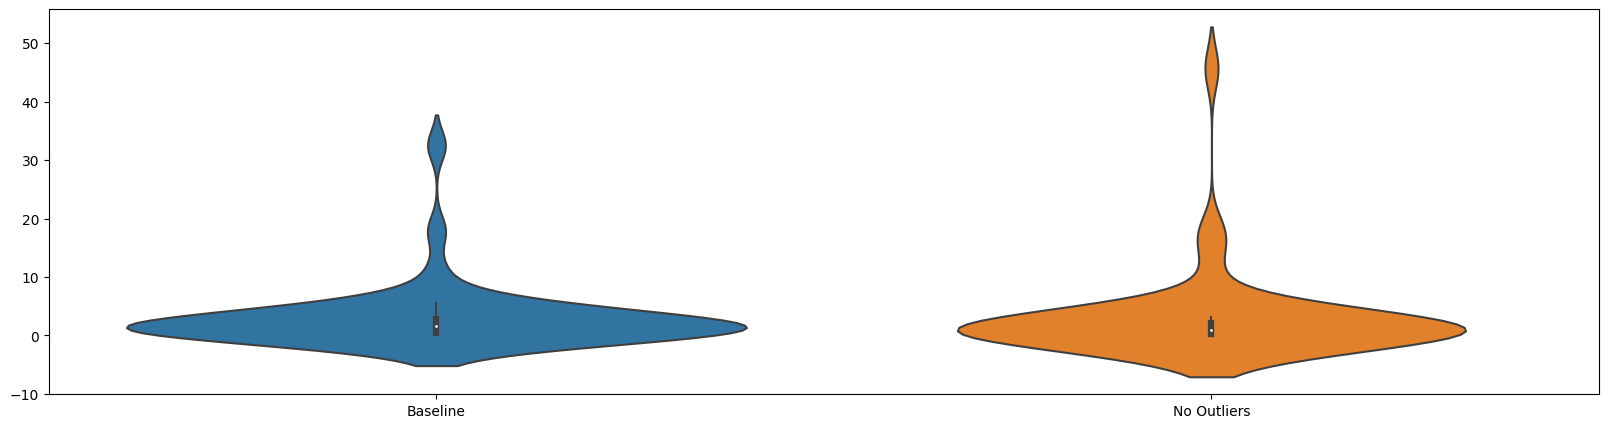

Baseline
|    Aggregation    |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Mean              |   3.77 |  41.68 |  -5.08 |
| Median            |   3.03 |  39.39 |  -4.75 |

No Outliers
|    Aggregation    |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Mean              |   3.79 |  59.47 |  -0.24 |
| Median            |   2.93 |   64.6 |  -0.08 |



In [157]:
print(f'hOPT')
missing = get_missing(df, field='hopt (%)')
for name, _, _ in models:
    print(f'Model: {name}')
    preds_hopt     = models_02_hopt[name].predict(missing)
    out_preds_hopt = models_out_02_hopt[name].predict(missing)
    
    print(f'Mean')
    diff_mean_preds = np.abs(preds_hopt-mean_k_preds_hopt)
    diff_mean_out_preds = np.abs(out_preds_hopt-mean_k_preds_hopt)

    ax = sns.violinplot(data=[diff_mean_preds, diff_mean_out_preds])
    ax.set_xticklabels(['Baseline', 'No Outliers'])
    plt.show()
    #print(f'RMSE {rmse(preds_pce, mean_k_preds_pce)} {rmse(out_preds_pce, mean_k_preds_pce)}')

    print(f'Median')
    diff_median_preds = np.abs(preds_hopt-median_k_preds_hopt)
    diff_median_out_preds = np.abs(out_preds_hopt-median_k_preds_hopt)

    ax = sns.violinplot(data=[diff_median_preds, diff_median_out_preds])
    ax.set_xticklabels(['Baseline', 'No Outliers'])
    plt.show()
    #print(f'RMSE {rmse(preds_pce, median_k_preds_pce)} {rmse(out_preds_pce, median_k_preds_pce)}')

    score_mae_mean = mean_absolute_error(preds_hopt, mean_k_preds_hopt)
    score_mse_mean = mean_squared_error(preds_hopt, mean_k_preds_hopt)
    score_r2_mean  = r2_score(preds_hopt, mean_k_preds_hopt)
                
    score_mae_median = mean_absolute_error(preds_hopt, median_k_preds_hopt)
    score_mse_median = mean_squared_error(preds_hopt, median_k_preds_hopt)
    score_r2_median  = r2_score(preds_hopt, median_k_preds_hopt)

    # print the results
    print(f'Baseline')
    print(f'| {"Aggregation":^17} | {"MAE":^6} | {"MSE":^6} | {"R2":^6} |')
    print(f'| ----------------- | ------ | ------ | ------ |')
    print(f'| {"Mean":<17} | {round(score_mae_mean, 2):>6} | {round(score_mse_mean, 2):>6} | {round(score_r2_mean, 2):>6} |')
    print(f'| {"Median":<17} | {round(score_mae_median, 2):>6} | {round(score_mse_median, 2):>6} | {round(score_r2_median, 2):>6} |')
    print()

    score_mae_mean_out = mean_absolute_error(out_preds_hopt, mean_k_preds_hopt)
    score_mse_mean_out = mean_squared_error(out_preds_hopt, mean_k_preds_hopt)
    score_r2_mean_out  = r2_score(mean_k_preds_hopt, out_preds_hopt)
                
    score_mae_median_out = mean_absolute_error(out_preds_hopt, median_k_preds_hopt)
    score_mse_median_out = mean_squared_error(out_preds_hopt, median_k_preds_hopt)
    score_r2_median_out  = r2_score(median_k_preds_hopt, out_preds_hopt)

    # print the results
    print(f'No Outliers')
    print(f'| {"Aggregation":^17} | {"MAE":^6} | {"MSE":^6} | {"R2":^6} |')
    print(f'| ----------------- | ------ | ------ | ------ |')
    print(f'| {"Mean":<17} | {round(score_mae_mean_out, 2):>6} | {round(score_mse_mean_out, 2):>6} | {round(score_r2_mean_out, 2):>6} |')
    print(f'| {"Median":<17} | {round(score_mae_median_out, 2):>6} | {round(score_mse_median_out, 2):>6} | {round(score_r2_median_out, 2):>6} |')
    print()

In [158]:
df_per_cluster = get_clusters_df(df, df_clustering_index, labels)

for i, df in enumerate(df_per_cluster):
    print(f'Cluster {i}')
    print(f'{df}')

Cluster 0
shape: (25, 12)
┌─────┬──────┬───────────┬──────────┬───┬────────┬────────┬──────────┬─────────┐
│ #   ┆ mat0 ┆ mat1      ┆ abs_peak ┆ … ┆ em_max ┆ QY (%) ┆ hopt (%) ┆ PCE (%) │
│ --- ┆ ---  ┆ ---       ┆ ---      ┆   ┆ ---    ┆ ---    ┆ ---      ┆ ---     │
│ i64 ┆ str  ┆ str       ┆ i64      ┆   ┆ i64    ┆ f64    ┆ f64      ┆ f64     │
╞═════╪══════╪═══════════╪══════════╪═══╪════════╪════════╪══════════╪═════════╡
│ 8   ┆ QD   ┆ solution  ┆ 800      ┆ … ┆ 1000   ┆ 30.0   ┆ 1.4      ┆ 3.2     │
│ 14  ┆ dye  ┆ solution  ┆ 466      ┆ … ┆ 900    ┆ 11.0   ┆ 0.6      ┆ null    │
│ 15  ┆ dye  ┆ solution  ┆ 557      ┆ … ┆ 900    ┆ 9.0    ┆ 0.5      ┆ null    │
│ 26  ┆ dye  ┆ film      ┆ 745      ┆ … ┆ 900    ┆ 25.0   ┆ null     ┆ 0.61    │
│ 27  ┆ dye  ┆ film      ┆ 745      ┆ … ┆ 900    ┆ 25.0   ┆ null     ┆ 1.24    │
│ 28  ┆ dye  ┆ film      ┆ 745      ┆ … ┆ 900    ┆ 25.0   ┆ null     ┆ 0.54    │
│ 29  ┆ dye  ┆ film      ┆ 745      ┆ … ┆ 900    ┆ 25.0   ┆ null     ┆ 1.41    │
│ 

Cluster: 0


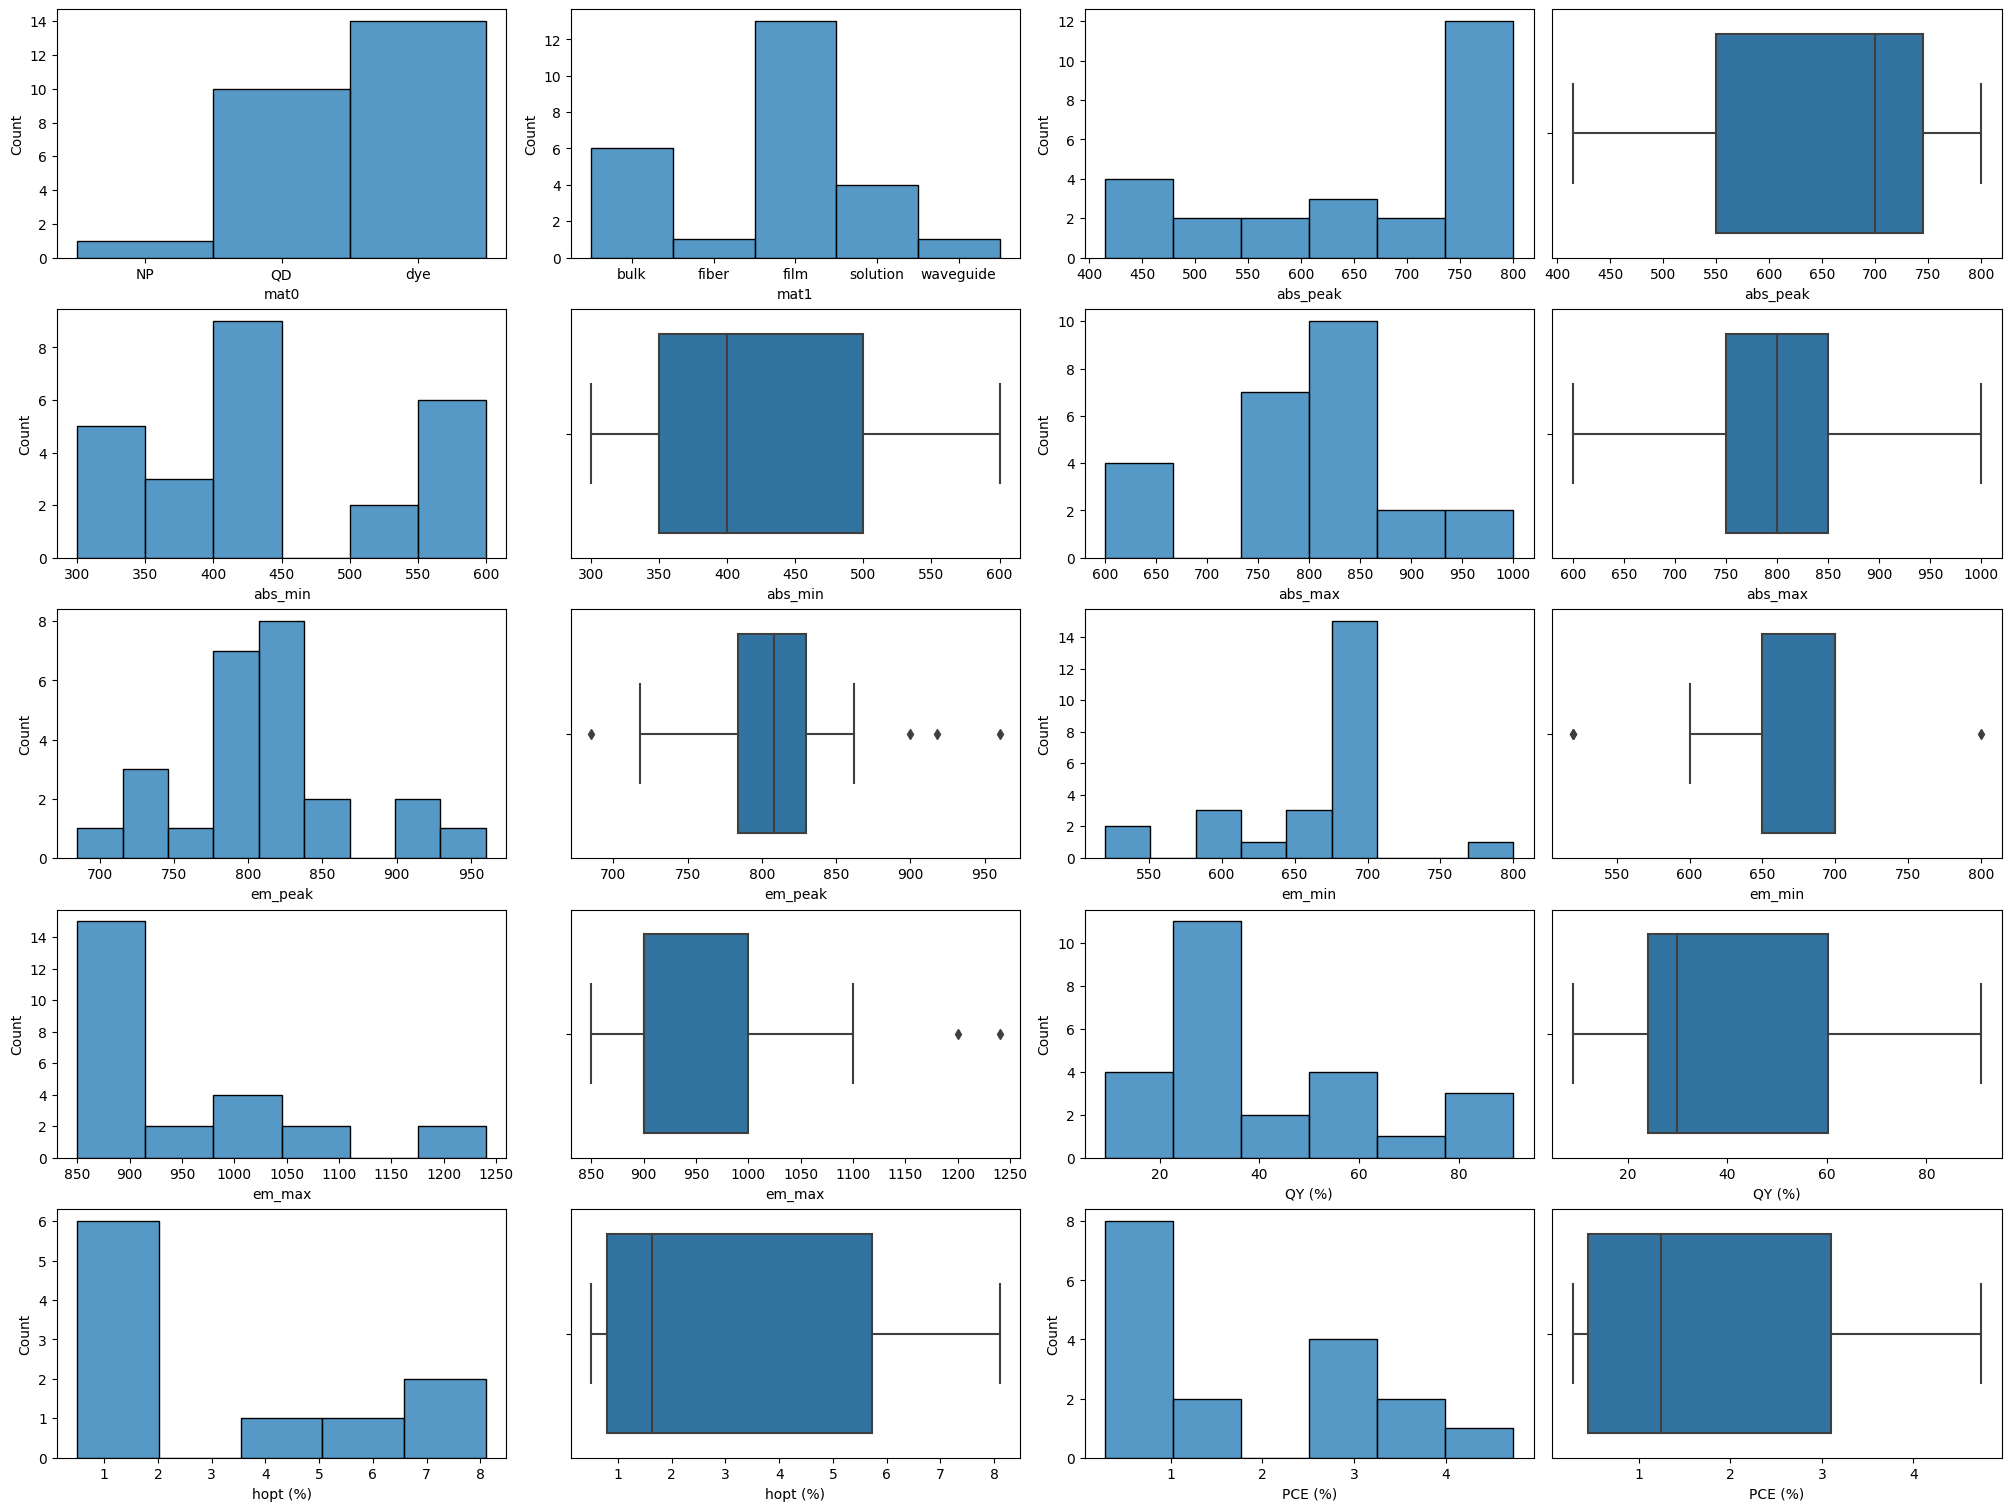

Cluster: 1


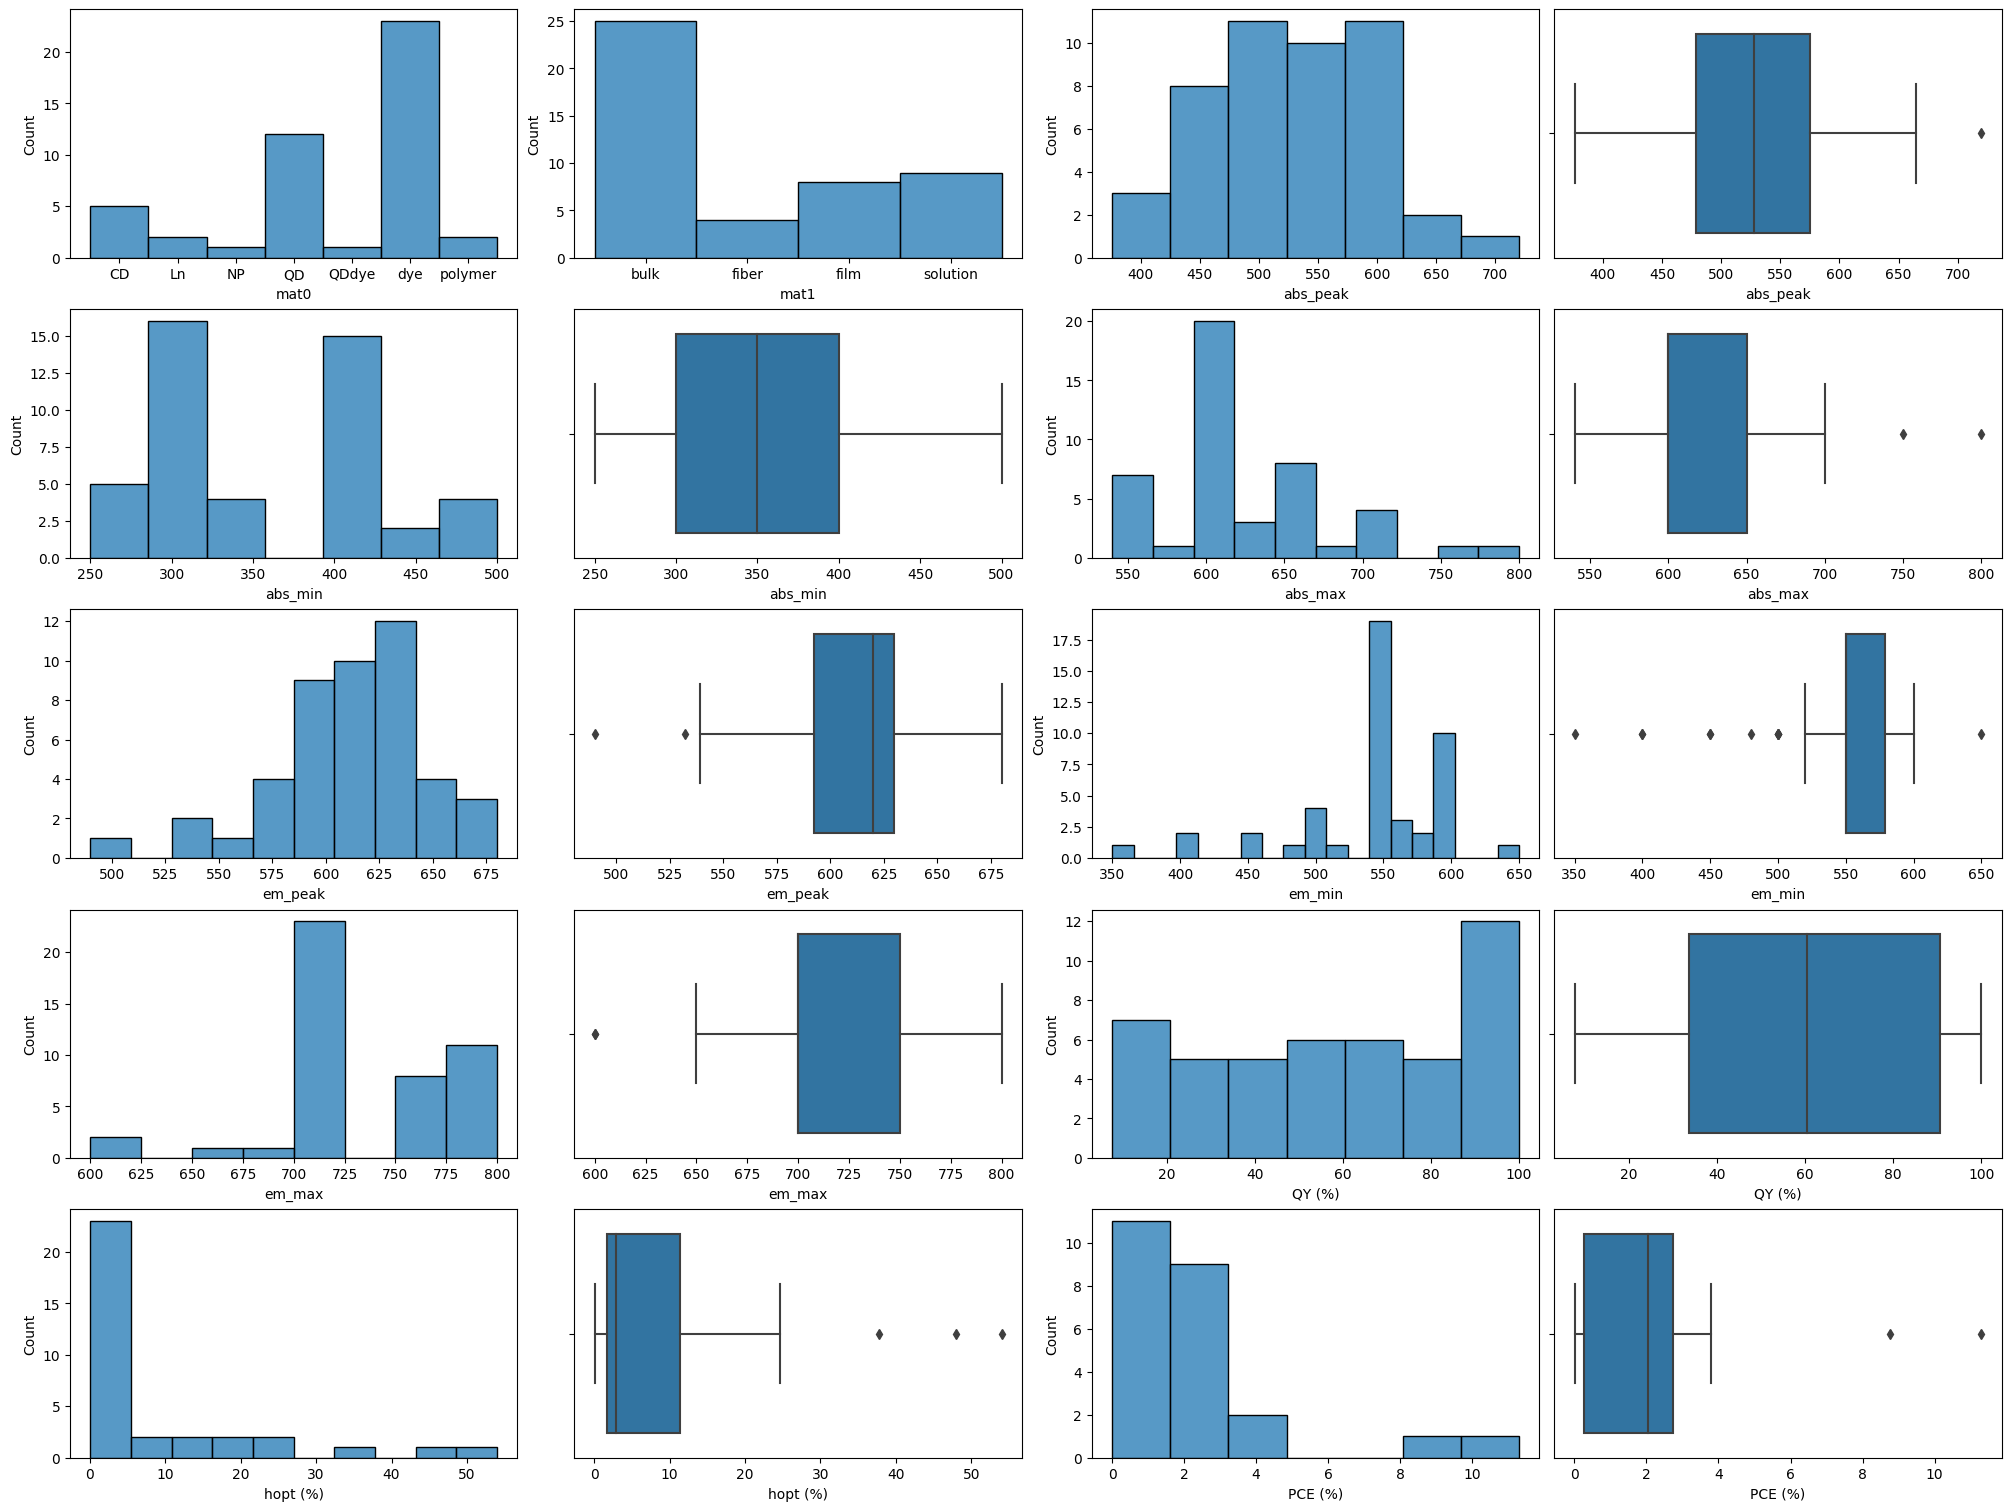

Cluster: 2


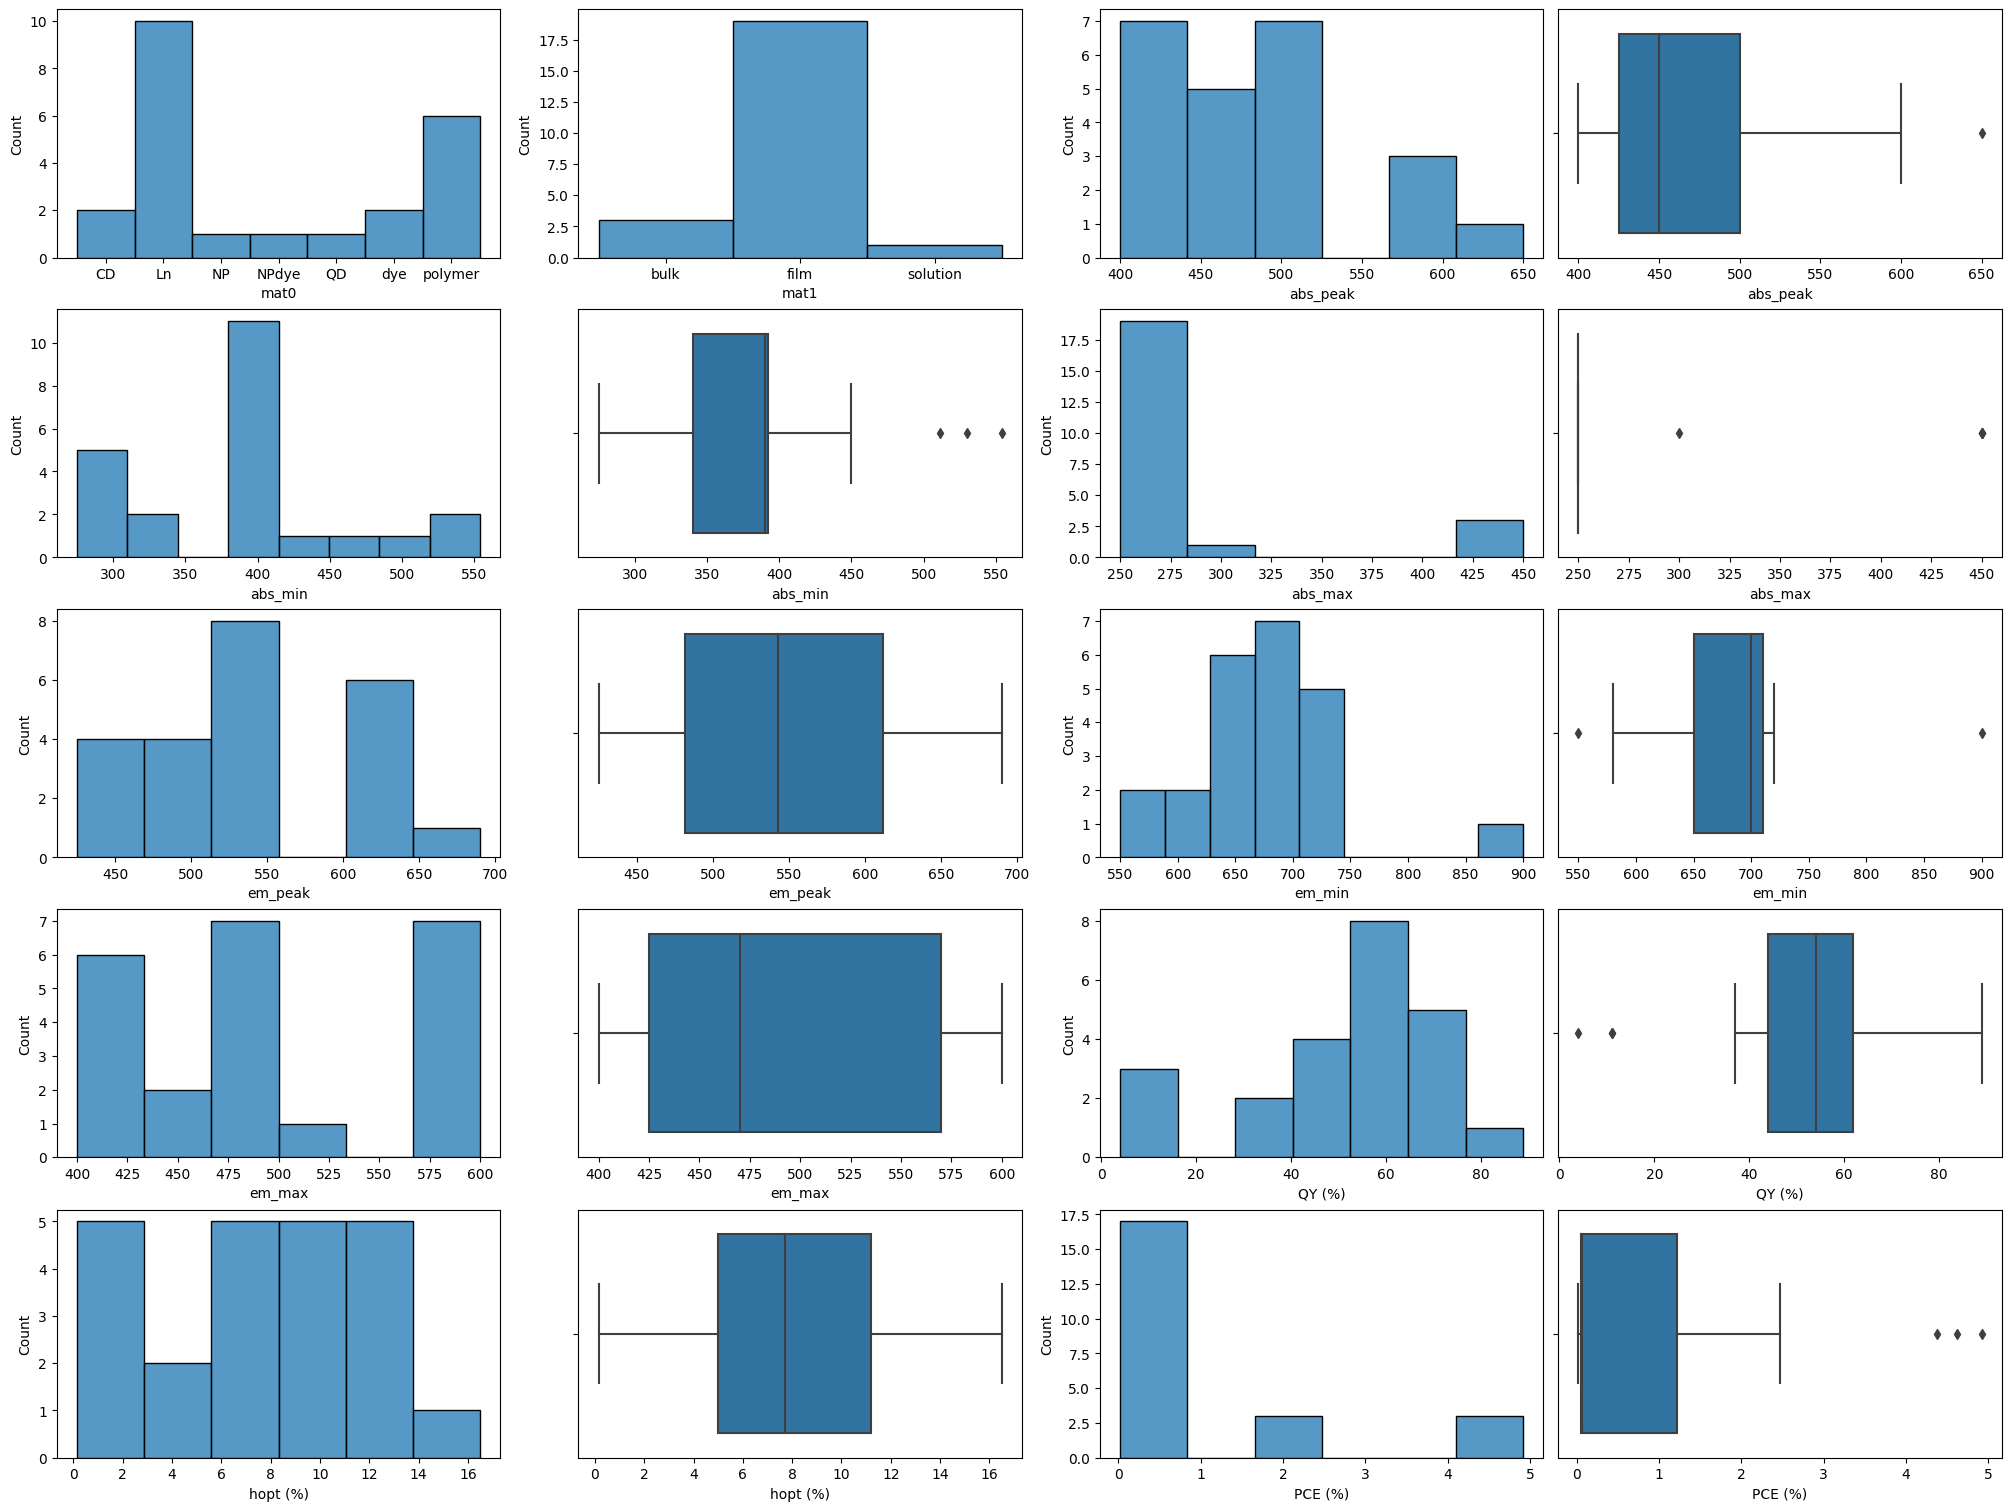

Cluster: 3


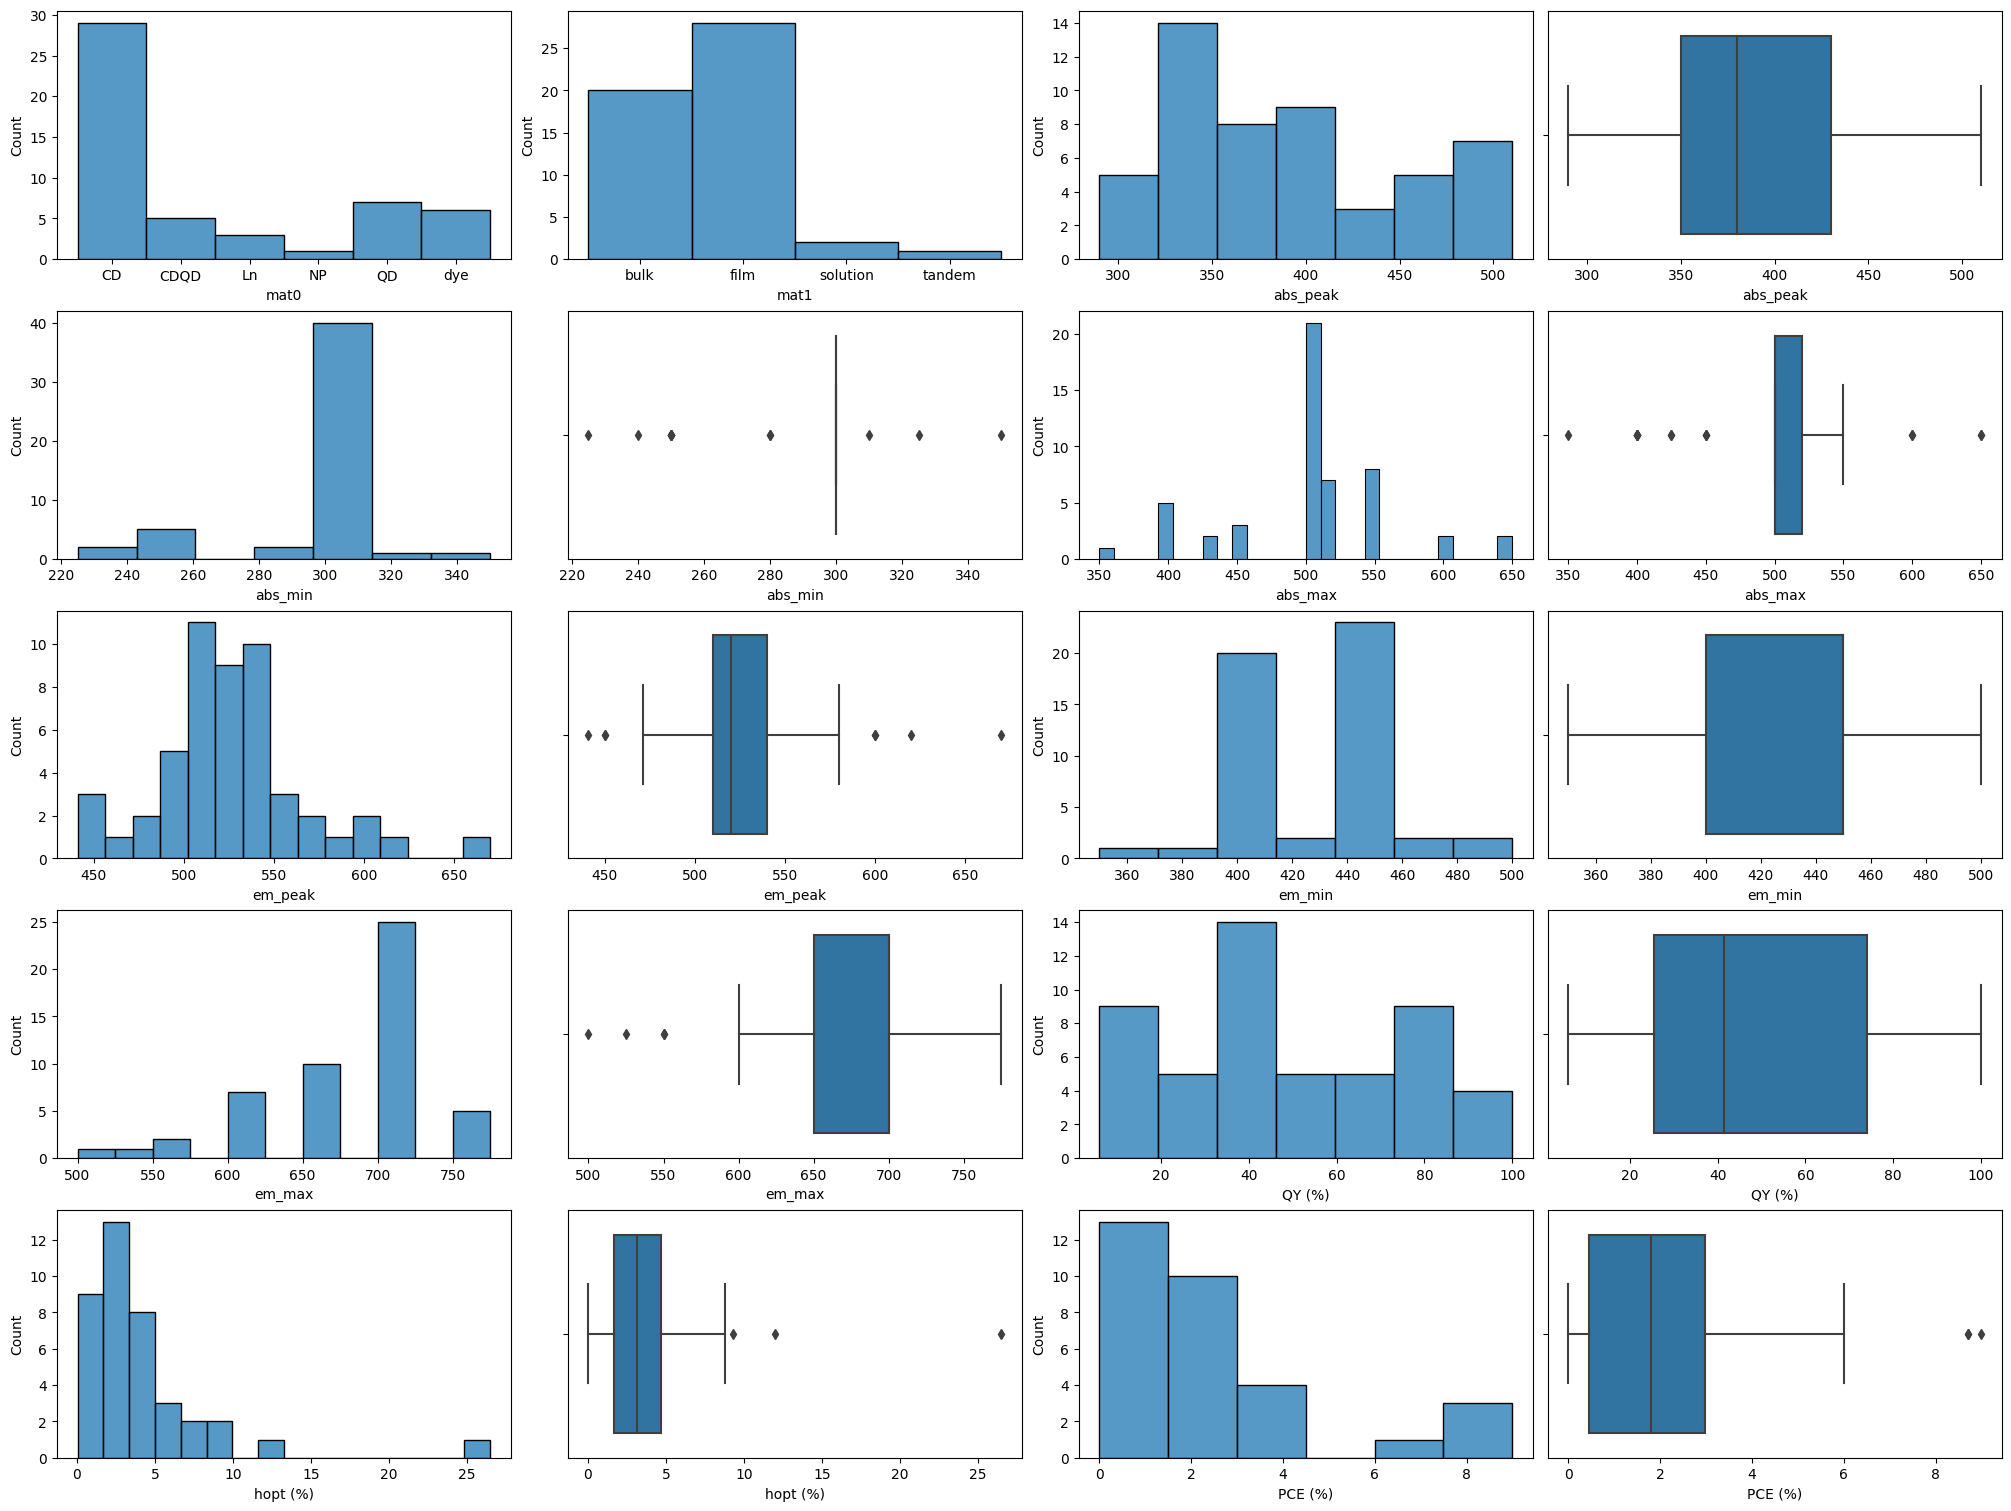

Cluster: 4


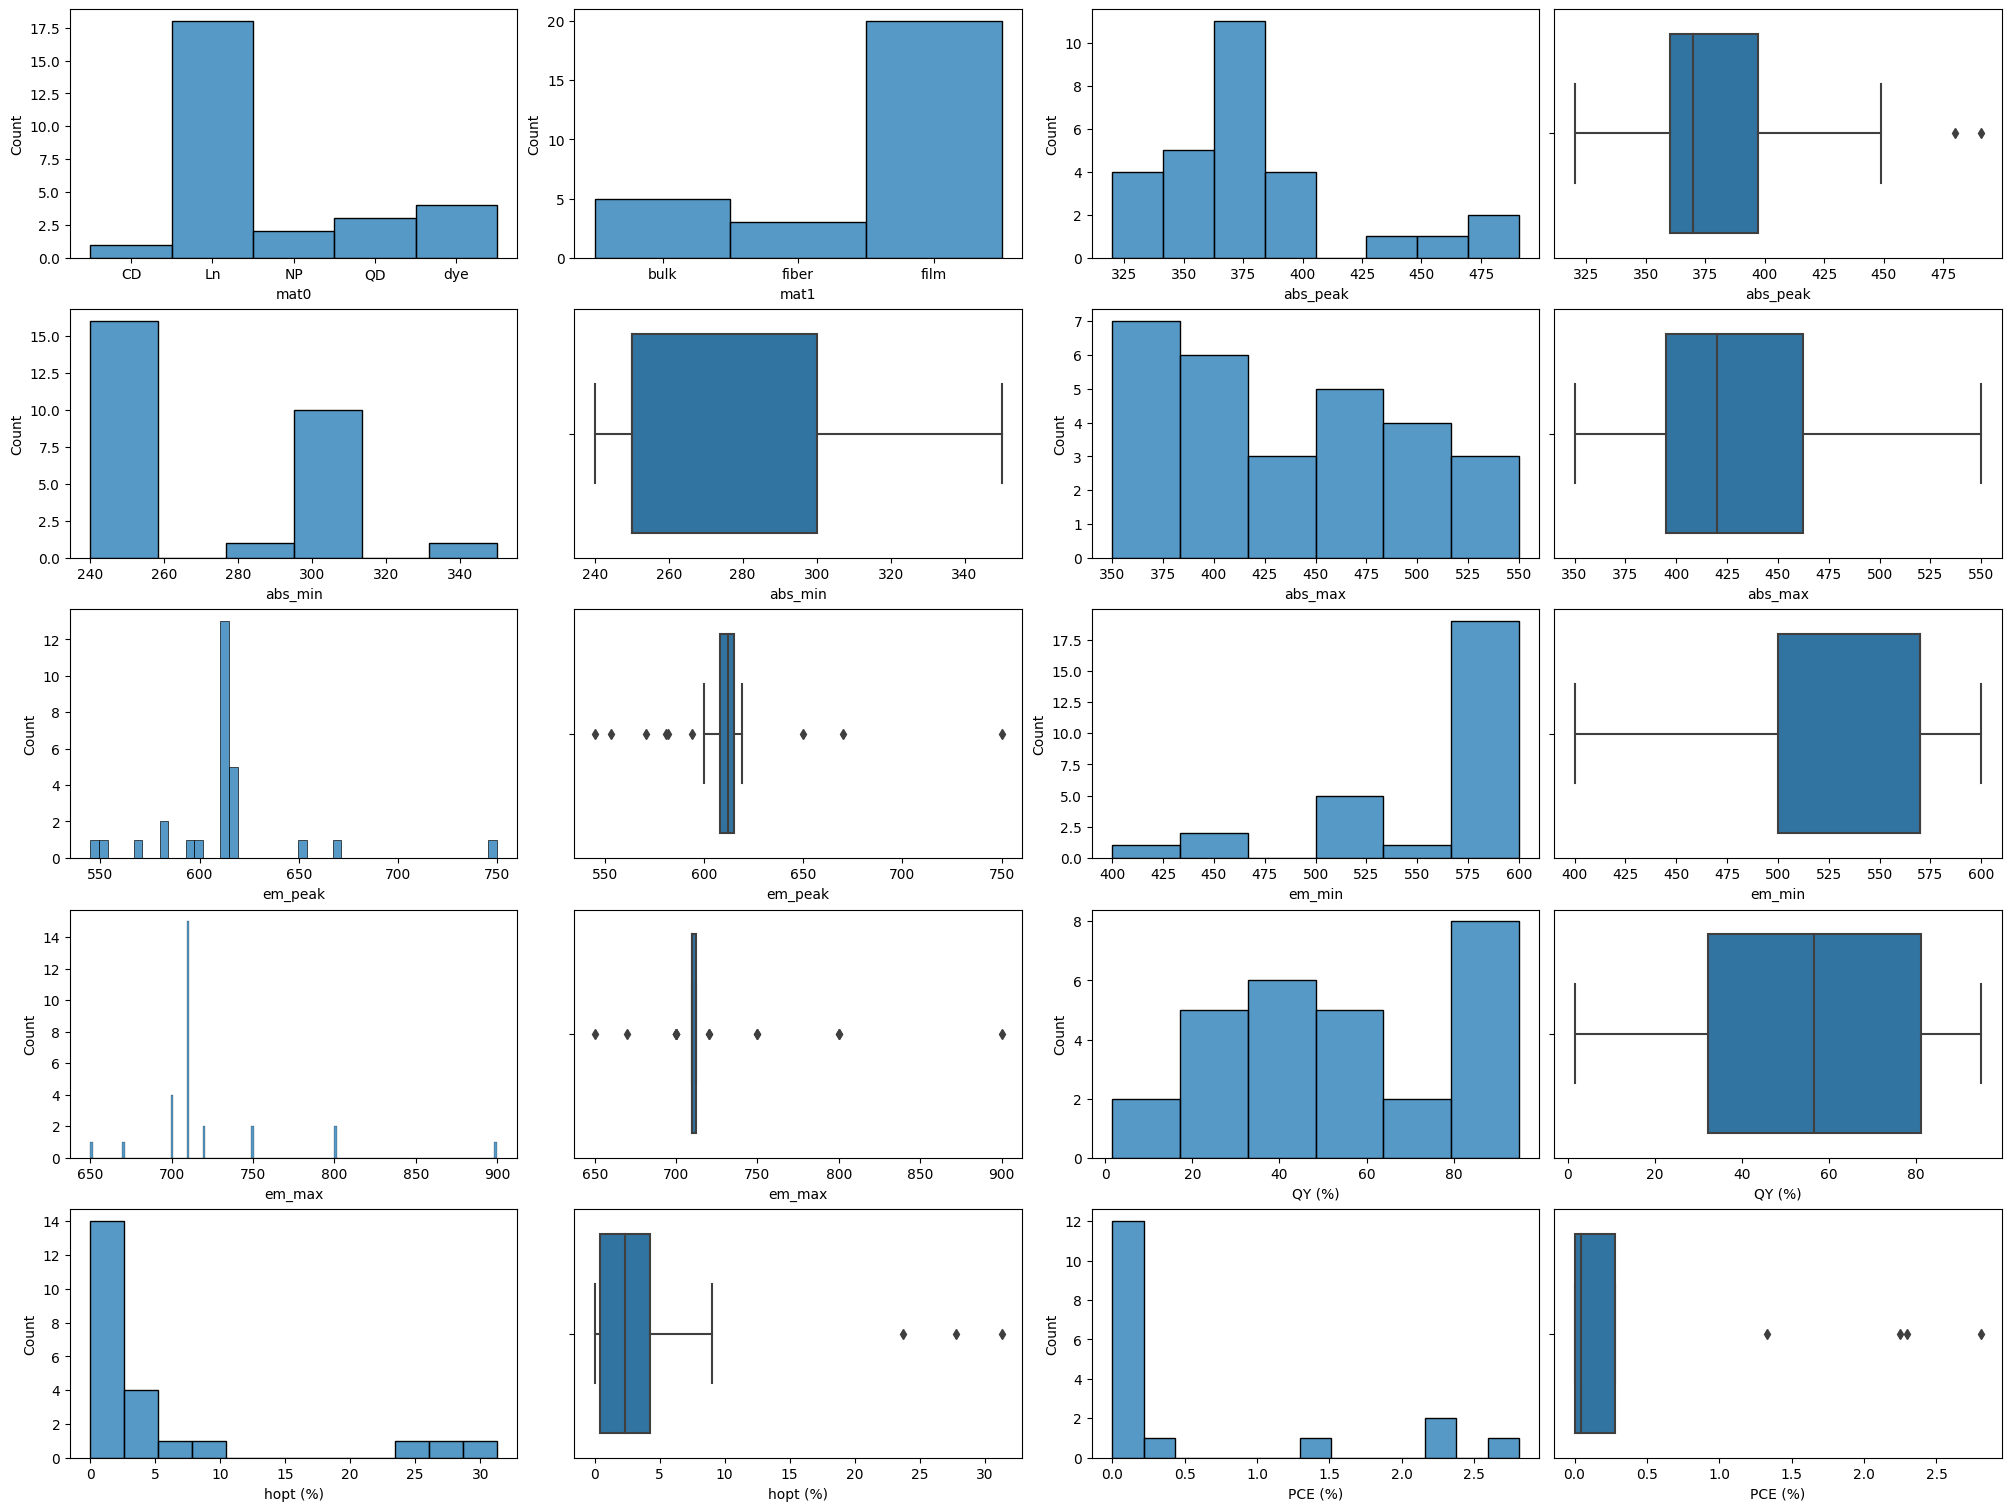

In [131]:
plot_stats_per_cluster(df, df_clustering_index, labels)

## Previous version

In [55]:
X = df[['abs_peak', 'abs_min', 'abs_max', 'em_peak', 'em_min', 'em_max', 'QY (%)', 'hopt (%)', 'PCE (%)']].to_numpy()
X[np.isnan(X)] = 0
X

array([[5.78e+02, 4.20e+02, 6.00e+02, ..., 9.80e+01, 1.88e+01, 0.00e+00],
       [5.40e+02, 4.00e+02, 6.00e+02, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       [5.40e+02, 4.00e+02, 6.00e+02, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       ...,
       [3.70e+02, 2.50e+02, 4.00e+02, ..., 6.00e+01, 2.00e-02, 1.98e-04],
       [5.10e+02, 2.50e+02, 5.20e+02, ..., 7.80e+01, 3.50e-02, 1.82e-04],
       [3.70e+02, 2.50e+02, 4.00e+02, ..., 6.00e+01, 4.80e-02, 4.71e-04]])

In [56]:
# Get the Original Values
QY = X.T[6]
hopt = X.T[7]
PCE = X.T[8]

# Get the Masks for the non-zero values
QY_MASK = QY != 0
hopt_MASK = hopt != 0
PCE_MASK = PCE != 0

# Convert boolean mask to index one
QY_MASK = [i for i in range(len(QY_MASK)) if QY_MASK[i]]
hopt_MASK = [i for i in range(len(hopt_MASK)) if hopt_MASK[i]]
PCE_MASK = [i for i in range(len(PCE_MASK)) if PCE_MASK[i]]

# Compute the average and standard deviation
QY_AVG = np.average(QY[QY_MASK])
QY_STD = np.std(QY[QY_MASK])

hopt_AVG = np.average(hopt[hopt_MASK])
hopt_STD = np.std(hopt[hopt_MASK])

PCE_AVG = np.average(PCE[PCE_MASK])
PCE_STD = np.std(PCE[PCE_MASK])

test = .3
random.seed(42)

# Select the index of the test set
QY_TEST_SET_INDEX = random.sample(QY_MASK, int(len(QY_MASK)*test))
hopt_TEST_SET_INDEX = random.sample(hopt_MASK, int(len(hopt_MASK)*test))
PCE_TEST_SET_INDEX = random.sample(PCE_MASK, int(len(PCE_MASK)*test))

print(f'{QY_TEST_SET_INDEX}\n{hopt_TEST_SET_INDEX}\n{PCE_TEST_SET_INDEX}')

[191, 42, 13, 95, 86, 80, 52, 38, 167, 33, 179, 134, 15, 14, 35, 77, 83, 155, 182, 198, 171, 71, 192, 133, 78, 140, 96, 7, 59, 189, 112, 174, 56, 185, 111, 193, 186, 123, 36, 116, 113, 92, 18, 143, 47, 122, 17, 197, 54, 132, 105]
[142, 83, 22, 14, 93, 123, 31, 94, 38, 148, 116, 170, 143, 59, 144, 140, 87, 135, 50, 139, 176, 137, 132, 12, 126, 130, 32, 106, 188, 44, 194, 193, 81, 182, 175, 138, 190, 41, 179, 187, 149, 150, 10]
[111, 178, 21, 176, 81, 99, 75, 27, 60, 189, 137, 185, 163, 196, 192, 155, 119, 98, 154, 200, 47, 74, 46, 72, 168, 136, 131, 179, 197, 139, 103, 171, 195, 93, 61, 199, 124, 184]


In [57]:
# Store original values from the test set
QY_TEST_SET = QY[QY_TEST_SET_INDEX]
hopt_TEST_SET = hopt[hopt_TEST_SET_INDEX]
PCE_TEST_SET = PCE[PCE_TEST_SET_INDEX]

print(f'{QY_TEST_SET}\n{hopt_TEST_SET}\n{PCE_TEST_SET}')

# Replace the test set with zeros
QY[QY_TEST_SET_INDEX] = 0
hopt[hopt_TEST_SET_INDEX] = 0
PCE[PCE_TEST_SET_INDEX] = 0

print(f'{QY[QY_TEST_SET_INDEX]}\n{hopt[hopt_TEST_SET_INDEX]}\n{PCE[PCE_TEST_SET_INDEX]}')

[ 57.    94.    11.    85.    40.    17.    25.    36.2   15.01  80.
  11.    67.    45.     9.    40.    70.    30.5   35.    59.    60.
  91.    24.    68.    70.    95.    15.7   78.    30.    78.    68.
  60.    44.    81.    54.    10.    65.     4.    93.    63.    86.
  95.    61.   100.    32.7   70.    20.    40.8   31.    35.9   40.
  12.  ]
[2.900e+00 3.400e-01 2.500e-01 5.000e-01 4.300e-01 5.400e+01 2.900e-01
 1.000e-02 2.950e+00 1.360e+00 4.800e+01 2.700e+00 1.000e+00 6.400e+00
 4.560e+00 3.200e+00 4.300e+00 3.770e+01 2.400e+00 1.900e+01 1.310e+01
 5.800e-02 1.600e+00 2.600e+00 6.880e+00 5.840e+00 1.040e+01 7.000e-01
 9.112e+00 9.200e-01 1.600e-01 1.500e-01 2.470e+00 1.070e+01 7.700e+00
 1.700e+00 5.710e+00 1.200e+01 1.280e+01 5.710e+00 3.080e+00 2.550e+00
 3.000e-01]
[2.1000000e+00 4.7000000e-02 5.5000000e-01 5.3000000e-02 1.9000000e-01
 4.4100000e-02 2.8000000e-01 5.4000000e-01 3.2700000e+00 2.4700000e+00
 8.3000000e-04 1.3600000e-01 4.3000000e-01 2.0944000e-02 4.9200000

In [58]:
# Write on the X Matrix again
X.T[6] = QY
X.T[7] = hopt
X.T[8] = PCE

In [59]:
# Grid Search
ks = [2,3,4,5,6,7,8]
seeds = [53, 59, 61, 67, 71, 73, 79, 83, 89, 97]

# Store best solution (min cost)
min_cost = float('inf')
solution = None

for k in ks:
    for s in seeds:
        Xr, W, H, cost = nmf.nmf_mu(X, k=k, seed=s)
        if cost < min_cost:
            min_cost = cost
            solution = (k, s)

In [60]:
print(f"{cost} {solution}")

240.7014298829215 (8, 89)


In [61]:
# Measure the performance of the reconstruction
Xr, W, H, cost = nmf.nmf_mu(X, k=solution[0], seed=solution[1])

# Get the predicted QY, hopt and PCE
QY = Xr.T[6]
hopt = Xr.T[7]
PCE = Xr.T[8]

QY_PREDICT_SET = QY[QY_TEST_SET_INDEX]
hopt_PREDICT_SET = hopt[hopt_TEST_SET_INDEX]
PCE_PREDICT_SET = PCE[PCE_TEST_SET_INDEX]

print(f'{QY_PREDICT_SET}\n{hopt_PREDICT_SET}\n{PCE_PREDICT_SET}')

[ 43.19476256  57.36618551  29.45289327  35.37203453  37.88615172
  35.48326891  59.5814774   57.85260274  75.98787613  97.17117899
  42.4883487   44.79414844  62.98057627  59.429021    86.84775322
  83.45496816  77.29849536  58.67793276  39.3537645   58.85814155
  60.12831325  72.53706666  46.44346894  50.64138143  55.67463888
  25.79171088  71.30235726  52.64346667 111.63016269  46.39312342
  25.9426704   48.43627647  45.86350184  49.99638569  48.89799992
  36.51950202  60.41150463  65.91711634  97.31220914  72.02681533
  67.37665816  25.27688102  78.79131454  44.57098402  32.84761719
  52.89625494  59.55242243 107.36571316  57.38178767  67.81391066
  56.94259908]
[6.20199312 6.23133633 5.36088681 5.36098038 5.73561209 7.05783211
 4.10410046 5.85645417 4.82932711 7.37450949 4.85786375 4.45521426
 4.7321594  7.69340162 5.87275242 3.95892255 5.3072146  5.93833517
 2.52197605 6.37374623 5.0328309  5.11760138 6.0606806  6.60241587
 4.46877528 5.07256705 6.8327119  5.80483552 5.61045522 4

In [62]:
rmse_qy = math.sqrt(mean_squared_error(QY_TEST_SET, QY_PREDICT_SET))
rmse_hopt = math.sqrt(mean_squared_error(hopt_TEST_SET, hopt_PREDICT_SET))
rmse_PCE = math.sqrt(mean_squared_error(PCE_TEST_SET, PCE_PREDICT_SET))

print(f'RMSE(QY): {rmse_qy} ({QY_AVG} ± {QY_STD})')
print(f'RMSE(HOPT): {rmse_hopt} ({hopt_AVG} ± {hopt_STD})')
print(f'RMSE(PCE): {rmse_PCE} ({PCE_AVG} ± {PCE_STD})')

RMSE(QY): 32.16083319766573 (51.10491329479768 ± 26.800503287019982)
RMSE(HOPT): 11.702093590744184 (6.083229166666666 ± 8.376054112533762)
RMSE(PCE): 2.0338918837583355 (1.8614349482041015 ± 2.2457725071938213)


### Grid Search (optimize with test set)

In [63]:
# Grid Search
ks = [2,3,4,5,6,7,8]
seeds = [53, 59, 61, 67, 71, 73, 79, 83, 89, 97]

# Store best solution (min cost)
min_cost = float('inf')
solution = None

for k in ks:
    for s in seeds:
        Xr, _, _, _ = nmf.nmf_mu(X, k=k, seed=s)
        # Get the values with the mask
        hopt = Xr.T[7]
        PCE = Xr.T[8]
        hopt_PREDICT_SET = hopt[hopt_TEST_SET_INDEX]
        PCE_PREDICT_SET = PCE[PCE_TEST_SET_INDEX]
        # Compute the cost of the test set
        rmse_hopt = math.sqrt(mean_squared_error(hopt_TEST_SET, hopt_PREDICT_SET))
        rmse_PCE = math.sqrt(mean_squared_error(PCE_TEST_SET, PCE_PREDICT_SET))
        #cost = rmse_hopt + rmse_PCE
        #cost = rmse_hopt
        cost = rmse_PCE
        if cost < min_cost:
            min_cost = cost
            solution = (k, s)

In [64]:
print(f"{cost} {solution}")

1.9883748673493318 (8, 61)


In [65]:
# Measure the performance of the reconstruction
Xr, W, H, cost = nmf.nmf_mu(X, k=solution[0], seed=solution[1])

# Get the predicted QY, hopt and PCE
QY = Xr.T[6]
hopt = Xr.T[7]
PCE = Xr.T[8]

QY_PREDICT_SET = QY[QY_TEST_SET_INDEX]
hopt_PREDICT_SET = hopt[hopt_TEST_SET_INDEX]
PCE_PREDICT_SET = PCE[PCE_TEST_SET_INDEX]

print(f'{QY_PREDICT_SET}\n{hopt_PREDICT_SET}\n{PCE_PREDICT_SET}')

[ 67.01904974  44.33216462  25.83139294  36.99317835  39.91544007
  85.09522385  93.49651356  52.49619443  22.82317313  52.26737587
  51.14458932  29.04806992  44.91513635  40.70914748  61.19885037
  68.89140009  43.31200844  34.2524091   42.04539507  39.27135342
  32.73541702  97.0589676   69.51404378  51.98451394  39.29589776
  50.66497016  46.53704466 103.58395933  58.59040679  69.54882749
  83.34718498  41.92046709  40.17003362  30.86926338  58.7884575
  74.78608704  97.45989866  61.92629548  28.80032874  25.24782809
  46.35433529  38.48131862  50.26673615  56.95533387  18.27235993
  37.8084915   60.88830193  43.60738377  57.07473592  57.61032897
  48.52784838]
[5.90195071 6.32578003 5.5778693  5.54840139 6.43644336 6.52428189
 4.76214342 6.18731456 4.86486126 7.92597659 4.09587156 4.64116318
 4.05309161 7.15725608 5.36194292 3.46541755 5.84568842 4.4290717
 1.71375802 5.37807213 4.76716987 4.62638826 5.40256808 5.41349216
 4.45573621 5.35892476 6.85452543 5.49086745 5.40956372 4.6

In [66]:
rmse_qy = math.sqrt(mean_squared_error(QY_TEST_SET, QY_PREDICT_SET))
rmse_hopt = math.sqrt(mean_squared_error(hopt_TEST_SET, hopt_PREDICT_SET))
rmse_PCE = math.sqrt(mean_squared_error(PCE_TEST_SET, PCE_PREDICT_SET))

print(f'RMSE(QY): {rmse_qy} ({QY_AVG} ± {QY_STD})')
print(f'RMSE(HOPT): {rmse_hopt} ({hopt_AVG} ± {hopt_STD})')
print(f'RMSE(PCE): {rmse_PCE} ({PCE_AVG} ± {PCE_STD})')

RMSE(QY): 37.68974065345328 (51.10491329479768 ± 26.800503287019982)
RMSE(HOPT): 11.935837793503365 (6.083229166666666 ± 8.376054112533762)
RMSE(PCE): 1.9297280952169986 (1.8614349482041015 ± 2.2457725071938213)


### Reconstruct the matrix

In [67]:
# Get the original matrix
X = df[['abs_peak', 'abs_min', 'abs_max', 'em_peak', 'em_min', 'em_max', 'QY (%)', 'hopt (%)', 'PCE (%)']].to_numpy()
X[np.isnan(X)] = 0
print(X.shape)

# Get the reconstructed matrix
Xr, _, _, _ = nmf.nmf_mu(X, k=solution[0], seed=solution[1])

# Replace all zeros with reconstructed values
X[X==0] = Xr[X==0]

(201, 9)


In [68]:
X

array([[5.78000000e+02, 4.20000000e+02, 6.00000000e+02, ...,
        9.80000000e+01, 1.88000000e+01, 2.48715505e+00],
       [5.40000000e+02, 4.00000000e+02, 6.00000000e+02, ...,
        5.44561654e+01, 6.69554372e+00, 2.07177642e+00],
       [5.40000000e+02, 4.00000000e+02, 6.00000000e+02, ...,
        5.82608534e+01, 6.85594715e+00, 2.19517736e+00],
       ...,
       [3.70000000e+02, 2.50000000e+02, 4.00000000e+02, ...,
        6.00000000e+01, 2.00000000e-02, 1.98000000e-04],
       [5.10000000e+02, 2.50000000e+02, 5.20000000e+02, ...,
        7.80000000e+01, 3.50000000e-02, 1.82000000e-04],
       [3.70000000e+02, 2.50000000e+02, 4.00000000e+02, ...,
        6.00000000e+01, 4.80000000e-02, 4.71000000e-04]])

In [69]:
Xr, W, H, cost = nmf.nmf_mu(X, k=solution[0], seed=solution[1])
_, cols = X.shape
field_names = df.columns
print(f'{field_names}')
df = pl.DataFrame({field_names[i+2]: X[:,i] for i in range(cols)})
df

['#', 'mat0', 'mat1', 'abs_peak', 'abs_min', 'abs_max', 'em_peak', 'em_min', 'em_max', 'QY (%)', 'hopt (%)', 'PCE (%)']


shape: (201, 9)
┌───────┬──────────┬─────────┬─────────┬───┬────────┬───────────┬──────────┬──────────┐
│ mat1  ┆ abs_peak ┆ abs_min ┆ abs_max ┆ … ┆ em_min ┆ em_max    ┆ QY (%)   ┆ hopt (%) │
│ ---   ┆ ---      ┆ ---     ┆ ---     ┆   ┆ ---    ┆ ---       ┆ ---      ┆ ---      │
│ f64   ┆ f64      ┆ f64     ┆ f64     ┆   ┆ f64    ┆ f64       ┆ f64      ┆ f64      │
╞═══════╪══════════╪═════════╪═════════╪═══╪════════╪═══════════╪══════════╪══════════╡
│ 578.0 ┆ 420.0    ┆ 600.0   ┆ 613.0   ┆ … ┆ 750.0  ┆ 98.0      ┆ 18.8     ┆ 2.487155 │
│ 540.0 ┆ 400.0    ┆ 600.0   ┆ 590.0   ┆ … ┆ 690.0  ┆ 54.456165 ┆ 6.695544 ┆ 2.071776 │
│ 540.0 ┆ 400.0    ┆ 600.0   ┆ 590.0   ┆ … ┆ 690.0  ┆ 58.260853 ┆ 6.855947 ┆ 2.195177 │
│ 730.0 ┆ 600.0    ┆ 900.0   ┆ 910.0   ┆ … ┆ 1000.0 ┆ 56.004085 ┆ 2.5      ┆ 2.643213 │
│ …     ┆ …        ┆ …       ┆ …       ┆ … ┆ …      ┆ …         ┆ …        ┆ …        │
│ 660.0 ┆ 480.0    ┆ 680.0   ┆ 665.0   ┆ … ┆ 800.0  ┆ 31.0      ┆ 2.65     ┆ 0.21     │
│ 370.0 ┆ 250.0    ┆ 400.0   ┆ 612.0   ┆ … ┆ 720.0  ┆ 60.0      ┆ 0.02     ┆ 0.000198 │
│ 510.0 ┆ 250.0    ┆ 520.0   ┆ 535.0   ┆ … ┆ 650.0  ┆ 78.0      ┆ 0.035    ┆ 0.000182 │
│ 370.0 ┆ 250.0    ┆ 400.0   ┆ 612.0   ┆ … ┆ 720.0  ┆ 60.0      ┆ 0.048    ┆ 0.000471 │
└───────┴──────────┴─────────┴─────────┴───┴────────┴───────────┴──────────┴──────────┘